# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2021-11-26 05:34:20--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.49MB/s    in 0.9s    

2021-11-26 05:34:21 (2.49 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    data = " ".join(data.split())
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data_tokens = []
    index = 0
    for char in data:
      if char not in voc2ind:
        voc2ind[char] = index
        index += 1
      data_tokens.append(voc2ind[char])


    ind2voc = {val: key for key, val in voc2ind.items()}

    train_size = int(len(data_tokens) * 0.8)
    train_text = data_tokens[:train_size]
    test_text = data_tokens[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        tokens = dataset['tokens']
        self.tokens = tokens[: len(tokens) - len(tokens) % batch_size]
        self.num_sequences = int(self.batch_size * np.ceil((len(self.tokens) / batch_size - 1) / sequence_length))

    def __len__(self):
         return self.num_sequences 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        chunk = idx % self.batch_size
        sequence_index = idx // self.batch_size
        chunk_start_index = chunk * (len(self.tokens) // self.batch_size)
        sequence_start_offset = sequence_index * self.sequence_length
        sequence_end_offset = min(sequence_start_offset + self.sequence_length, len(self.tokens) // self.batch_size - 1)
        data = torch.LongTensor(self.tokens[chunk_start_index + sequence_start_offset : chunk_start_index + sequence_end_offset + 1])

        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        sample = torch.argmax(output).long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        sample = torch.multinomial(output, 1).long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    for ii in range(sequence_length):
      next_beams = []
      for beam in beams:
        model_output = beam[1][0]
        next_chars = torch.multinomial(model_output, beam_width, replacement=True)
        for char in next_chars:
          log_prob = beam[3] + torch.log(model_output[char])
          next_output, next_hidden = model.inference(char, beam[2], TEMPERATURE)
          next_beams.append((beam[0] + [char], next_output, next_hidden, log_prob))
      next_beams.sort(key = lambda beam: beam[3], reverse=True)
      beams = next_beams[:beam_width]
    return beams[0][0]

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/020.pt
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat ltlntond soanid anainst the care ioiisl  "I wm aolr,".  "e said, "Ion't warky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oor

  2%|▏         | 3/195 [00:00<00:13, 14.12it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.304876


  7%|▋         | 14/195 [00:00<00:09, 19.70it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.424539


 12%|█▏        | 23/195 [00:01<00:08, 20.52it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.343154


 18%|█▊        | 35/195 [00:01<00:07, 20.56it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.332388


 23%|██▎       | 44/195 [00:02<00:07, 20.64it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.306294


 27%|██▋       | 53/195 [00:02<00:06, 20.75it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.290206


 33%|███▎      | 65/195 [00:03<00:06, 20.83it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.307712


 38%|███▊      | 74/195 [00:03<00:05, 20.92it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.303522


 43%|████▎     | 83/195 [00:04<00:05, 20.71it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.293125


 49%|████▊     | 95/195 [00:04<00:04, 20.61it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.301705


 53%|█████▎    | 104/195 [00:05<00:04, 20.61it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.307956


 58%|█████▊    | 113/195 [00:05<00:04, 20.49it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.290088


 64%|██████▍   | 125/195 [00:06<00:03, 20.72it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.306365


 69%|██████▊   | 134/195 [00:06<00:02, 20.48it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.323669


 73%|███████▎  | 143/195 [00:07<00:02, 20.35it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.319527


 79%|███████▉  | 155/195 [00:07<00:01, 20.51it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.309814


 84%|████████▍ | 164/195 [00:08<00:01, 20.47it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.290850


 89%|████████▊ | 173/195 [00:08<00:01, 20.35it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.290801


 95%|█████████▍| 185/195 [00:09<00:00, 20.43it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.290181


 99%|█████████▉| 194/195 [00:09<00:00, 20.95it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.309440


100%|██████████| 195/195 [00:09<00:00, 20.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat lelntond soanid anainst the sare  oiisl  "I wm aolr  .  "e said  "Ion't warky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  bnd tarry saaded humbledore aeck in o the sne ftct.re  aoan hrnled the saoaila


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and seanpeng hn the soddle of the sark aagh anaeet an tagwmeade  "or ane oaurible soment tarr


Input	 help, but there was nobody to be see

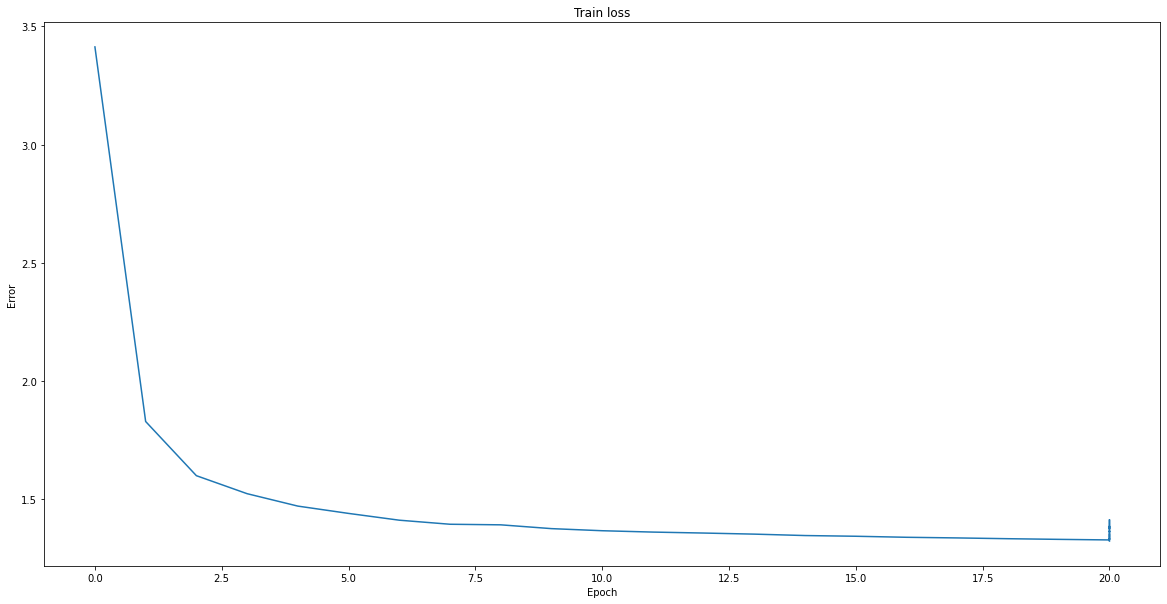

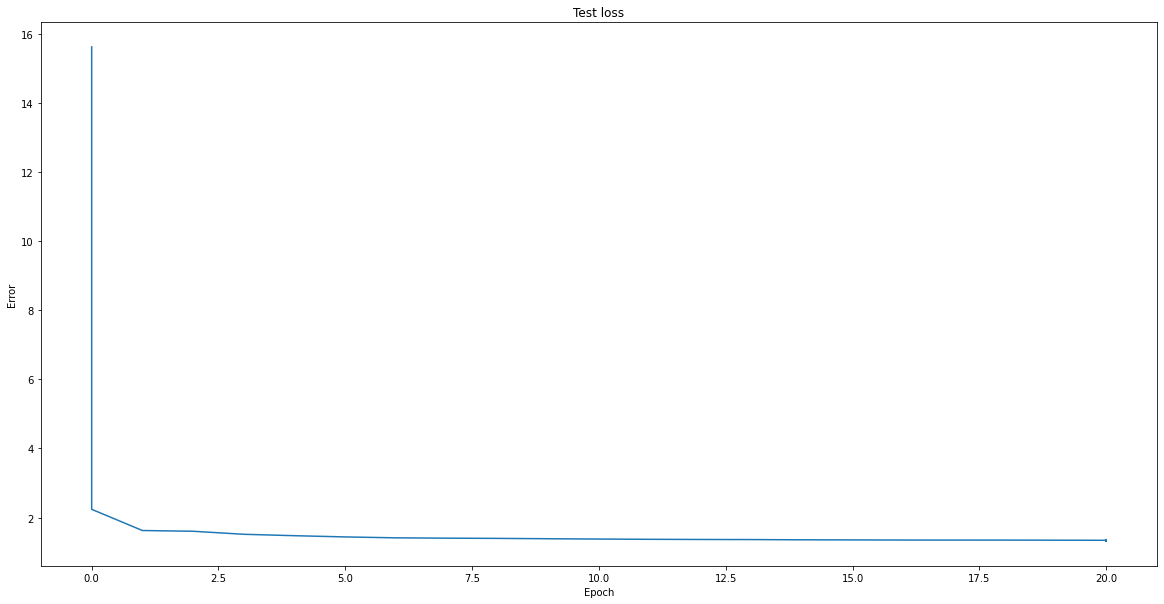

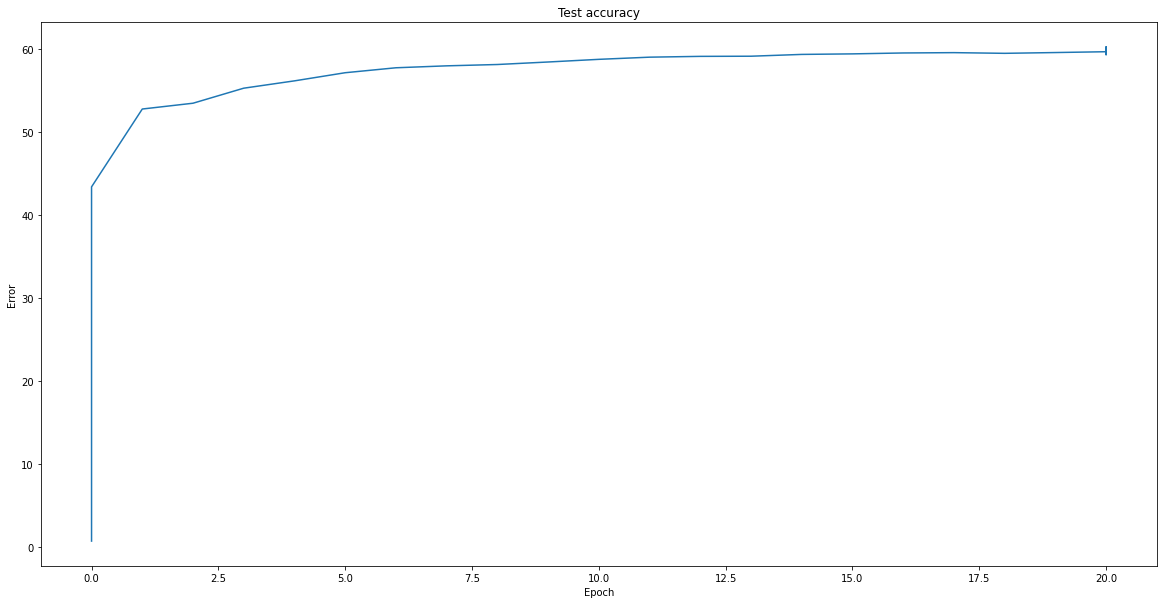

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
# perplexity calculations
def get_perplexities(losses):
  epochs, losses = zip(*losses)
  perplexities = np.exp(losses)
  print(losses)
  print(perplexities)
  return epochs, perplexities

(3.730947833794814, 1.8343419038332425, 1.6251259773205489, 1.5141626376372117, 1.4681017521100166, 1.436001813106048, 1.4172638404063689, 1.3963268597920735, 1.3836105860196628, 1.3759618098919209, 1.3703389632396208, 1.363567922054193, 1.3582906062786395, 1.3533120033068535, 1.3491202336091261, 1.344651967439896, 1.341245030134152, 1.3378074921094454, 1.3351997069823436, 1.3324527703798734, 1.330045749590947)
[41.71863176  6.26101244  5.07905884  4.54561321  4.34098705  4.20385438
  4.12581609  4.04033197  3.98927929  3.95888258  3.93668486  3.91011944
  3.88953886  3.87022252  3.85403339  3.83685096  3.82380129  3.81067939
  3.80075491  3.7903288   3.78121637]


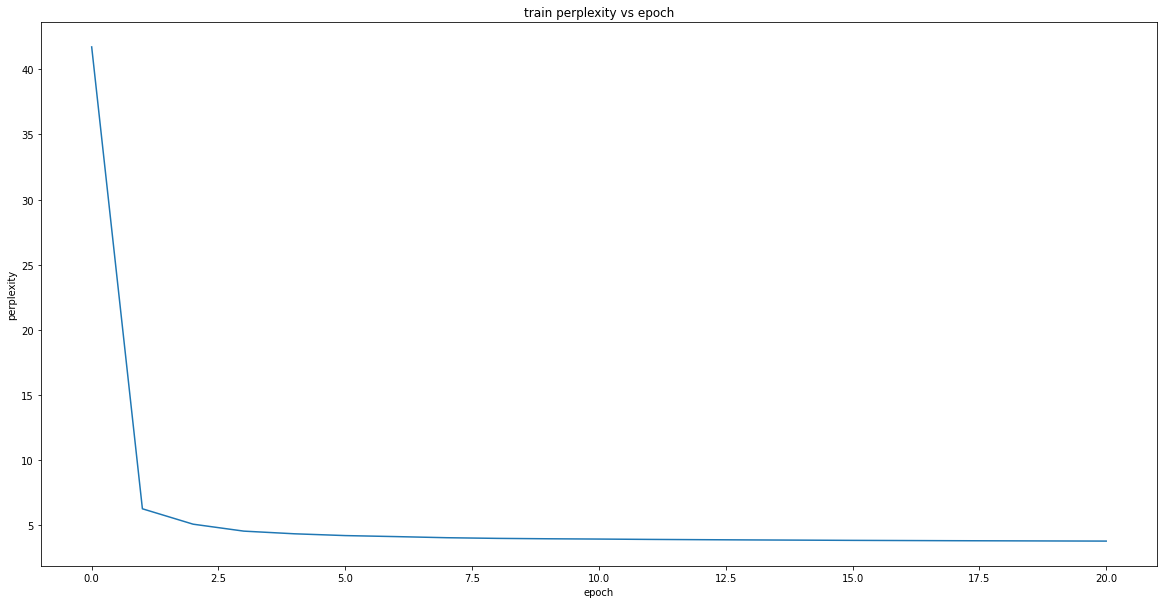

(16.908774122899892, 2.488392640133293, 1.7214039588461116, 1.5439127829610084, 1.5138281827070275, 1.4640545772046458, 1.4410660631802616, 1.41791198448259, 1.4076488261320153, 1.4005752145027628, 1.3934066319952205, 1.3831275871821813, 1.376167934768054, 1.369210800346063, 1.3644602736648248, 1.3591144182244126, 1.3550370785654808, 1.3519670136120854, 1.3491028936541811, 1.3461242549273433, 1.342881837669684, 1.341024029011629)
[2.20489188e+07 1.20419049e+01 5.59237442e+00 4.68287755e+00
 4.54409316e+00 4.32345382e+00 4.22519774e+00 4.12849108e+00
 4.08633641e+00 4.05753325e+00 4.02855049e+00 3.98735294e+00
 3.95969869e+00 3.93224614e+00 3.91361020e+00 3.89274443e+00
 3.87690470e+00 3.86502061e+00 3.85396656e+00 3.84250407e+00
 3.83006524e+00 3.82295632e+00]


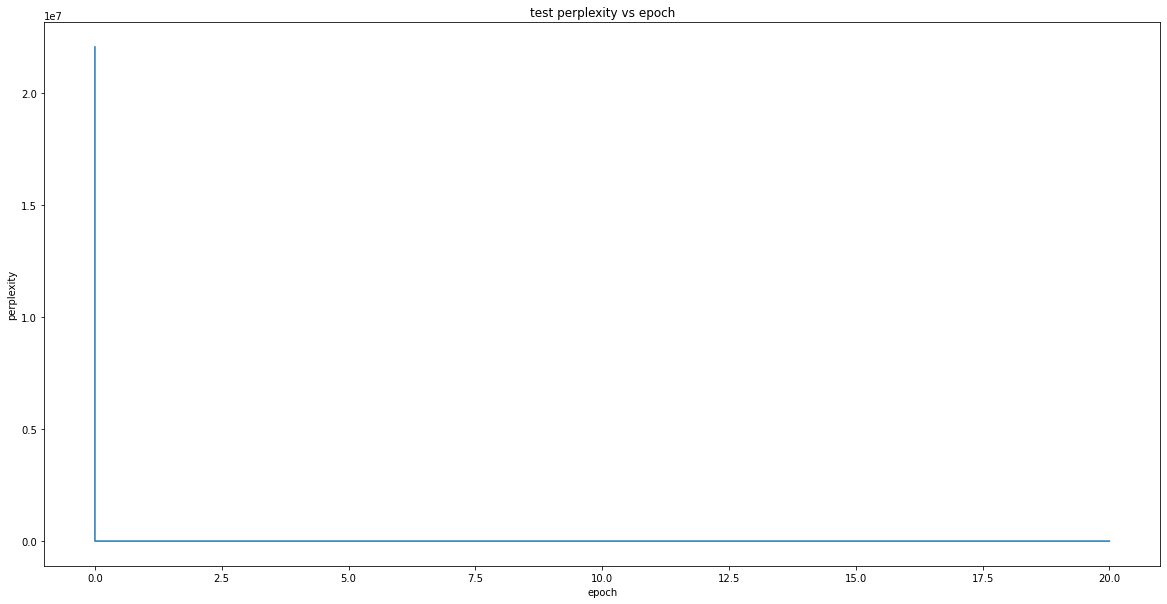

In [ ]:
LOG_PATH = DATA_PATH + 'logs/log.pkl'
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
train_epochs, train_perplexities = get_perplexities(train_losses)
pt_util.plot(train_epochs, train_perplexities, "train perplexity vs epoch", "epoch", "perplexity")
test_epochs, test_perplexities = get_perplexities(test_losses)
pt_util.plot(test_epochs, test_perplexities, "test perplexity vs epoch", "epoch", "perplexity")

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the stars of the stars of the stars of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of
generated with sample	 Harry Potter and the Maintos tell a crow of a thousand stand of a pale of bloody cloaks his flesh and told him. The hand of the hall was seen for a castle of a chair that we never had a brown line to pay the sage of a pe
generated with sample	 Harry Potter and the hall been the stone remain the gave had been the right in brave of his side of the feet. “They would see the cold bite of worstank of the maid of its crow and steps and lite dark and counselves resce
generated with sample	 Harry Potter and they were not to end offer. She was a small gold, but they made some steps. He was a huge to whispered. She was a moment she had speaked the sound when she turned a space of a thin think and she had been
generated with sample	 Harr

KeyboardInterrupt: ignored

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Experiment 1: Training on Game of Thrones

In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'got.txt')):
    os.chdir(BASE_PATH)
    !cp got.txt /content
os.chdir('/content')

In [ ]:
def prepare_thrones_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = " ".join(data.split())
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data_tokens = []
    index = 0
    for char in data:
      if char not in voc2ind:
        voc2ind[char] = index
        index += 1
      data_tokens.append(voc2ind[char])
    print(len(voc2ind.items()))

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_size = int(len(data_tokens) * 0.8)
    train_text = data_tokens[:train_size]
    test_text = data_tokens[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'got_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'got_chars_test.pkl', 'wb'))
    
prepare_thrones_data(DATA_PATH + 'got.txt')

92


Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([92, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([92, 512]) = 0MB
decoder.bias -> 	torch.Size([92]) = 0MB

Restored all variables
No new variables
Restored /content/got_checkpoints/000.pt
Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa tt  edd tf teewe ng tar  be said t  hech an teeng   ene  “e wtid thet hes tenet l mrt the besff


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed teankknd fat

  1%|          | 3/303 [00:00<00:20, 14.51it/s]

Train Epoch: 0 [0/77568 (0%)]	Loss: 1.855287


  5%|▍         | 15/303 [00:00<00:14, 20.37it/s]

Train Epoch: 0 [2560/77568 (3%)]	Loss: 7.181319


  8%|▊         | 24/303 [00:01<00:13, 20.46it/s]

Train Epoch: 0 [5120/77568 (7%)]	Loss: 3.739657


 11%|█         | 33/303 [00:01<00:12, 20.79it/s]

Train Epoch: 0 [7680/77568 (10%)]	Loss: 2.608840


 15%|█▍        | 45/303 [00:02<00:12, 21.05it/s]

Train Epoch: 0 [10240/77568 (13%)]	Loss: 2.220346


 18%|█▊        | 54/303 [00:02<00:11, 20.81it/s]

Train Epoch: 0 [12800/77568 (17%)]	Loss: 1.983130


 21%|██        | 63/303 [00:03<00:11, 20.67it/s]

Train Epoch: 0 [15360/77568 (20%)]	Loss: 1.860226


 25%|██▍       | 75/303 [00:03<00:10, 20.90it/s]

Train Epoch: 0 [17920/77568 (23%)]	Loss: 1.795170


 28%|██▊       | 84/303 [00:04<00:10, 21.21it/s]

Train Epoch: 0 [20480/77568 (26%)]	Loss: 1.896726


 31%|███       | 93/303 [00:04<00:09, 21.09it/s]

Train Epoch: 0 [23040/77568 (30%)]	Loss: 1.925882


 35%|███▍      | 105/303 [00:05<00:09, 20.64it/s]

Train Epoch: 0 [25600/77568 (33%)]	Loss: 1.863376


 38%|███▊      | 114/303 [00:05<00:08, 21.20it/s]

Train Epoch: 0 [28160/77568 (36%)]	Loss: 1.778251


 41%|████      | 123/303 [00:05<00:08, 21.17it/s]

Train Epoch: 0 [30720/77568 (40%)]	Loss: 1.753751


 45%|████▍     | 135/303 [00:06<00:07, 21.34it/s]

Train Epoch: 0 [33280/77568 (43%)]	Loss: 1.951487


 48%|████▊     | 144/303 [00:06<00:07, 21.24it/s]

Train Epoch: 0 [35840/77568 (46%)]	Loss: 1.905292


 50%|█████     | 153/303 [00:07<00:07, 21.38it/s]

Train Epoch: 0 [38400/77568 (50%)]	Loss: 1.815527


 54%|█████▍    | 165/303 [00:07<00:06, 21.22it/s]

Train Epoch: 0 [40960/77568 (53%)]	Loss: 1.699102


 57%|█████▋    | 174/303 [00:08<00:06, 20.72it/s]

Train Epoch: 0 [43520/77568 (56%)]	Loss: 1.694995


 60%|██████    | 183/303 [00:08<00:05, 20.81it/s]

Train Epoch: 0 [46080/77568 (59%)]	Loss: 1.672602


 64%|██████▍   | 195/303 [00:09<00:05, 21.17it/s]

Train Epoch: 0 [48640/77568 (63%)]	Loss: 1.637770


 67%|██████▋   | 204/303 [00:09<00:04, 21.12it/s]

Train Epoch: 0 [51200/77568 (66%)]	Loss: 1.674124


 70%|███████   | 213/303 [00:10<00:04, 21.30it/s]

Train Epoch: 0 [53760/77568 (69%)]	Loss: 1.675940


 74%|███████▍  | 225/303 [00:10<00:03, 21.05it/s]

Train Epoch: 0 [56320/77568 (73%)]	Loss: 1.689811


 77%|███████▋  | 234/303 [00:11<00:03, 21.28it/s]

Train Epoch: 0 [58880/77568 (76%)]	Loss: 1.639120


 80%|████████  | 243/303 [00:11<00:02, 20.96it/s]

Train Epoch: 0 [61440/77568 (79%)]	Loss: 1.635103


 84%|████████▍ | 255/303 [00:12<00:02, 20.88it/s]

Train Epoch: 0 [64000/77568 (83%)]	Loss: 1.826936


 87%|████████▋ | 264/303 [00:12<00:01, 20.80it/s]

Train Epoch: 0 [66560/77568 (86%)]	Loss: 1.774708


 90%|█████████ | 273/303 [00:13<00:01, 20.73it/s]

Train Epoch: 0 [69120/77568 (89%)]	Loss: 1.760152


 94%|█████████▍| 285/303 [00:13<00:00, 20.68it/s]

Train Epoch: 0 [71680/77568 (92%)]	Loss: 1.702692


 97%|█████████▋| 294/303 [00:14<00:00, 20.79it/s]

Train Epoch: 0 [74240/77568 (96%)]	Loss: 1.666193


100%|██████████| 303/303 [00:14<00:00, 20.87it/s]

Train Epoch: 0 [76800/77568 (99%)]	Loss: 1.641185


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	eteretn ierd tf tlewe ng tir  ae stid tn hach a  htelc    ne  Hi wtid thet hhs hel t d hit the milmo


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed ttonkind foter of the mightaerton   anminedoh estnout tiigon  thet thme ow hane hhe  onout tn ht 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trloc  eg tnd tt wauld hnpedr  “ytmoghnd hariarsah   tnay her hideh hloaher and leaurn d toe  oloak


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:39,  7.61it/s]

Train Epoch: 1 [0/77568 (0%)]	Loss: 1.648072


  5%|▍         | 14/303 [00:00<00:14, 20.32it/s]

Train Epoch: 1 [2560/77568 (3%)]	Loss: 1.667469


  8%|▊         | 23/303 [00:01<00:13, 20.81it/s]

Train Epoch: 1 [5120/77568 (7%)]	Loss: 1.620814


 12%|█▏        | 35/303 [00:01<00:12, 20.98it/s]

Train Epoch: 1 [7680/77568 (10%)]	Loss: 1.620652


 15%|█▍        | 44/303 [00:02<00:12, 21.02it/s]

Train Epoch: 1 [10240/77568 (13%)]	Loss: 1.640579


 17%|█▋        | 53/303 [00:02<00:11, 21.04it/s]

Train Epoch: 1 [12800/77568 (17%)]	Loss: 1.610482


 21%|██▏       | 65/303 [00:03<00:11, 20.67it/s]

Train Epoch: 1 [15360/77568 (20%)]	Loss: 1.587923


 24%|██▍       | 74/303 [00:03<00:11, 20.72it/s]

Train Epoch: 1 [17920/77568 (23%)]	Loss: 1.569154


 27%|██▋       | 83/303 [00:04<00:10, 20.61it/s]

Train Epoch: 1 [20480/77568 (26%)]	Loss: 1.688217


 30%|███       | 92/303 [00:04<00:10, 20.60it/s]

Train Epoch: 1 [23040/77568 (30%)]	Loss: 1.671654


 34%|███▍      | 104/303 [00:05<00:09, 20.45it/s]

Train Epoch: 1 [25600/77568 (33%)]	Loss: 1.612801


 37%|███▋      | 113/303 [00:05<00:09, 20.91it/s]

Train Epoch: 1 [28160/77568 (36%)]	Loss: 1.614638


 41%|████▏     | 125/303 [00:06<00:08, 20.91it/s]

Train Epoch: 1 [30720/77568 (40%)]	Loss: 1.570883


 44%|████▍     | 134/303 [00:06<00:07, 21.32it/s]

Train Epoch: 1 [33280/77568 (43%)]	Loss: 1.578066


 47%|████▋     | 143/303 [00:06<00:07, 21.06it/s]

Train Epoch: 1 [35840/77568 (46%)]	Loss: 1.586268


 51%|█████     | 155/303 [00:07<00:06, 21.35it/s]

Train Epoch: 1 [38400/77568 (50%)]	Loss: 1.680119


 54%|█████▍    | 164/303 [00:07<00:06, 21.10it/s]

Train Epoch: 1 [40960/77568 (53%)]	Loss: 1.592396


 57%|█████▋    | 173/303 [00:08<00:06, 21.07it/s]

Train Epoch: 1 [43520/77568 (56%)]	Loss: 1.578978


 61%|██████    | 185/303 [00:08<00:05, 20.73it/s]

Train Epoch: 1 [46080/77568 (59%)]	Loss: 1.558436


 64%|██████▍   | 194/303 [00:09<00:05, 20.90it/s]

Train Epoch: 1 [48640/77568 (63%)]	Loss: 1.540723


 67%|██████▋   | 203/303 [00:09<00:04, 20.91it/s]

Train Epoch: 1 [51200/77568 (66%)]	Loss: 1.630984


 71%|███████   | 215/303 [00:10<00:04, 20.60it/s]

Train Epoch: 1 [53760/77568 (69%)]	Loss: 1.557913


 74%|███████▍  | 224/303 [00:10<00:03, 20.41it/s]

Train Epoch: 1 [56320/77568 (73%)]	Loss: 1.584669


 77%|███████▋  | 233/303 [00:11<00:03, 20.29it/s]

Train Epoch: 1 [58880/77568 (76%)]	Loss: 1.538104


 81%|████████  | 245/303 [00:11<00:02, 20.61it/s]

Train Epoch: 1 [61440/77568 (79%)]	Loss: 1.530818


 84%|████████▍ | 254/303 [00:12<00:02, 20.61it/s]

Train Epoch: 1 [64000/77568 (83%)]	Loss: 1.544947


 87%|████████▋ | 263/303 [00:12<00:01, 20.78it/s]

Train Epoch: 1 [66560/77568 (86%)]	Loss: 1.568943


 91%|█████████ | 275/303 [00:13<00:01, 20.57it/s]

Train Epoch: 1 [69120/77568 (89%)]	Loss: 1.551193


 94%|█████████▎| 284/303 [00:13<00:00, 21.01it/s]

Train Epoch: 1 [71680/77568 (92%)]	Loss: 1.541819


 97%|█████████▋| 293/303 [00:14<00:00, 20.90it/s]

Train Epoch: 1 [74240/77568 (96%)]	Loss: 1.538586


100%|██████████| 303/303 [00:14<00:00, 20.71it/s]

Train Epoch: 1 [76800/77568 (99%)]	Loss: 1.520677


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etea sn iead af thews ng ter  ae said tn hach a  teelg   ane  “e wtid thet tas ael t d sot the malmo


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed aeankind loter af the magh aerton   anwene th asa out tiagon  thet th etow hane hhe  alout tn hf 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 heloc  em and tn wauld hnpeare “yteegfnd sariarsah   a ay fer fideh wleaher and seaurn d the  aooan


Input	Tell me that she has not died, I beg 

  1%|          | 3/303 [00:00<00:27, 10.79it/s]

Train Epoch: 2 [0/77568 (0%)]	Loss: 1.543138


  5%|▍         | 15/303 [00:00<00:14, 19.47it/s]

Train Epoch: 2 [2560/77568 (3%)]	Loss: 1.544908


  8%|▊         | 25/303 [00:01<00:13, 20.16it/s]

Train Epoch: 2 [5120/77568 (7%)]	Loss: 1.540896


 11%|█         | 34/303 [00:01<00:12, 21.00it/s]

Train Epoch: 2 [7680/77568 (10%)]	Loss: 1.530752


 14%|█▍        | 43/303 [00:02<00:12, 20.39it/s]

Train Epoch: 2 [10240/77568 (13%)]	Loss: 1.564815


 18%|█▊        | 55/303 [00:02<00:11, 20.87it/s]

Train Epoch: 2 [12800/77568 (17%)]	Loss: 1.524761


 21%|██        | 64/303 [00:03<00:11, 20.65it/s]

Train Epoch: 2 [15360/77568 (20%)]	Loss: 1.519368


 24%|██▍       | 73/303 [00:03<00:11, 20.72it/s]

Train Epoch: 2 [17920/77568 (23%)]	Loss: 1.506234


 28%|██▊       | 85/303 [00:04<00:10, 20.60it/s]

Train Epoch: 2 [20480/77568 (26%)]	Loss: 1.551245


 31%|███       | 94/303 [00:04<00:10, 20.59it/s]

Train Epoch: 2 [23040/77568 (30%)]	Loss: 1.542895


 34%|███▍      | 103/303 [00:05<00:09, 20.87it/s]

Train Epoch: 2 [25600/77568 (33%)]	Loss: 1.520282


 38%|███▊      | 115/303 [00:05<00:08, 20.95it/s]

Train Epoch: 2 [28160/77568 (36%)]	Loss: 1.551536


 41%|████      | 124/303 [00:06<00:08, 21.14it/s]

Train Epoch: 2 [30720/77568 (40%)]	Loss: 1.527852


 44%|████▍     | 133/303 [00:06<00:08, 21.02it/s]

Train Epoch: 2 [33280/77568 (43%)]	Loss: 1.502653


 48%|████▊     | 145/303 [00:07<00:07, 21.14it/s]

Train Epoch: 2 [35840/77568 (46%)]	Loss: 1.474251


 51%|█████     | 154/303 [00:07<00:07, 21.08it/s]

Train Epoch: 2 [38400/77568 (50%)]	Loss: 1.511598


 54%|█████▍    | 163/303 [00:07<00:06, 21.09it/s]

Train Epoch: 2 [40960/77568 (53%)]	Loss: 1.505473


 58%|█████▊    | 175/303 [00:08<00:06, 20.86it/s]

Train Epoch: 2 [43520/77568 (56%)]	Loss: 1.515318


 61%|██████    | 184/303 [00:08<00:05, 20.83it/s]

Train Epoch: 2 [46080/77568 (59%)]	Loss: 1.522744


 64%|██████▎   | 193/303 [00:09<00:05, 20.83it/s]

Train Epoch: 2 [48640/77568 (63%)]	Loss: 1.493743


 68%|██████▊   | 205/303 [00:09<00:04, 20.78it/s]

Train Epoch: 2 [51200/77568 (66%)]	Loss: 1.501662


 71%|███████   | 214/303 [00:10<00:04, 20.38it/s]

Train Epoch: 2 [53760/77568 (69%)]	Loss: 1.507540


 74%|███████▎  | 223/303 [00:10<00:03, 20.23it/s]

Train Epoch: 2 [56320/77568 (73%)]	Loss: 1.591175


 78%|███████▊  | 235/303 [00:11<00:03, 21.05it/s]

Train Epoch: 2 [58880/77568 (76%)]	Loss: 1.499433


 81%|████████  | 244/303 [00:11<00:02, 21.28it/s]

Train Epoch: 2 [61440/77568 (79%)]	Loss: 1.492090


 83%|████████▎ | 253/303 [00:12<00:02, 20.86it/s]

Train Epoch: 2 [64000/77568 (83%)]	Loss: 1.492674


 87%|████████▋ | 265/303 [00:12<00:01, 21.40it/s]

Train Epoch: 2 [66560/77568 (86%)]	Loss: 1.486853


 90%|█████████ | 274/303 [00:13<00:01, 21.05it/s]

Train Epoch: 2 [69120/77568 (89%)]	Loss: 1.470739


 93%|█████████▎| 283/303 [00:13<00:00, 20.83it/s]

Train Epoch: 2 [71680/77568 (92%)]	Loss: 1.491436


 97%|█████████▋| 295/303 [00:14<00:00, 21.26it/s]

Train Epoch: 2 [74240/77568 (96%)]	Loss: 1.517474


100%|██████████| 303/303 [00:14<00:00, 20.63it/s]

Train Epoch: 2 [76800/77568 (99%)]	Loss: 1.543023


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa an iead af haawn ng aia  aeahaid tn hach an htaeg   ane  “e waid thet has aat h d hit ahemmaymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed atankind hater af the magh aeaton   anwane ah a anout tiagon  ahen th e ow aane hhe  anout tn hf 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 haaoc  im and hn wauld hnpear  “ytmongnd haaiargah   anay faa hideh aaoahes and teaurn d the  aaoan


Input	Tell me that she has not died, I beg 

  1%|▏         | 4/303 [00:00<00:22, 13.02it/s]

Train Epoch: 3 [0/77568 (0%)]	Loss: 1.551280


  5%|▍         | 14/303 [00:00<00:15, 19.00it/s]

Train Epoch: 3 [2560/77568 (3%)]	Loss: 1.536987


  8%|▊         | 23/303 [00:01<00:13, 20.12it/s]

Train Epoch: 3 [5120/77568 (7%)]	Loss: 1.494639


 12%|█▏        | 35/303 [00:01<00:13, 20.57it/s]

Train Epoch: 3 [7680/77568 (10%)]	Loss: 1.466404


 15%|█▍        | 44/303 [00:02<00:12, 21.14it/s]

Train Epoch: 3 [10240/77568 (13%)]	Loss: 1.509739


 17%|█▋        | 53/303 [00:02<00:11, 21.11it/s]

Train Epoch: 3 [12800/77568 (17%)]	Loss: 1.485509


 21%|██▏       | 65/303 [00:03<00:11, 21.09it/s]

Train Epoch: 3 [15360/77568 (20%)]	Loss: 1.478774


 24%|██▍       | 74/303 [00:03<00:10, 20.85it/s]

Train Epoch: 3 [17920/77568 (23%)]	Loss: 1.482104


 27%|██▋       | 83/303 [00:04<00:10, 21.30it/s]

Train Epoch: 3 [20480/77568 (26%)]	Loss: 1.507505


 31%|███▏      | 95/303 [00:04<00:09, 20.88it/s]

Train Epoch: 3 [23040/77568 (30%)]	Loss: 1.504401


 34%|███▍      | 104/303 [00:05<00:09, 20.66it/s]

Train Epoch: 3 [25600/77568 (33%)]	Loss: 1.479717


 37%|███▋      | 113/303 [00:05<00:09, 20.79it/s]

Train Epoch: 3 [28160/77568 (36%)]	Loss: 1.480801


 41%|████▏     | 125/303 [00:06<00:08, 20.65it/s]

Train Epoch: 3 [30720/77568 (40%)]	Loss: 1.462946


 44%|████▍     | 134/303 [00:06<00:08, 20.46it/s]

Train Epoch: 3 [33280/77568 (43%)]	Loss: 1.467156


 47%|████▋     | 143/303 [00:07<00:07, 20.38it/s]

Train Epoch: 3 [35840/77568 (46%)]	Loss: 1.441252


 51%|█████     | 155/303 [00:07<00:07, 20.76it/s]

Train Epoch: 3 [38400/77568 (50%)]	Loss: 1.479577


 54%|█████▍    | 164/303 [00:08<00:06, 20.75it/s]

Train Epoch: 3 [40960/77568 (53%)]	Loss: 1.480746


 57%|█████▋    | 173/303 [00:08<00:06, 20.64it/s]

Train Epoch: 3 [43520/77568 (56%)]	Loss: 1.482509


 61%|██████    | 185/303 [00:09<00:05, 20.53it/s]

Train Epoch: 3 [46080/77568 (59%)]	Loss: 1.488396


 64%|██████▍   | 194/303 [00:09<00:05, 20.63it/s]

Train Epoch: 3 [48640/77568 (63%)]	Loss: 1.462161


 67%|██████▋   | 203/303 [00:09<00:04, 20.80it/s]

Train Epoch: 3 [51200/77568 (66%)]	Loss: 1.480267


 71%|███████   | 215/303 [00:10<00:04, 20.91it/s]

Train Epoch: 3 [53760/77568 (69%)]	Loss: 1.475750


 74%|███████▍  | 224/303 [00:10<00:03, 20.53it/s]

Train Epoch: 3 [56320/77568 (73%)]	Loss: 1.501033


 77%|███████▋  | 233/303 [00:11<00:03, 20.60it/s]

Train Epoch: 3 [58880/77568 (76%)]	Loss: 1.469289


 81%|████████  | 245/303 [00:11<00:02, 20.87it/s]

Train Epoch: 3 [61440/77568 (79%)]	Loss: 1.454880


 84%|████████▍ | 254/303 [00:12<00:02, 21.17it/s]

Train Epoch: 3 [64000/77568 (83%)]	Loss: 1.482291


 87%|████████▋ | 263/303 [00:12<00:01, 20.81it/s]

Train Epoch: 3 [66560/77568 (86%)]	Loss: 1.475526


 91%|█████████ | 275/303 [00:13<00:01, 20.44it/s]

Train Epoch: 3 [69120/77568 (89%)]	Loss: 1.456899


 94%|█████████▎| 284/303 [00:13<00:00, 20.82it/s]

Train Epoch: 3 [71680/77568 (92%)]	Loss: 1.462463


 97%|█████████▋| 293/303 [00:14<00:00, 21.25it/s]

Train Epoch: 3 [74240/77568 (96%)]	Loss: 1.471141


100%|██████████| 303/303 [00:14<00:00, 20.56it/s]

Train Epoch: 3 [76800/77568 (99%)]	Loss: 1.478925


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	eaaa an iead af taawn ng aia  aeasawd,tn wach an ateedi  ane  “e whid thet tas aar t m sot ahe maymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed atanktnd tater af the maghtaaaton   anmane ah m anout tiagons ahet th etow hane hhe  anout tn hf 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 haaon  ig and tt wauld bnpear  “atmongnd harlarnah k anay fir haeeh aaoahes and saaurn d the  aaoan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:37,  7.97it/s]

Train Epoch: 4 [0/77568 (0%)]	Loss: 1.499999


  5%|▍         | 15/303 [00:00<00:14, 20.12it/s]

Train Epoch: 4 [2560/77568 (3%)]	Loss: 1.503707


  8%|▊         | 24/303 [00:01<00:13, 20.80it/s]

Train Epoch: 4 [5120/77568 (7%)]	Loss: 1.465972


 11%|█         | 33/303 [00:01<00:13, 20.68it/s]

Train Epoch: 4 [7680/77568 (10%)]	Loss: 1.447541


 15%|█▍        | 45/303 [00:02<00:12, 20.84it/s]

Train Epoch: 4 [10240/77568 (13%)]	Loss: 1.490783


 18%|█▊        | 54/303 [00:02<00:11, 21.04it/s]

Train Epoch: 4 [12800/77568 (17%)]	Loss: 1.459893


 21%|██        | 63/303 [00:03<00:11, 21.11it/s]

Train Epoch: 4 [15360/77568 (20%)]	Loss: 1.456553


 25%|██▍       | 75/303 [00:03<00:10, 21.25it/s]

Train Epoch: 4 [17920/77568 (23%)]	Loss: 1.449211


 28%|██▊       | 84/303 [00:04<00:10, 21.00it/s]

Train Epoch: 4 [20480/77568 (26%)]	Loss: 1.479398


 31%|███       | 93/303 [00:04<00:10, 20.64it/s]

Train Epoch: 4 [23040/77568 (30%)]	Loss: 1.479637


 35%|███▍      | 105/303 [00:05<00:09, 21.23it/s]

Train Epoch: 4 [25600/77568 (33%)]	Loss: 1.458257


 38%|███▊      | 114/303 [00:05<00:09, 20.69it/s]

Train Epoch: 4 [28160/77568 (36%)]	Loss: 1.459312


 41%|████      | 123/303 [00:05<00:08, 20.27it/s]

Train Epoch: 4 [30720/77568 (40%)]	Loss: 1.445283


 45%|████▍     | 135/303 [00:06<00:08, 20.26it/s]

Train Epoch: 4 [33280/77568 (43%)]	Loss: 1.449146


 48%|████▊     | 144/303 [00:06<00:07, 21.10it/s]

Train Epoch: 4 [35840/77568 (46%)]	Loss: 1.434973


 50%|█████     | 153/303 [00:07<00:07, 20.89it/s]

Train Epoch: 4 [38400/77568 (50%)]	Loss: 1.466582


 54%|█████▍    | 165/303 [00:07<00:06, 21.08it/s]

Train Epoch: 4 [40960/77568 (53%)]	Loss: 1.453926


 57%|█████▋    | 174/303 [00:08<00:06, 21.00it/s]

Train Epoch: 4 [43520/77568 (56%)]	Loss: 1.457938


 60%|██████    | 183/303 [00:08<00:05, 20.81it/s]

Train Epoch: 4 [46080/77568 (59%)]	Loss: 1.453449


 64%|██████▍   | 195/303 [00:09<00:05, 21.10it/s]

Train Epoch: 4 [48640/77568 (63%)]	Loss: 1.442853


 67%|██████▋   | 204/303 [00:09<00:04, 21.04it/s]

Train Epoch: 4 [51200/77568 (66%)]	Loss: 1.455597


 70%|███████   | 213/303 [00:10<00:04, 20.34it/s]

Train Epoch: 4 [53760/77568 (69%)]	Loss: 1.482090


 74%|███████▍  | 225/303 [00:10<00:03, 21.30it/s]

Train Epoch: 4 [56320/77568 (73%)]	Loss: 1.494695


 77%|███████▋  | 234/303 [00:11<00:03, 20.71it/s]

Train Epoch: 4 [58880/77568 (76%)]	Loss: 1.448493


 80%|████████  | 243/303 [00:11<00:02, 20.51it/s]

Train Epoch: 4 [61440/77568 (79%)]	Loss: 1.441819


 84%|████████▍ | 255/303 [00:12<00:02, 20.59it/s]

Train Epoch: 4 [64000/77568 (83%)]	Loss: 1.452786


 87%|████████▋ | 264/303 [00:12<00:01, 20.70it/s]

Train Epoch: 4 [66560/77568 (86%)]	Loss: 1.441384


 90%|█████████ | 273/303 [00:13<00:01, 20.68it/s]

Train Epoch: 4 [69120/77568 (89%)]	Loss: 1.436070


 94%|█████████▍| 285/303 [00:13<00:00, 20.94it/s]

Train Epoch: 4 [71680/77568 (92%)]	Loss: 1.444016


 97%|█████████▋| 294/303 [00:14<00:00, 20.93it/s]

Train Epoch: 4 [74240/77568 (96%)]	Loss: 1.446988


100%|██████████| 303/303 [00:14<00:00, 20.70it/s]

Train Epoch: 4 [76800/77568 (99%)]	Loss: 1.474222


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	eaaa an iead af taawn ng air  ae sawd tn wach an ateeci  ane. Te whid thet tas air t m sit ahe maymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed atanktnd tater af the maghtaaaton   anmane ah e anout tiagons.ahet th e ow hane ahe  anout tn ht 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 haaon sig and tt wauld bnpear  Iateongnd harlarnah k anay fir fade. aaaahes and taaurn d the  aaaan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:38,  7.86it/s]

Train Epoch: 5 [0/77568 (0%)]	Loss: 1.486807


  4%|▍         | 13/303 [00:00<00:14, 19.68it/s]

Train Epoch: 5 [2560/77568 (3%)]	Loss: 1.477079


  8%|▊         | 25/303 [00:01<00:13, 20.74it/s]

Train Epoch: 5 [5120/77568 (7%)]	Loss: 1.444738


 11%|█         | 34/303 [00:01<00:12, 20.86it/s]

Train Epoch: 5 [7680/77568 (10%)]	Loss: 1.428129


 14%|█▍        | 43/303 [00:02<00:12, 21.05it/s]

Train Epoch: 5 [10240/77568 (13%)]	Loss: 1.471679


 18%|█▊        | 55/303 [00:02<00:11, 21.21it/s]

Train Epoch: 5 [12800/77568 (17%)]	Loss: 1.448917


 21%|██        | 64/303 [00:03<00:11, 21.24it/s]

Train Epoch: 5 [15360/77568 (20%)]	Loss: 1.442964


 24%|██▍       | 73/303 [00:03<00:10, 21.03it/s]

Train Epoch: 5 [17920/77568 (23%)]	Loss: 1.442716


 28%|██▊       | 85/303 [00:04<00:10, 21.15it/s]

Train Epoch: 5 [20480/77568 (26%)]	Loss: 1.467503


 31%|███       | 94/303 [00:04<00:10, 20.69it/s]

Train Epoch: 5 [23040/77568 (30%)]	Loss: 1.470844


 34%|███▍      | 103/303 [00:05<00:09, 20.98it/s]

Train Epoch: 5 [25600/77568 (33%)]	Loss: 1.445278


 38%|███▊      | 115/303 [00:05<00:08, 20.89it/s]

Train Epoch: 5 [28160/77568 (36%)]	Loss: 1.444674


 41%|████      | 124/303 [00:06<00:08, 20.33it/s]

Train Epoch: 5 [30720/77568 (40%)]	Loss: 1.427708


 44%|████▍     | 133/303 [00:06<00:08, 20.17it/s]

Train Epoch: 5 [33280/77568 (43%)]	Loss: 1.434568


 48%|████▊     | 145/303 [00:07<00:07, 20.98it/s]

Train Epoch: 5 [35840/77568 (46%)]	Loss: 1.409907


 51%|█████     | 154/303 [00:07<00:07, 20.75it/s]

Train Epoch: 5 [38400/77568 (50%)]	Loss: 1.453102


 54%|█████▍    | 163/303 [00:07<00:06, 20.72it/s]

Train Epoch: 5 [40960/77568 (53%)]	Loss: 1.437722


 58%|█████▊    | 175/303 [00:08<00:06, 21.05it/s]

Train Epoch: 5 [43520/77568 (56%)]	Loss: 1.447341


 61%|██████    | 184/303 [00:08<00:05, 20.71it/s]

Train Epoch: 5 [46080/77568 (59%)]	Loss: 1.448949


 64%|██████▎   | 193/303 [00:09<00:05, 20.61it/s]

Train Epoch: 5 [48640/77568 (63%)]	Loss: 1.431078


 68%|██████▊   | 205/303 [00:09<00:04, 21.03it/s]

Train Epoch: 5 [51200/77568 (66%)]	Loss: 1.448306


 71%|███████   | 214/303 [00:10<00:04, 20.83it/s]

Train Epoch: 5 [53760/77568 (69%)]	Loss: 1.444046


 74%|███████▎  | 223/303 [00:10<00:03, 20.65it/s]

Train Epoch: 5 [56320/77568 (73%)]	Loss: 1.467402


 78%|███████▊  | 235/303 [00:11<00:03, 21.01it/s]

Train Epoch: 5 [58880/77568 (76%)]	Loss: 1.435554


 81%|████████  | 244/303 [00:11<00:02, 20.83it/s]

Train Epoch: 5 [61440/77568 (79%)]	Loss: 1.429486


 83%|████████▎ | 253/303 [00:12<00:02, 20.72it/s]

Train Epoch: 5 [64000/77568 (83%)]	Loss: 1.440986


 87%|████████▋ | 263/303 [00:12<00:02, 19.87it/s]

Train Epoch: 5 [66560/77568 (86%)]	Loss: 1.428566


 90%|█████████ | 274/303 [00:13<00:01, 20.77it/s]

Train Epoch: 5 [69120/77568 (89%)]	Loss: 1.424281


 93%|█████████▎| 283/303 [00:13<00:00, 20.99it/s]

Train Epoch: 5 [71680/77568 (92%)]	Loss: 1.429334


 97%|█████████▋| 295/303 [00:14<00:00, 21.09it/s]

Train Epoch: 5 [74240/77568 (96%)]	Loss: 1.439233


100%|██████████| 303/303 [00:14<00:00, 20.69it/s]

Train Epoch: 5 [76800/77568 (99%)]	Loss: 1.459121


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn iead af taawn ng air  ae waid tn wach an aeeedi  ane  Te waid thet tas air t m sot ahe saymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed atarktnd taner af the magh aeaton   anmane ah e anout tiagons.ahet th e ow tane hhe  anout t  wt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 traiw seg and tt wauld bnpear  Iyt iggnd tari rnah k anay tir fade. aaoahes and siaurn d the  aaoan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:38,  7.88it/s]

Train Epoch: 6 [0/77568 (0%)]	Loss: 1.463505


  5%|▍         | 14/303 [00:00<00:14, 19.99it/s]

Train Epoch: 6 [2560/77568 (3%)]	Loss: 1.452045


  8%|▊         | 23/303 [00:01<00:13, 20.50it/s]

Train Epoch: 6 [5120/77568 (7%)]	Loss: 1.430841


 12%|█▏        | 35/303 [00:01<00:12, 21.04it/s]

Train Epoch: 6 [7680/77568 (10%)]	Loss: 1.417087


 15%|█▍        | 44/303 [00:02<00:12, 20.93it/s]

Train Epoch: 6 [10240/77568 (13%)]	Loss: 1.458104


 17%|█▋        | 53/303 [00:02<00:12, 20.76it/s]

Train Epoch: 6 [12800/77568 (17%)]	Loss: 1.441999


 21%|██▏       | 65/303 [00:03<00:11, 20.64it/s]

Train Epoch: 6 [15360/77568 (20%)]	Loss: 1.431710


 24%|██▍       | 74/303 [00:03<00:11, 20.73it/s]

Train Epoch: 6 [17920/77568 (23%)]	Loss: 1.419261


 27%|██▋       | 83/303 [00:04<00:10, 21.17it/s]

Train Epoch: 6 [20480/77568 (26%)]	Loss: 1.451422


 31%|███▏      | 95/303 [00:04<00:09, 21.06it/s]

Train Epoch: 6 [23040/77568 (30%)]	Loss: 1.459576


 34%|███▍      | 104/303 [00:05<00:09, 20.79it/s]

Train Epoch: 6 [25600/77568 (33%)]	Loss: 1.438018


 37%|███▋      | 113/303 [00:05<00:08, 21.14it/s]

Train Epoch: 6 [28160/77568 (36%)]	Loss: 1.433406


 41%|████▏     | 125/303 [00:06<00:08, 20.67it/s]

Train Epoch: 6 [30720/77568 (40%)]	Loss: 1.415920


 44%|████▍     | 134/303 [00:06<00:08, 20.79it/s]

Train Epoch: 6 [33280/77568 (43%)]	Loss: 1.424355


 47%|████▋     | 143/303 [00:06<00:07, 20.62it/s]

Train Epoch: 6 [35840/77568 (46%)]	Loss: 1.404308


 51%|█████     | 155/303 [00:07<00:07, 20.75it/s]

Train Epoch: 6 [38400/77568 (50%)]	Loss: 1.434212


 54%|█████▍    | 164/303 [00:07<00:06, 21.10it/s]

Train Epoch: 6 [40960/77568 (53%)]	Loss: 1.427322


 57%|█████▋    | 173/303 [00:08<00:06, 20.61it/s]

Train Epoch: 6 [43520/77568 (56%)]	Loss: 1.436388


 61%|██████    | 185/303 [00:08<00:05, 20.76it/s]

Train Epoch: 6 [46080/77568 (59%)]	Loss: 1.432973


 64%|██████▍   | 194/303 [00:09<00:05, 20.44it/s]

Train Epoch: 6 [48640/77568 (63%)]	Loss: 1.417759


 67%|██████▋   | 203/303 [00:09<00:04, 20.66it/s]

Train Epoch: 6 [51200/77568 (66%)]	Loss: 1.432620


 71%|███████   | 215/303 [00:10<00:04, 20.63it/s]

Train Epoch: 6 [53760/77568 (69%)]	Loss: 1.416149


 74%|███████▍  | 224/303 [00:10<00:03, 20.51it/s]

Train Epoch: 6 [56320/77568 (73%)]	Loss: 1.453698


 77%|███████▋  | 233/303 [00:11<00:03, 21.02it/s]

Train Epoch: 6 [58880/77568 (76%)]	Loss: 1.428958


 81%|████████  | 245/303 [00:11<00:02, 20.61it/s]

Train Epoch: 6 [61440/77568 (79%)]	Loss: 1.442157


 84%|████████▍ | 254/303 [00:12<00:02, 20.09it/s]

Train Epoch: 6 [64000/77568 (83%)]	Loss: 1.446366


 87%|████████▋ | 263/303 [00:12<00:01, 20.41it/s]

Train Epoch: 6 [66560/77568 (86%)]	Loss: 1.419210


 91%|█████████ | 275/303 [00:13<00:01, 21.05it/s]

Train Epoch: 6 [69120/77568 (89%)]	Loss: 1.416079


 94%|█████████▎| 284/303 [00:13<00:00, 21.52it/s]

Train Epoch: 6 [71680/77568 (92%)]	Loss: 1.418869


 97%|█████████▋| 293/303 [00:14<00:00, 21.21it/s]

Train Epoch: 6 [74240/77568 (96%)]	Loss: 1.419497


100%|██████████| 303/303 [00:14<00:00, 20.66it/s]

Train Epoch: 6 [76800/77568 (99%)]	Loss: 1.427536


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn iead of toawn ng tir  ae waid t  tuch as teeedi  ane  Te waid thet tas air t m sot ahe saymo


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed htarkand taner af the sagh oeaton   anmane ah e anout tiagons ahet th etow tane hhe  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trriw seg and tt wauld bnpear  Ioteoggnd tari tnth k h ay tir sasey aooahes and saaurn d toe  aaoan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:39,  7.56it/s]

Train Epoch: 7 [0/77568 (0%)]	Loss: 1.434242


  4%|▍         | 13/303 [00:00<00:14, 19.47it/s]

Train Epoch: 7 [2560/77568 (3%)]	Loss: 1.438020


  8%|▊         | 24/303 [00:01<00:13, 20.36it/s]

Train Epoch: 7 [5120/77568 (7%)]	Loss: 1.421513


 11%|█         | 33/303 [00:01<00:12, 20.83it/s]

Train Epoch: 7 [7680/77568 (10%)]	Loss: 1.413083


 15%|█▍        | 45/303 [00:02<00:12, 20.67it/s]

Train Epoch: 7 [10240/77568 (13%)]	Loss: 1.453384


 18%|█▊        | 54/303 [00:02<00:12, 20.31it/s]

Train Epoch: 7 [12800/77568 (17%)]	Loss: 1.438621


 21%|██        | 63/303 [00:03<00:11, 21.03it/s]

Train Epoch: 7 [15360/77568 (20%)]	Loss: 1.423709


 25%|██▍       | 75/303 [00:03<00:11, 20.70it/s]

Train Epoch: 7 [17920/77568 (23%)]	Loss: 1.410046


 28%|██▊       | 84/303 [00:04<00:10, 20.67it/s]

Train Epoch: 7 [20480/77568 (26%)]	Loss: 1.446659


 31%|███       | 93/303 [00:04<00:10, 20.55it/s]

Train Epoch: 7 [23040/77568 (30%)]	Loss: 1.448354


 35%|███▍      | 105/303 [00:05<00:09, 20.42it/s]

Train Epoch: 7 [25600/77568 (33%)]	Loss: 1.424551


 38%|███▊      | 114/303 [00:05<00:09, 20.28it/s]

Train Epoch: 7 [28160/77568 (36%)]	Loss: 1.422928


 41%|████      | 123/303 [00:06<00:08, 20.33it/s]

Train Epoch: 7 [30720/77568 (40%)]	Loss: 1.406865


 45%|████▍     | 135/303 [00:06<00:08, 20.91it/s]

Train Epoch: 7 [33280/77568 (43%)]	Loss: 1.411442


 48%|████▊     | 144/303 [00:07<00:07, 20.57it/s]

Train Epoch: 7 [35840/77568 (46%)]	Loss: 1.392091


 50%|█████     | 153/303 [00:07<00:07, 20.61it/s]

Train Epoch: 7 [38400/77568 (50%)]	Loss: 1.426381


 54%|█████▍    | 165/303 [00:08<00:06, 20.79it/s]

Train Epoch: 7 [40960/77568 (53%)]	Loss: 1.425363


 57%|█████▋    | 174/303 [00:08<00:06, 20.66it/s]

Train Epoch: 7 [43520/77568 (56%)]	Loss: 1.427329


 60%|██████    | 183/303 [00:08<00:05, 20.55it/s]

Train Epoch: 7 [46080/77568 (59%)]	Loss: 1.424793


 64%|██████▍   | 195/303 [00:09<00:05, 20.72it/s]

Train Epoch: 7 [48640/77568 (63%)]	Loss: 1.411219


 67%|██████▋   | 204/303 [00:09<00:04, 20.53it/s]

Train Epoch: 7 [51200/77568 (66%)]	Loss: 1.423922


 70%|███████   | 213/303 [00:10<00:04, 20.32it/s]

Train Epoch: 7 [53760/77568 (69%)]	Loss: 1.413657


 74%|███████▍  | 225/303 [00:11<00:03, 20.53it/s]

Train Epoch: 7 [56320/77568 (73%)]	Loss: 1.456378


 77%|███████▋  | 234/303 [00:11<00:03, 20.48it/s]

Train Epoch: 7 [58880/77568 (76%)]	Loss: 1.420134


 80%|████████  | 243/303 [00:11<00:02, 20.40it/s]

Train Epoch: 7 [61440/77568 (79%)]	Loss: 1.410668


 83%|████████▎ | 252/303 [00:12<00:02, 20.60it/s]

Train Epoch: 7 [64000/77568 (83%)]	Loss: 1.425299


 87%|████████▋ | 264/303 [00:12<00:01, 20.61it/s]

Train Epoch: 7 [66560/77568 (86%)]	Loss: 1.412259


 90%|█████████ | 273/303 [00:13<00:01, 20.73it/s]

Train Epoch: 7 [69120/77568 (89%)]	Loss: 1.406294


 94%|█████████▍| 285/303 [00:13<00:00, 20.98it/s]

Train Epoch: 7 [71680/77568 (92%)]	Loss: 1.410944


 97%|█████████▋| 294/303 [00:14<00:00, 20.45it/s]

Train Epoch: 7 [74240/77568 (96%)]	Loss: 1.415585


100%|██████████| 303/303 [00:14<00:00, 20.45it/s]

Train Epoch: 7 [76800/77568 (99%)]	Loss: 1.425249


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn iead of toawn ng tir  ae waid t  tuch as teeedi  ane  Te waid thet tas air t m sot hhe saymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed htarkand taser af the Wagh oeaton   anmane oh e anout tiagons ahet thme ow tane hhe  anout t  wt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trrow seg and tt wauld bnpear  Iyteigsnd hari tnth k h ay tir tasey aooah s and saaurned toe  aaoan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:38,  7.80it/s]

Train Epoch: 8 [0/77568 (0%)]	Loss: 1.430642


  5%|▍         | 15/303 [00:00<00:14, 19.92it/s]

Train Epoch: 8 [2560/77568 (3%)]	Loss: 1.430563


  8%|▊         | 24/303 [00:01<00:13, 20.26it/s]

Train Epoch: 8 [5120/77568 (7%)]	Loss: 1.414992


 11%|█         | 33/303 [00:01<00:13, 20.52it/s]

Train Epoch: 8 [7680/77568 (10%)]	Loss: 1.404339


 15%|█▍        | 45/303 [00:02<00:12, 20.83it/s]

Train Epoch: 8 [10240/77568 (13%)]	Loss: 1.450678


 18%|█▊        | 54/303 [00:02<00:12, 20.54it/s]

Train Epoch: 8 [12800/77568 (17%)]	Loss: 1.427957


 21%|██        | 63/303 [00:03<00:11, 20.37it/s]

Train Epoch: 8 [15360/77568 (20%)]	Loss: 1.422806


 25%|██▍       | 75/303 [00:03<00:10, 21.16it/s]

Train Epoch: 8 [17920/77568 (23%)]	Loss: 1.403312


 28%|██▊       | 84/303 [00:04<00:10, 20.94it/s]

Train Epoch: 8 [20480/77568 (26%)]	Loss: 1.440098


 31%|███       | 93/303 [00:04<00:10, 20.49it/s]

Train Epoch: 8 [23040/77568 (30%)]	Loss: 1.441017


 35%|███▍      | 105/303 [00:05<00:09, 20.67it/s]

Train Epoch: 8 [25600/77568 (33%)]	Loss: 1.420778


 38%|███▊      | 114/303 [00:05<00:09, 20.11it/s]

Train Epoch: 8 [28160/77568 (36%)]	Loss: 1.414275


 41%|████      | 123/303 [00:06<00:08, 20.37it/s]

Train Epoch: 8 [30720/77568 (40%)]	Loss: 1.402080


 45%|████▍     | 135/303 [00:06<00:08, 20.37it/s]

Train Epoch: 8 [33280/77568 (43%)]	Loss: 1.403365


 48%|████▊     | 144/303 [00:07<00:07, 20.61it/s]

Train Epoch: 8 [35840/77568 (46%)]	Loss: 1.385526


 50%|█████     | 153/303 [00:07<00:07, 20.26it/s]

Train Epoch: 8 [38400/77568 (50%)]	Loss: 1.418674


 54%|█████▍    | 165/303 [00:08<00:06, 20.83it/s]

Train Epoch: 8 [40960/77568 (53%)]	Loss: 1.417438


 57%|█████▋    | 174/303 [00:08<00:06, 20.87it/s]

Train Epoch: 8 [43520/77568 (56%)]	Loss: 1.420870


 60%|██████    | 183/303 [00:08<00:05, 20.91it/s]

Train Epoch: 8 [46080/77568 (59%)]	Loss: 1.417420


 64%|██████▍   | 195/303 [00:09<00:05, 20.81it/s]

Train Epoch: 8 [48640/77568 (63%)]	Loss: 1.402662


 67%|██████▋   | 204/303 [00:09<00:04, 20.99it/s]

Train Epoch: 8 [51200/77568 (66%)]	Loss: 1.418465


 70%|███████   | 213/303 [00:10<00:04, 20.80it/s]

Train Epoch: 8 [53760/77568 (69%)]	Loss: 1.405540


 74%|███████▍  | 225/303 [00:10<00:03, 20.53it/s]

Train Epoch: 8 [56320/77568 (73%)]	Loss: 1.440410


 77%|███████▋  | 234/303 [00:11<00:03, 20.76it/s]

Train Epoch: 8 [58880/77568 (76%)]	Loss: 1.413531


 80%|████████  | 243/303 [00:11<00:02, 20.63it/s]

Train Epoch: 8 [61440/77568 (79%)]	Loss: 1.403067


 83%|████████▎ | 252/303 [00:12<00:02, 20.81it/s]

Train Epoch: 8 [64000/77568 (83%)]	Loss: 1.421826


 87%|████████▋ | 264/303 [00:12<00:01, 20.45it/s]

Train Epoch: 8 [66560/77568 (86%)]	Loss: 1.408378


 90%|█████████ | 273/303 [00:13<00:01, 20.30it/s]

Train Epoch: 8 [69120/77568 (89%)]	Loss: 1.401257


 94%|█████████▍| 285/303 [00:13<00:00, 20.56it/s]

Train Epoch: 8 [71680/77568 (92%)]	Loss: 1.409114


 97%|█████████▋| 294/303 [00:14<00:00, 20.37it/s]

Train Epoch: 8 [74240/77568 (96%)]	Loss: 1.413362


100%|██████████| 303/303 [00:14<00:00, 20.54it/s]

Train Epoch: 8 [76800/77568 (99%)]	Loss: 1.417620


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etea sn iead of toaws ng tir  ae waid t  tuch as teeedi  ane  “e whid thet tas ter t m srt hhe saymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed hearkand taser af the Wagh oepton   ansene oh e o out tiigons ahet th e ow tane hhe  anout t  wt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trrowdseg and tt wauld hlpear  “yteigsnd hari tnth k h ay ter seseh aooahes and seaurned toe  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:42,  7.14it/s]

Train Epoch: 9 [0/77568 (0%)]	Loss: 1.423976


  5%|▍         | 14/303 [00:00<00:15, 19.14it/s]

Train Epoch: 9 [2560/77568 (3%)]	Loss: 1.421925


  8%|▊         | 25/303 [00:01<00:13, 20.50it/s]

Train Epoch: 9 [5120/77568 (7%)]	Loss: 1.408798


 11%|█         | 34/303 [00:01<00:13, 20.51it/s]

Train Epoch: 9 [7680/77568 (10%)]	Loss: 1.399547


 14%|█▍        | 43/303 [00:02<00:12, 20.36it/s]

Train Epoch: 9 [10240/77568 (13%)]	Loss: 1.443746


 18%|█▊        | 55/303 [00:02<00:12, 20.46it/s]

Train Epoch: 9 [12800/77568 (17%)]	Loss: 1.422254


 21%|██        | 64/303 [00:03<00:11, 20.60it/s]

Train Epoch: 9 [15360/77568 (20%)]	Loss: 1.415781


 24%|██▍       | 73/303 [00:03<00:10, 21.11it/s]

Train Epoch: 9 [17920/77568 (23%)]	Loss: 1.397691


 28%|██▊       | 85/303 [00:04<00:10, 20.56it/s]

Train Epoch: 9 [20480/77568 (26%)]	Loss: 1.437967


 31%|███       | 94/303 [00:04<00:10, 20.18it/s]

Train Epoch: 9 [23040/77568 (30%)]	Loss: 1.435940


 34%|███▍      | 103/303 [00:05<00:09, 20.09it/s]

Train Epoch: 9 [25600/77568 (33%)]	Loss: 1.415390


 38%|███▊      | 115/303 [00:05<00:09, 20.77it/s]

Train Epoch: 9 [28160/77568 (36%)]	Loss: 1.409230


 41%|████      | 124/303 [00:06<00:08, 20.56it/s]

Train Epoch: 9 [30720/77568 (40%)]	Loss: 1.397847


 44%|████▍     | 133/303 [00:06<00:08, 20.30it/s]

Train Epoch: 9 [33280/77568 (43%)]	Loss: 1.399717


 48%|████▊     | 145/303 [00:07<00:07, 20.37it/s]

Train Epoch: 9 [35840/77568 (46%)]	Loss: 1.380320


 51%|█████     | 154/303 [00:07<00:07, 20.78it/s]

Train Epoch: 9 [38400/77568 (50%)]	Loss: 1.412944


 54%|█████▍    | 163/303 [00:08<00:06, 20.63it/s]

Train Epoch: 9 [40960/77568 (53%)]	Loss: 1.410757


 58%|█████▊    | 175/303 [00:08<00:06, 20.68it/s]

Train Epoch: 9 [43520/77568 (56%)]	Loss: 1.413408


 61%|██████    | 184/303 [00:09<00:05, 20.96it/s]

Train Epoch: 9 [46080/77568 (59%)]	Loss: 1.413045


 64%|██████▎   | 193/303 [00:09<00:05, 20.41it/s]

Train Epoch: 9 [48640/77568 (63%)]	Loss: 1.398727


 67%|██████▋   | 202/303 [00:09<00:04, 20.72it/s]

Train Epoch: 9 [51200/77568 (66%)]	Loss: 1.414850


 71%|███████   | 214/303 [00:10<00:04, 20.57it/s]

Train Epoch: 9 [53760/77568 (69%)]	Loss: 1.398659


 74%|███████▎  | 223/303 [00:10<00:03, 20.90it/s]

Train Epoch: 9 [56320/77568 (73%)]	Loss: 1.432221


 78%|███████▊  | 235/303 [00:11<00:03, 21.16it/s]

Train Epoch: 9 [58880/77568 (76%)]	Loss: 1.409385


 81%|████████  | 244/303 [00:11<00:02, 20.70it/s]

Train Epoch: 9 [61440/77568 (79%)]	Loss: 1.397391


 83%|████████▎ | 253/303 [00:12<00:02, 20.69it/s]

Train Epoch: 9 [64000/77568 (83%)]	Loss: 1.416989


 87%|████████▋ | 265/303 [00:12<00:01, 20.45it/s]

Train Epoch: 9 [66560/77568 (86%)]	Loss: 1.410649


 90%|█████████ | 274/303 [00:13<00:01, 20.39it/s]

Train Epoch: 9 [69120/77568 (89%)]	Loss: 1.398891


 93%|█████████▎| 283/303 [00:13<00:00, 20.28it/s]

Train Epoch: 9 [71680/77568 (92%)]	Loss: 1.399088


 97%|█████████▋| 295/303 [00:14<00:00, 20.43it/s]

Train Epoch: 9 [74240/77568 (96%)]	Loss: 1.399525


100%|██████████| 303/303 [00:14<00:00, 20.40it/s]

Train Epoch: 9 [76800/77568 (99%)]	Loss: 1.409805


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn iead of toass ng tir  ae waid t  tuch as heeedi  ane  “e whid thet tas tet t m sot hhe saymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	er htarkand taser af the sagh oept n   ansene oh e tnout tiigons ahet th e ow hane hhe  anout t  ht 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 hrnowdseg and tt wauld hnpear  “yteigsnd hariyt hh k h ay ter siseh aooahes and saaurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:38,  7.77it/s]

Train Epoch: 10 [0/77568 (0%)]	Loss: 1.419640


  5%|▍         | 15/303 [00:00<00:14, 19.67it/s]

Train Epoch: 10 [2560/77568 (3%)]	Loss: 1.418074


  8%|▊         | 24/303 [00:01<00:13, 20.98it/s]

Train Epoch: 10 [5120/77568 (7%)]	Loss: 1.404765


 11%|█         | 33/303 [00:01<00:12, 20.77it/s]

Train Epoch: 10 [7680/77568 (10%)]	Loss: 1.396387


 15%|█▍        | 45/303 [00:02<00:12, 20.39it/s]

Train Epoch: 10 [10240/77568 (13%)]	Loss: 1.438995


 18%|█▊        | 54/303 [00:02<00:12, 20.69it/s]

Train Epoch: 10 [12800/77568 (17%)]	Loss: 1.417236


 21%|██        | 63/303 [00:03<00:11, 20.64it/s]

Train Epoch: 10 [15360/77568 (20%)]	Loss: 1.409389


 25%|██▍       | 75/303 [00:03<00:11, 20.62it/s]

Train Epoch: 10 [17920/77568 (23%)]	Loss: 1.393389


 28%|██▊       | 84/303 [00:04<00:10, 20.22it/s]

Train Epoch: 10 [20480/77568 (26%)]	Loss: 1.435434


 31%|███       | 93/303 [00:04<00:10, 20.60it/s]

Train Epoch: 10 [23040/77568 (30%)]	Loss: 1.433865


 35%|███▍      | 105/303 [00:05<00:09, 20.62it/s]

Train Epoch: 10 [25600/77568 (33%)]	Loss: 1.411932


 38%|███▊      | 114/303 [00:05<00:09, 20.82it/s]

Train Epoch: 10 [28160/77568 (36%)]	Loss: 1.405800


 41%|████      | 123/303 [00:06<00:08, 20.61it/s]

Train Epoch: 10 [30720/77568 (40%)]	Loss: 1.393889


 45%|████▍     | 135/303 [00:06<00:08, 20.24it/s]

Train Epoch: 10 [33280/77568 (43%)]	Loss: 1.396284


 48%|████▊     | 144/303 [00:07<00:07, 20.97it/s]

Train Epoch: 10 [35840/77568 (46%)]	Loss: 1.377153


 50%|█████     | 153/303 [00:07<00:07, 21.06it/s]

Train Epoch: 10 [38400/77568 (50%)]	Loss: 1.406186


 54%|█████▍    | 165/303 [00:08<00:06, 20.51it/s]

Train Epoch: 10 [40960/77568 (53%)]	Loss: 1.402939


 57%|█████▋    | 174/303 [00:08<00:06, 19.88it/s]

Train Epoch: 10 [43520/77568 (56%)]	Loss: 1.407585


 60%|██████    | 183/303 [00:08<00:05, 20.76it/s]

Train Epoch: 10 [46080/77568 (59%)]	Loss: 1.408795


 64%|██████▍   | 195/303 [00:09<00:05, 20.50it/s]

Train Epoch: 10 [48640/77568 (63%)]	Loss: 1.396537


 67%|██████▋   | 204/303 [00:09<00:04, 20.59it/s]

Train Epoch: 10 [51200/77568 (66%)]	Loss: 1.410788


 70%|███████   | 213/303 [00:10<00:04, 20.60it/s]

Train Epoch: 10 [53760/77568 (69%)]	Loss: 1.395067


 74%|███████▍  | 225/303 [00:11<00:03, 20.61it/s]

Train Epoch: 10 [56320/77568 (73%)]	Loss: 1.427110


 77%|███████▋  | 234/303 [00:11<00:03, 20.63it/s]

Train Epoch: 10 [58880/77568 (76%)]	Loss: 1.405170


 80%|████████  | 243/303 [00:11<00:02, 20.55it/s]

Train Epoch: 10 [61440/77568 (79%)]	Loss: 1.392760


 84%|████████▍ | 255/303 [00:12<00:02, 20.64it/s]

Train Epoch: 10 [64000/77568 (83%)]	Loss: 1.413970


 87%|████████▋ | 264/303 [00:12<00:01, 20.64it/s]

Train Epoch: 10 [66560/77568 (86%)]	Loss: 1.403429


 90%|█████████ | 273/303 [00:13<00:01, 20.50it/s]

Train Epoch: 10 [69120/77568 (89%)]	Loss: 1.396049


 94%|█████████▍| 285/303 [00:13<00:00, 20.80it/s]

Train Epoch: 10 [71680/77568 (92%)]	Loss: 1.395717


 97%|█████████▋| 294/303 [00:14<00:00, 20.68it/s]

Train Epoch: 10 [74240/77568 (96%)]	Loss: 1.395763


100%|██████████| 303/303 [00:14<00:00, 20.47it/s]

Train Epoch: 10 [76800/77568 (99%)]	Loss: 1.405243


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn iead of toass ng tir  ae waid t  huch as heeedi  ane  “e whid thet tas aet t m srt hhe saymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	er htarkand haser af the sigh oept n   ansune oh e tnout tiigons ahet th etow hane hhe  anout t  ht 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 hrnowdseg and tt wauld hnpear  “ytei snd haeiydshh k h ay te  siseh wooahes and sadurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:38,  7.75it/s]

Train Epoch: 11 [0/77568 (0%)]	Loss: 1.418043


  4%|▍         | 13/303 [00:00<00:14, 19.52it/s]

Train Epoch: 11 [2560/77568 (3%)]	Loss: 1.413280


  8%|▊         | 25/303 [00:01<00:13, 21.02it/s]

Train Epoch: 11 [5120/77568 (7%)]	Loss: 1.401179


 11%|█         | 34/303 [00:01<00:13, 20.61it/s]

Train Epoch: 11 [7680/77568 (10%)]	Loss: 1.391847


 14%|█▍        | 43/303 [00:02<00:12, 20.43it/s]

Train Epoch: 11 [10240/77568 (13%)]	Loss: 1.435452


 18%|█▊        | 55/303 [00:02<00:12, 20.52it/s]

Train Epoch: 11 [12800/77568 (17%)]	Loss: 1.412890


 21%|██        | 64/303 [00:03<00:11, 20.67it/s]

Train Epoch: 11 [15360/77568 (20%)]	Loss: 1.405958


 24%|██▍       | 73/303 [00:03<00:11, 20.41it/s]

Train Epoch: 11 [17920/77568 (23%)]	Loss: 1.390944


 28%|██▊       | 85/303 [00:04<00:10, 20.77it/s]

Train Epoch: 11 [20480/77568 (26%)]	Loss: 1.431929


 31%|███       | 94/303 [00:04<00:10, 20.43it/s]

Train Epoch: 11 [23040/77568 (30%)]	Loss: 1.428938


 34%|███▍      | 103/303 [00:05<00:09, 20.51it/s]

Train Epoch: 11 [25600/77568 (33%)]	Loss: 1.406383


 38%|███▊      | 115/303 [00:05<00:09, 20.66it/s]

Train Epoch: 11 [28160/77568 (36%)]	Loss: 1.404260


 41%|████      | 124/303 [00:06<00:08, 20.15it/s]

Train Epoch: 11 [30720/77568 (40%)]	Loss: 1.389474


 44%|████▍     | 133/303 [00:06<00:08, 20.53it/s]

Train Epoch: 11 [33280/77568 (43%)]	Loss: 1.393954


 48%|████▊     | 145/303 [00:07<00:07, 20.66it/s]

Train Epoch: 11 [35840/77568 (46%)]	Loss: 1.376372


 51%|█████     | 154/303 [00:07<00:07, 20.59it/s]

Train Epoch: 11 [38400/77568 (50%)]	Loss: 1.405203


 54%|█████▍    | 163/303 [00:07<00:06, 21.15it/s]

Train Epoch: 11 [40960/77568 (53%)]	Loss: 1.399605


 58%|█████▊    | 175/303 [00:08<00:06, 21.01it/s]

Train Epoch: 11 [43520/77568 (56%)]	Loss: 1.403517


 61%|██████    | 184/303 [00:09<00:05, 20.68it/s]

Train Epoch: 11 [46080/77568 (59%)]	Loss: 1.406821


 64%|██████▎   | 193/303 [00:09<00:05, 21.14it/s]

Train Epoch: 11 [48640/77568 (63%)]	Loss: 1.393348


 68%|██████▊   | 205/303 [00:10<00:04, 20.70it/s]

Train Epoch: 11 [51200/77568 (66%)]	Loss: 1.407761


 71%|███████   | 214/303 [00:10<00:04, 20.44it/s]

Train Epoch: 11 [53760/77568 (69%)]	Loss: 1.394950


 74%|███████▎  | 223/303 [00:10<00:03, 20.21it/s]

Train Epoch: 11 [56320/77568 (73%)]	Loss: 1.424023


 78%|███████▊  | 235/303 [00:11<00:03, 20.49it/s]

Train Epoch: 11 [58880/77568 (76%)]	Loss: 1.402699


 81%|████████  | 244/303 [00:11<00:02, 20.84it/s]

Train Epoch: 11 [61440/77568 (79%)]	Loss: 1.389884


 83%|████████▎ | 253/303 [00:12<00:02, 20.14it/s]

Train Epoch: 11 [64000/77568 (83%)]	Loss: 1.410565


 87%|████████▋ | 265/303 [00:12<00:01, 20.91it/s]

Train Epoch: 11 [66560/77568 (86%)]	Loss: 1.398236


 90%|█████████ | 274/303 [00:13<00:01, 20.75it/s]

Train Epoch: 11 [69120/77568 (89%)]	Loss: 1.393534


 93%|█████████▎| 283/303 [00:13<00:00, 21.22it/s]

Train Epoch: 11 [71680/77568 (92%)]	Loss: 1.391604


 97%|█████████▋| 295/303 [00:14<00:00, 21.15it/s]

Train Epoch: 11 [74240/77568 (96%)]	Loss: 1.392315


100%|██████████| 303/303 [00:14<00:00, 20.54it/s]

Train Epoch: 11 [76800/77568 (99%)]	Loss: 1.400589


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn iead of toass ng tia  ae waid t  huch as heeedi  ane  “e whid thet tas tew t m srt hhe saymh


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	 r htarkand Saser af the Sigh Stpt n   ansune oh e tnout tiigons ahet th etow sane hhe  anout t  ht 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 hrnowdseg and tt wauld hnpear  “ytei snd hariydswhlk h ay te  siseh wooahes and sadurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:37,  8.07it/s]

Train Epoch: 12 [0/77568 (0%)]	Loss: 1.414072


  4%|▍         | 13/303 [00:00<00:15, 19.06it/s]

Train Epoch: 12 [2560/77568 (3%)]	Loss: 1.410885


  8%|▊         | 25/303 [00:01<00:13, 20.88it/s]

Train Epoch: 12 [5120/77568 (7%)]	Loss: 1.399286


 11%|█         | 34/303 [00:01<00:12, 21.43it/s]

Train Epoch: 12 [7680/77568 (10%)]	Loss: 1.389195


 14%|█▍        | 43/303 [00:02<00:12, 21.25it/s]

Train Epoch: 12 [10240/77568 (13%)]	Loss: 1.431774


 17%|█▋        | 52/303 [00:02<00:12, 20.59it/s]

Train Epoch: 12 [12800/77568 (17%)]	Loss: 1.409257


 21%|██        | 64/303 [00:03<00:11, 20.39it/s]

Train Epoch: 12 [15360/77568 (20%)]	Loss: 1.403058


 24%|██▍       | 73/303 [00:03<00:11, 20.05it/s]

Train Epoch: 12 [17920/77568 (23%)]	Loss: 1.388781


 28%|██▊       | 85/303 [00:04<00:10, 20.00it/s]

Train Epoch: 12 [20480/77568 (26%)]	Loss: 1.428348


 31%|███       | 94/303 [00:04<00:10, 20.31it/s]

Train Epoch: 12 [23040/77568 (30%)]	Loss: 1.427816


 34%|███▍      | 103/303 [00:05<00:09, 20.39it/s]

Train Epoch: 12 [25600/77568 (33%)]	Loss: 1.403324


 38%|███▊      | 115/303 [00:05<00:09, 20.57it/s]

Train Epoch: 12 [28160/77568 (36%)]	Loss: 1.403545


 41%|████      | 124/303 [00:06<00:08, 20.77it/s]

Train Epoch: 12 [30720/77568 (40%)]	Loss: 1.387204


 44%|████▍     | 133/303 [00:06<00:08, 20.99it/s]

Train Epoch: 12 [33280/77568 (43%)]	Loss: 1.391399


 48%|████▊     | 145/303 [00:07<00:07, 20.51it/s]

Train Epoch: 12 [35840/77568 (46%)]	Loss: 1.374370


 51%|█████     | 154/303 [00:07<00:07, 20.52it/s]

Train Epoch: 12 [38400/77568 (50%)]	Loss: 1.402819


 54%|█████▍    | 163/303 [00:08<00:06, 20.49it/s]

Train Epoch: 12 [40960/77568 (53%)]	Loss: 1.396659


 58%|█████▊    | 175/303 [00:08<00:06, 20.45it/s]

Train Epoch: 12 [43520/77568 (56%)]	Loss: 1.398995


 61%|██████    | 184/303 [00:09<00:05, 20.13it/s]

Train Epoch: 12 [46080/77568 (59%)]	Loss: 1.403341


 64%|██████▎   | 193/303 [00:09<00:05, 20.34it/s]

Train Epoch: 12 [48640/77568 (63%)]	Loss: 1.389590


 68%|██████▊   | 205/303 [00:10<00:04, 20.84it/s]

Train Epoch: 12 [51200/77568 (66%)]	Loss: 1.405217


 71%|███████   | 214/303 [00:10<00:04, 20.91it/s]

Train Epoch: 12 [53760/77568 (69%)]	Loss: 1.392699


 74%|███████▎  | 223/303 [00:10<00:03, 20.76it/s]

Train Epoch: 12 [56320/77568 (73%)]	Loss: 1.421661


 78%|███████▊  | 235/303 [00:11<00:03, 20.57it/s]

Train Epoch: 12 [58880/77568 (76%)]	Loss: 1.399844


 81%|████████  | 244/303 [00:11<00:02, 20.45it/s]

Train Epoch: 12 [61440/77568 (79%)]	Loss: 1.387210


 83%|████████▎ | 253/303 [00:12<00:02, 20.36it/s]

Train Epoch: 12 [64000/77568 (83%)]	Loss: 1.406911


 87%|████████▋ | 265/303 [00:12<00:01, 20.49it/s]

Train Epoch: 12 [66560/77568 (86%)]	Loss: 1.395688


 90%|█████████ | 274/303 [00:13<00:01, 20.36it/s]

Train Epoch: 12 [69120/77568 (89%)]	Loss: 1.392339


 93%|█████████▎| 283/303 [00:13<00:00, 20.68it/s]

Train Epoch: 12 [71680/77568 (92%)]	Loss: 1.388465


 97%|█████████▋| 295/303 [00:14<00:00, 20.54it/s]

Train Epoch: 12 [74240/77568 (96%)]	Loss: 1.389446


100%|██████████| 303/303 [00:14<00:00, 20.41it/s]

Train Epoch: 12 [76800/77568 (99%)]	Loss: 1.398279


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaa sn tead of toass ng tia  ae waid t  huch as heeedi  ane  “e whid thet ths tew t l srt hhe say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	 r htarkand Saner af the Sagh Stpt n   ansune ah e onout tiigons ahet thmetow sane hhe  anout t  tts


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnowdseg and tt wauld bnpear  “ytei snd tariytswhlk h ay te  siseh sooahes and sadurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:39,  7.68it/s]

Train Epoch: 13 [0/77568 (0%)]	Loss: 1.410633


  4%|▍         | 13/303 [00:00<00:15, 19.30it/s]

Train Epoch: 13 [2560/77568 (3%)]	Loss: 1.408815


  8%|▊         | 24/303 [00:01<00:13, 20.15it/s]

Train Epoch: 13 [5120/77568 (7%)]	Loss: 1.398767


 11%|█         | 33/303 [00:01<00:13, 20.32it/s]

Train Epoch: 13 [7680/77568 (10%)]	Loss: 1.386639


 15%|█▍        | 45/303 [00:02<00:12, 20.39it/s]

Train Epoch: 13 [10240/77568 (13%)]	Loss: 1.428313


 18%|█▊        | 54/303 [00:02<00:12, 20.62it/s]

Train Epoch: 13 [12800/77568 (17%)]	Loss: 1.405814


 21%|██        | 63/303 [00:03<00:11, 20.55it/s]

Train Epoch: 13 [15360/77568 (20%)]	Loss: 1.399827


 25%|██▍       | 75/303 [00:03<00:11, 20.42it/s]

Train Epoch: 13 [17920/77568 (23%)]	Loss: 1.385095


 28%|██▊       | 84/303 [00:04<00:10, 20.79it/s]

Train Epoch: 13 [20480/77568 (26%)]	Loss: 1.424254


 31%|███       | 93/303 [00:04<00:09, 21.06it/s]

Train Epoch: 13 [23040/77568 (30%)]	Loss: 1.424781


 35%|███▍      | 105/303 [00:05<00:09, 20.42it/s]

Train Epoch: 13 [25600/77568 (33%)]	Loss: 1.401413


 38%|███▊      | 114/303 [00:05<00:09, 20.81it/s]

Train Epoch: 13 [28160/77568 (36%)]	Loss: 1.400205


 41%|████      | 123/303 [00:06<00:08, 20.42it/s]

Train Epoch: 13 [30720/77568 (40%)]	Loss: 1.384637


 45%|████▍     | 135/303 [00:06<00:08, 20.60it/s]

Train Epoch: 13 [33280/77568 (43%)]	Loss: 1.388917


 48%|████▊     | 144/303 [00:07<00:07, 20.30it/s]

Train Epoch: 13 [35840/77568 (46%)]	Loss: 1.372480


 50%|█████     | 153/303 [00:07<00:07, 20.45it/s]

Train Epoch: 13 [38400/77568 (50%)]	Loss: 1.400921


 54%|█████▍    | 165/303 [00:08<00:06, 20.25it/s]

Train Epoch: 13 [40960/77568 (53%)]	Loss: 1.394241


 57%|█████▋    | 174/303 [00:08<00:06, 20.16it/s]

Train Epoch: 13 [43520/77568 (56%)]	Loss: 1.396122


 60%|██████    | 183/303 [00:09<00:05, 20.37it/s]

Train Epoch: 13 [46080/77568 (59%)]	Loss: 1.400298


 64%|██████▍   | 195/303 [00:09<00:05, 20.46it/s]

Train Epoch: 13 [48640/77568 (63%)]	Loss: 1.385726


 67%|██████▋   | 204/303 [00:10<00:04, 20.78it/s]

Train Epoch: 13 [51200/77568 (66%)]	Loss: 1.403006


 70%|███████   | 213/303 [00:10<00:04, 20.43it/s]

Train Epoch: 13 [53760/77568 (69%)]	Loss: 1.390335


 74%|███████▍  | 225/303 [00:11<00:03, 20.06it/s]

Train Epoch: 13 [56320/77568 (73%)]	Loss: 1.418789


 77%|███████▋  | 234/303 [00:11<00:03, 20.50it/s]

Train Epoch: 13 [58880/77568 (76%)]	Loss: 1.398257


 80%|████████  | 243/303 [00:11<00:02, 20.59it/s]

Train Epoch: 13 [61440/77568 (79%)]	Loss: 1.385352


 84%|████████▍ | 255/303 [00:12<00:02, 20.61it/s]

Train Epoch: 13 [64000/77568 (83%)]	Loss: 1.403533


 87%|████████▋ | 264/303 [00:13<00:01, 20.47it/s]

Train Epoch: 13 [66560/77568 (86%)]	Loss: 1.391859


 90%|█████████ | 273/303 [00:13<00:01, 20.23it/s]

Train Epoch: 13 [69120/77568 (89%)]	Loss: 1.390216


 94%|█████████▍| 285/303 [00:14<00:00, 20.76it/s]

Train Epoch: 13 [71680/77568 (92%)]	Loss: 1.387194


 97%|█████████▋| 294/303 [00:14<00:00, 20.70it/s]

Train Epoch: 13 [74240/77568 (96%)]	Loss: 1.387310


100%|██████████| 303/303 [00:14<00:00, 20.32it/s]

Train Epoch: 13 [76800/77568 (99%)]	Loss: 1.395172


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaaesn tead of toass ng tia  ae waid t  tuch as heeedi  ane  “e whid thet ths tew t l srt hhe say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	 r otarkand Saner af the Sagh Stpt n   ansune ah e tnout tiigons ahet thmetow sane hhe  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnow seg and tt wauld bnpeare “yreigsnd tariytswhlk h ay te  siseh sooahes and sadurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:38,  7.78it/s]

Train Epoch: 14 [0/77568 (0%)]	Loss: 1.406921


  4%|▍         | 13/303 [00:00<00:14, 19.61it/s]

Train Epoch: 14 [2560/77568 (3%)]	Loss: 1.404826


  8%|▊         | 25/303 [00:01<00:13, 20.57it/s]

Train Epoch: 14 [5120/77568 (7%)]	Loss: 1.397535


 11%|█         | 34/303 [00:01<00:12, 20.72it/s]

Train Epoch: 14 [7680/77568 (10%)]	Loss: 1.385141


 14%|█▍        | 43/303 [00:02<00:12, 20.52it/s]

Train Epoch: 14 [10240/77568 (13%)]	Loss: 1.426319


 17%|█▋        | 52/303 [00:02<00:12, 20.28it/s]

Train Epoch: 14 [12800/77568 (17%)]	Loss: 1.402484


 21%|██▏       | 65/303 [00:03<00:11, 20.35it/s]

Train Epoch: 14 [15360/77568 (20%)]	Loss: 1.397649


 24%|██▍       | 74/303 [00:03<00:11, 20.19it/s]

Train Epoch: 14 [17920/77568 (23%)]	Loss: 1.381687


 27%|██▋       | 83/303 [00:04<00:10, 20.58it/s]

Train Epoch: 14 [20480/77568 (26%)]	Loss: 1.420414


 31%|███▏      | 95/303 [00:04<00:10, 20.77it/s]

Train Epoch: 14 [23040/77568 (30%)]	Loss: 1.420536


 34%|███▍      | 104/303 [00:05<00:09, 20.32it/s]

Train Epoch: 14 [25600/77568 (33%)]	Loss: 1.399250


 37%|███▋      | 113/303 [00:05<00:09, 20.16it/s]

Train Epoch: 14 [28160/77568 (36%)]	Loss: 1.396903


 41%|████▏     | 125/303 [00:06<00:08, 20.61it/s]

Train Epoch: 14 [30720/77568 (40%)]	Loss: 1.380732


 44%|████▍     | 134/303 [00:06<00:08, 20.31it/s]

Train Epoch: 14 [33280/77568 (43%)]	Loss: 1.387166


 47%|████▋     | 143/303 [00:07<00:07, 20.49it/s]

Train Epoch: 14 [35840/77568 (46%)]	Loss: 1.371149


 51%|█████     | 155/303 [00:07<00:07, 20.50it/s]

Train Epoch: 14 [38400/77568 (50%)]	Loss: 1.400276


 54%|█████▍    | 164/303 [00:08<00:06, 20.36it/s]

Train Epoch: 14 [40960/77568 (53%)]	Loss: 1.392532


 57%|█████▋    | 173/303 [00:08<00:06, 20.80it/s]

Train Epoch: 14 [43520/77568 (56%)]	Loss: 1.394432


 60%|██████    | 182/303 [00:08<00:05, 20.82it/s]

Train Epoch: 14 [46080/77568 (59%)]	Loss: 1.396694


 64%|██████▍   | 194/303 [00:09<00:05, 20.51it/s]

Train Epoch: 14 [48640/77568 (63%)]	Loss: 1.382748


 67%|██████▋   | 203/303 [00:10<00:04, 20.33it/s]

Train Epoch: 14 [51200/77568 (66%)]	Loss: 1.400474


 71%|███████   | 215/303 [00:10<00:04, 20.71it/s]

Train Epoch: 14 [53760/77568 (69%)]	Loss: 1.387821


 74%|███████▍  | 224/303 [00:11<00:03, 20.10it/s]

Train Epoch: 14 [56320/77568 (73%)]	Loss: 1.416157


 77%|███████▋  | 233/303 [00:11<00:03, 20.29it/s]

Train Epoch: 14 [58880/77568 (76%)]	Loss: 1.395748


 81%|████████  | 245/303 [00:12<00:02, 20.53it/s]

Train Epoch: 14 [61440/77568 (79%)]	Loss: 1.383852


 84%|████████▍ | 254/303 [00:12<00:02, 20.46it/s]

Train Epoch: 14 [64000/77568 (83%)]	Loss: 1.401119


 87%|████████▋ | 263/303 [00:12<00:01, 20.22it/s]

Train Epoch: 14 [66560/77568 (86%)]	Loss: 1.389094


 91%|█████████ | 275/303 [00:13<00:01, 20.46it/s]

Train Epoch: 14 [69120/77568 (89%)]	Loss: 1.388031


 94%|█████████▎| 284/303 [00:13<00:00, 20.58it/s]

Train Epoch: 14 [71680/77568 (92%)]	Loss: 1.385133


 97%|█████████▋| 293/303 [00:14<00:00, 20.76it/s]

Train Epoch: 14 [74240/77568 (96%)]	Loss: 1.385943


100%|██████████| 303/303 [00:14<00:00, 20.35it/s]

Train Epoch: 14 [76800/77568 (99%)]	Loss: 1.391991


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaaesn tead of toass ng tea  ae waid t  tuch as heeedi  ane  “e whid thet ths tew t l sot the say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	 r Gtarkand Saner af the Sagh Stpton   anmune oh e tnout tiigons ahet thmetow sane the  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnow seg and tt wauld bnpeare Tyreigsnd tariydswhok h ay te  siseh sloahes and sadurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:42,  7.07it/s]

Train Epoch: 15 [0/77568 (0%)]	Loss: 1.403401


  4%|▍         | 13/303 [00:00<00:15, 19.20it/s]

Train Epoch: 15 [2560/77568 (3%)]	Loss: 1.401418


  8%|▊         | 25/303 [00:01<00:13, 20.13it/s]

Train Epoch: 15 [5120/77568 (7%)]	Loss: 1.395078


 11%|█         | 34/303 [00:01<00:13, 20.34it/s]

Train Epoch: 15 [7680/77568 (10%)]	Loss: 1.382569


 14%|█▍        | 43/303 [00:02<00:12, 20.78it/s]

Train Epoch: 15 [10240/77568 (13%)]	Loss: 1.425070


 18%|█▊        | 55/303 [00:02<00:12, 20.46it/s]

Train Epoch: 15 [12800/77568 (17%)]	Loss: 1.400200


 21%|██        | 64/303 [00:03<00:11, 20.32it/s]

Train Epoch: 15 [15360/77568 (20%)]	Loss: 1.396277


 24%|██▍       | 73/303 [00:03<00:11, 20.27it/s]

Train Epoch: 15 [17920/77568 (23%)]	Loss: 1.378777


 28%|██▊       | 85/303 [00:04<00:10, 20.19it/s]

Train Epoch: 15 [20480/77568 (26%)]	Loss: 1.417730


 31%|███       | 94/303 [00:04<00:10, 20.75it/s]

Train Epoch: 15 [23040/77568 (30%)]	Loss: 1.418293


 34%|███▍      | 103/303 [00:05<00:09, 20.50it/s]

Train Epoch: 15 [25600/77568 (33%)]	Loss: 1.396732


 38%|███▊      | 115/303 [00:05<00:08, 21.04it/s]

Train Epoch: 15 [28160/77568 (36%)]	Loss: 1.394570


 41%|████      | 124/303 [00:06<00:08, 20.45it/s]

Train Epoch: 15 [30720/77568 (40%)]	Loss: 1.377604


 44%|████▍     | 133/303 [00:06<00:08, 20.08it/s]

Train Epoch: 15 [33280/77568 (43%)]	Loss: 1.385298


 48%|████▊     | 145/303 [00:07<00:07, 20.34it/s]

Train Epoch: 15 [35840/77568 (46%)]	Loss: 1.369238


 51%|█████     | 154/303 [00:07<00:07, 20.23it/s]

Train Epoch: 15 [38400/77568 (50%)]	Loss: 1.396591


 54%|█████▍    | 163/303 [00:08<00:06, 20.54it/s]

Train Epoch: 15 [40960/77568 (53%)]	Loss: 1.390533


 58%|█████▊    | 175/303 [00:08<00:06, 20.13it/s]

Train Epoch: 15 [43520/77568 (56%)]	Loss: 1.392146


 61%|██████    | 184/303 [00:09<00:05, 20.89it/s]

Train Epoch: 15 [46080/77568 (59%)]	Loss: 1.393789


 64%|██████▎   | 193/303 [00:09<00:05, 20.81it/s]

Train Epoch: 15 [48640/77568 (63%)]	Loss: 1.380808


 68%|██████▊   | 205/303 [00:10<00:04, 20.68it/s]

Train Epoch: 15 [51200/77568 (66%)]	Loss: 1.397989


 71%|███████   | 214/303 [00:10<00:04, 20.08it/s]

Train Epoch: 15 [53760/77568 (69%)]	Loss: 1.385446


 74%|███████▎  | 223/303 [00:10<00:03, 20.89it/s]

Train Epoch: 15 [56320/77568 (73%)]	Loss: 1.413746


 78%|███████▊  | 235/303 [00:11<00:03, 21.09it/s]

Train Epoch: 15 [58880/77568 (76%)]	Loss: 1.393117


 81%|████████  | 244/303 [00:11<00:02, 20.20it/s]

Train Epoch: 15 [61440/77568 (79%)]	Loss: 1.381393


 83%|████████▎ | 253/303 [00:12<00:02, 20.37it/s]

Train Epoch: 15 [64000/77568 (83%)]	Loss: 1.398328


 87%|████████▋ | 265/303 [00:13<00:01, 20.70it/s]

Train Epoch: 15 [66560/77568 (86%)]	Loss: 1.387197


 90%|█████████ | 274/303 [00:13<00:01, 20.88it/s]

Train Epoch: 15 [69120/77568 (89%)]	Loss: 1.386707


 93%|█████████▎| 283/303 [00:13<00:00, 20.55it/s]

Train Epoch: 15 [71680/77568 (92%)]	Loss: 1.384254


 96%|█████████▋| 292/303 [00:14<00:00, 20.63it/s]

Train Epoch: 15 [74240/77568 (96%)]	Loss: 1.384167


100%|██████████| 303/303 [00:14<00:00, 20.39it/s]

Train Epoch: 15 [76800/77568 (99%)]	Loss: 1.388787


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaaesn tead of toass ng tea  ae waid t  tuch as heeed   ane  “e whid thet ths tew t l sot the say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	 r Gtarkand Saner af the Sagh Stpton   anmune oh e tnout teigons ahet th etow sane the  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnow seg tnd tt wauld bnpeare Tyreigwnd tariydswhok h ay te  sise  sooahes and sedurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:39,  7.61it/s]

Train Epoch: 16 [0/77568 (0%)]	Loss: 1.399518


  4%|▍         | 13/303 [00:00<00:14, 19.37it/s]

Train Epoch: 16 [2560/77568 (3%)]	Loss: 1.398865


  8%|▊         | 23/303 [00:01<00:13, 20.47it/s]

Train Epoch: 16 [5120/77568 (7%)]	Loss: 1.393039


 12%|█▏        | 35/303 [00:01<00:13, 20.45it/s]

Train Epoch: 16 [7680/77568 (10%)]	Loss: 1.380659


 15%|█▍        | 44/303 [00:02<00:12, 20.61it/s]

Train Epoch: 16 [10240/77568 (13%)]	Loss: 1.421855


 17%|█▋        | 53/303 [00:02<00:12, 20.62it/s]

Train Epoch: 16 [12800/77568 (17%)]	Loss: 1.397837


 21%|██▏       | 65/303 [00:03<00:11, 20.89it/s]

Train Epoch: 16 [15360/77568 (20%)]	Loss: 1.395178


 24%|██▍       | 74/303 [00:03<00:11, 20.79it/s]

Train Epoch: 16 [17920/77568 (23%)]	Loss: 1.376459


 27%|██▋       | 83/303 [00:04<00:10, 20.72it/s]

Train Epoch: 16 [20480/77568 (26%)]	Loss: 1.413808


 31%|███▏      | 95/303 [00:04<00:09, 20.98it/s]

Train Epoch: 16 [23040/77568 (30%)]	Loss: 1.418341


 34%|███▍      | 104/303 [00:05<00:09, 20.21it/s]

Train Epoch: 16 [25600/77568 (33%)]	Loss: 1.395216


 37%|███▋      | 113/303 [00:05<00:09, 20.67it/s]

Train Epoch: 16 [28160/77568 (36%)]	Loss: 1.393636


 41%|████▏     | 125/303 [00:06<00:08, 20.42it/s]

Train Epoch: 16 [30720/77568 (40%)]	Loss: 1.375591


 44%|████▍     | 134/303 [00:06<00:08, 20.59it/s]

Train Epoch: 16 [33280/77568 (43%)]	Loss: 1.382883


 47%|████▋     | 143/303 [00:07<00:07, 20.59it/s]

Train Epoch: 16 [35840/77568 (46%)]	Loss: 1.366620


 51%|█████     | 155/303 [00:07<00:07, 20.56it/s]

Train Epoch: 16 [38400/77568 (50%)]	Loss: 1.393711


 54%|█████▍    | 164/303 [00:08<00:06, 20.45it/s]

Train Epoch: 16 [40960/77568 (53%)]	Loss: 1.389022


 57%|█████▋    | 173/303 [00:08<00:06, 20.23it/s]

Train Epoch: 16 [43520/77568 (56%)]	Loss: 1.389123


 61%|██████    | 185/303 [00:09<00:05, 20.78it/s]

Train Epoch: 16 [46080/77568 (59%)]	Loss: 1.391286


 64%|██████▍   | 194/303 [00:09<00:05, 20.44it/s]

Train Epoch: 16 [48640/77568 (63%)]	Loss: 1.377561


 67%|██████▋   | 203/303 [00:09<00:04, 20.61it/s]

Train Epoch: 16 [51200/77568 (66%)]	Loss: 1.396594


 71%|███████   | 215/303 [00:10<00:04, 20.91it/s]

Train Epoch: 16 [53760/77568 (69%)]	Loss: 1.383673


 74%|███████▍  | 224/303 [00:10<00:03, 20.43it/s]

Train Epoch: 16 [56320/77568 (73%)]	Loss: 1.411901


 77%|███████▋  | 233/303 [00:11<00:03, 20.35it/s]

Train Epoch: 16 [58880/77568 (76%)]	Loss: 1.390038


 81%|████████  | 245/303 [00:11<00:02, 20.76it/s]

Train Epoch: 16 [61440/77568 (79%)]	Loss: 1.381686


 84%|████████▍ | 254/303 [00:12<00:02, 20.99it/s]

Train Epoch: 16 [64000/77568 (83%)]	Loss: 1.396563


 87%|████████▋ | 263/303 [00:12<00:01, 20.32it/s]

Train Epoch: 16 [66560/77568 (86%)]	Loss: 1.385725


 90%|████████▉ | 272/303 [00:13<00:01, 20.62it/s]

Train Epoch: 16 [69120/77568 (89%)]	Loss: 1.383754


 94%|█████████▎| 284/303 [00:13<00:00, 20.55it/s]

Train Epoch: 16 [71680/77568 (92%)]	Loss: 1.381827


 97%|█████████▋| 293/303 [00:14<00:00, 20.87it/s]

Train Epoch: 16 [74240/77568 (96%)]	Loss: 1.385224


100%|██████████| 303/303 [00:14<00:00, 20.49it/s]

Train Epoch: 16 [76800/77568 (99%)]	Loss: 1.385980


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaaesn tead af toass ng tea  ae waid t  tuch as heaed   ane  “e whid thet ths aew t l sot the say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	 r Gtarkand Saner af the Wagh Stpton   anmune oh e tnout teigons ahet th e ow tane the  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnoc sen tnd tt wauld bnpeare Tyreigwnd tariydswhok h ay te  sise  sooahes and sedurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:42,  7.16it/s]

Train Epoch: 17 [0/77568 (0%)]	Loss: 1.397483


  5%|▍         | 15/303 [00:00<00:14, 19.44it/s]

Train Epoch: 17 [2560/77568 (3%)]	Loss: 1.396405


  8%|▊         | 24/303 [00:01<00:13, 20.12it/s]

Train Epoch: 17 [5120/77568 (7%)]	Loss: 1.390190


 11%|█         | 33/303 [00:01<00:13, 20.75it/s]

Train Epoch: 17 [7680/77568 (10%)]	Loss: 1.381275


 15%|█▍        | 45/303 [00:02<00:12, 20.79it/s]

Train Epoch: 17 [10240/77568 (13%)]	Loss: 1.419353


 18%|█▊        | 54/303 [00:02<00:12, 20.36it/s]

Train Epoch: 17 [12800/77568 (17%)]	Loss: 1.396580


 21%|██        | 63/303 [00:03<00:11, 20.98it/s]

Train Epoch: 17 [15360/77568 (20%)]	Loss: 1.393507


 25%|██▍       | 75/303 [00:03<00:10, 20.82it/s]

Train Epoch: 17 [17920/77568 (23%)]	Loss: 1.373748


 28%|██▊       | 84/303 [00:04<00:10, 20.71it/s]

Train Epoch: 17 [20480/77568 (26%)]	Loss: 1.411458


 31%|███       | 93/303 [00:04<00:10, 20.68it/s]

Train Epoch: 17 [23040/77568 (30%)]	Loss: 1.416573


 35%|███▍      | 105/303 [00:05<00:09, 21.05it/s]

Train Epoch: 17 [25600/77568 (33%)]	Loss: 1.393020


 38%|███▊      | 114/303 [00:05<00:09, 20.72it/s]

Train Epoch: 17 [28160/77568 (36%)]	Loss: 1.390782


 41%|████      | 123/303 [00:06<00:08, 20.63it/s]

Train Epoch: 17 [30720/77568 (40%)]	Loss: 1.372041


 45%|████▍     | 135/303 [00:06<00:08, 20.79it/s]

Train Epoch: 17 [33280/77568 (43%)]	Loss: 1.381101


 48%|████▊     | 144/303 [00:07<00:07, 20.85it/s]

Train Epoch: 17 [35840/77568 (46%)]	Loss: 1.364215


 50%|█████     | 153/303 [00:07<00:07, 20.67it/s]

Train Epoch: 17 [38400/77568 (50%)]	Loss: 1.391536


 54%|█████▍    | 165/303 [00:08<00:06, 21.02it/s]

Train Epoch: 17 [40960/77568 (53%)]	Loss: 1.386911


 57%|█████▋    | 174/303 [00:08<00:06, 20.57it/s]

Train Epoch: 17 [43520/77568 (56%)]	Loss: 1.386908


 60%|██████    | 183/303 [00:08<00:05, 20.53it/s]

Train Epoch: 17 [46080/77568 (59%)]	Loss: 1.390378


 64%|██████▍   | 195/303 [00:09<00:05, 20.57it/s]

Train Epoch: 17 [48640/77568 (63%)]	Loss: 1.376442


 67%|██████▋   | 204/303 [00:09<00:04, 20.31it/s]

Train Epoch: 17 [51200/77568 (66%)]	Loss: 1.394885


 70%|███████   | 213/303 [00:10<00:04, 20.36it/s]

Train Epoch: 17 [53760/77568 (69%)]	Loss: 1.385604


 74%|███████▍  | 225/303 [00:10<00:03, 20.90it/s]

Train Epoch: 17 [56320/77568 (73%)]	Loss: 1.410998


 77%|███████▋  | 234/303 [00:11<00:03, 20.47it/s]

Train Epoch: 17 [58880/77568 (76%)]	Loss: 1.389057


 80%|████████  | 243/303 [00:11<00:02, 20.68it/s]

Train Epoch: 17 [61440/77568 (79%)]	Loss: 1.381434


 84%|████████▍ | 255/303 [00:12<00:02, 20.73it/s]

Train Epoch: 17 [64000/77568 (83%)]	Loss: 1.395068


 87%|████████▋ | 264/303 [00:12<00:01, 20.87it/s]

Train Epoch: 17 [66560/77568 (86%)]	Loss: 1.384323


 90%|█████████ | 273/303 [00:13<00:01, 20.44it/s]

Train Epoch: 17 [69120/77568 (89%)]	Loss: 1.380745


 93%|█████████▎| 283/303 [00:13<00:01, 18.18it/s]

Train Epoch: 17 [71680/77568 (92%)]	Loss: 1.379179


 97%|█████████▋| 295/303 [00:14<00:00, 20.70it/s]

Train Epoch: 17 [74240/77568 (96%)]	Loss: 1.385255


100%|██████████| 303/303 [00:14<00:00, 20.38it/s]

Train Epoch: 17 [76800/77568 (99%)]	Loss: 1.383861


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	etaaesn tead af toass ng tea  ae waid t  huch as heaed   ane  “e whid thet ths aew t l sot the say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed Gtarkand Sanertaf the Wagh Stpton   anmane oh e tnout teagons ahet th etow tane the  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnoc iin tnd tt wauld bnpeare Tereigwnd tariydswhok h ay te  sise  aloahes and sedurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:39,  7.74it/s]

Train Epoch: 18 [0/77568 (0%)]	Loss: 1.396337


  5%|▍         | 14/303 [00:00<00:14, 19.29it/s]

Train Epoch: 18 [2560/77568 (3%)]	Loss: 1.394374


  8%|▊         | 25/303 [00:01<00:13, 19.99it/s]

Train Epoch: 18 [5120/77568 (7%)]	Loss: 1.388444


 11%|█         | 33/303 [00:01<00:13, 19.72it/s]

Train Epoch: 18 [7680/77568 (10%)]	Loss: 1.379702


 14%|█▍        | 43/303 [00:02<00:13, 19.51it/s]

Train Epoch: 18 [10240/77568 (13%)]	Loss: 1.416698


 18%|█▊        | 55/303 [00:02<00:12, 20.36it/s]

Train Epoch: 18 [12800/77568 (17%)]	Loss: 1.395355


 21%|██        | 64/303 [00:03<00:11, 20.55it/s]

Train Epoch: 18 [15360/77568 (20%)]	Loss: 1.391397


 24%|██▍       | 73/303 [00:03<00:11, 20.41it/s]

Train Epoch: 18 [17920/77568 (23%)]	Loss: 1.371600


 28%|██▊       | 85/303 [00:04<00:10, 20.40it/s]

Train Epoch: 18 [20480/77568 (26%)]	Loss: 1.407345


 31%|███       | 94/303 [00:04<00:10, 20.40it/s]

Train Epoch: 18 [23040/77568 (30%)]	Loss: 1.415156


 34%|███▍      | 103/303 [00:05<00:09, 20.69it/s]

Train Epoch: 18 [25600/77568 (33%)]	Loss: 1.389781


 38%|███▊      | 115/303 [00:05<00:09, 20.54it/s]

Train Epoch: 18 [28160/77568 (36%)]	Loss: 1.390772


 41%|████      | 124/303 [00:06<00:08, 20.38it/s]

Train Epoch: 18 [30720/77568 (40%)]	Loss: 1.372231


 44%|████▍     | 133/303 [00:06<00:08, 20.51it/s]

Train Epoch: 18 [33280/77568 (43%)]	Loss: 1.379090


 48%|████▊     | 145/303 [00:07<00:07, 20.68it/s]

Train Epoch: 18 [35840/77568 (46%)]	Loss: 1.362482


 51%|█████     | 154/303 [00:07<00:07, 20.64it/s]

Train Epoch: 18 [38400/77568 (50%)]	Loss: 1.389578


 54%|█████▍    | 163/303 [00:08<00:06, 20.10it/s]

Train Epoch: 18 [40960/77568 (53%)]	Loss: 1.384792


 58%|█████▊    | 175/303 [00:08<00:06, 20.80it/s]

Train Epoch: 18 [43520/77568 (56%)]	Loss: 1.385487


 61%|██████    | 184/303 [00:09<00:05, 20.64it/s]

Train Epoch: 18 [46080/77568 (59%)]	Loss: 1.388128


 64%|██████▎   | 193/303 [00:09<00:05, 20.13it/s]

Train Epoch: 18 [48640/77568 (63%)]	Loss: 1.374997


 68%|██████▊   | 205/303 [00:10<00:04, 20.64it/s]

Train Epoch: 18 [51200/77568 (66%)]	Loss: 1.392887


 71%|███████   | 214/303 [00:10<00:04, 20.38it/s]

Train Epoch: 18 [53760/77568 (69%)]	Loss: 1.383841


 74%|███████▎  | 223/303 [00:11<00:03, 20.52it/s]

Train Epoch: 18 [56320/77568 (73%)]	Loss: 1.408644


 78%|███████▊  | 235/303 [00:11<00:03, 20.47it/s]

Train Epoch: 18 [58880/77568 (76%)]	Loss: 1.386692


 81%|████████  | 244/303 [00:12<00:02, 20.56it/s]

Train Epoch: 18 [61440/77568 (79%)]	Loss: 1.380110


 83%|████████▎ | 253/303 [00:12<00:02, 20.75it/s]

Train Epoch: 18 [64000/77568 (83%)]	Loss: 1.393182


 87%|████████▋ | 265/303 [00:13<00:01, 20.98it/s]

Train Epoch: 18 [66560/77568 (86%)]	Loss: 1.381830


 90%|█████████ | 274/303 [00:13<00:01, 20.18it/s]

Train Epoch: 18 [69120/77568 (89%)]	Loss: 1.377981


 93%|█████████▎| 283/303 [00:14<00:01, 19.30it/s]

Train Epoch: 18 [71680/77568 (92%)]	Loss: 1.377011


 97%|█████████▋| 295/303 [00:14<00:00, 20.26it/s]

Train Epoch: 18 [74240/77568 (96%)]	Loss: 1.385127


100%|██████████| 303/303 [00:15<00:00, 20.16it/s]

Train Epoch: 18 [76800/77568 (99%)]	Loss: 1.382646


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	eta esn tead af toass ng tea  ae waid t  huch as heaed   ane  “e whid thet ths aew t l sot the say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed Gtarkand Sanertaf the Wagh Stpton   anmane oh e tnout teagons ahet th etow tane the  anout t  tt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnom iig tnd tt wauld bnpeare Tereigwnd taeiydswhok a ay te  sise. aloahes and semurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:40,  7.38it/s]

Train Epoch: 19 [0/77568 (0%)]	Loss: 1.395558


  4%|▍         | 13/303 [00:00<00:14, 19.40it/s]

Train Epoch: 19 [2560/77568 (3%)]	Loss: 1.393886


  8%|▊         | 25/303 [00:01<00:13, 21.02it/s]

Train Epoch: 19 [5120/77568 (7%)]	Loss: 1.387033


 11%|█         | 34/303 [00:01<00:13, 20.33it/s]

Train Epoch: 19 [7680/77568 (10%)]	Loss: 1.377021


 14%|█▍        | 43/303 [00:02<00:12, 20.25it/s]

Train Epoch: 19 [10240/77568 (13%)]	Loss: 1.415970


 18%|█▊        | 55/303 [00:02<00:12, 20.58it/s]

Train Epoch: 19 [12800/77568 (17%)]	Loss: 1.393289


 21%|██        | 64/303 [00:03<00:11, 20.84it/s]

Train Epoch: 19 [15360/77568 (20%)]	Loss: 1.390687


 24%|██▍       | 73/303 [00:03<00:10, 21.07it/s]

Train Epoch: 19 [17920/77568 (23%)]	Loss: 1.369671


 28%|██▊       | 85/303 [00:04<00:10, 20.85it/s]

Train Epoch: 19 [20480/77568 (26%)]	Loss: 1.405238


 31%|███       | 94/303 [00:04<00:10, 20.52it/s]

Train Epoch: 19 [23040/77568 (30%)]	Loss: 1.414020


 34%|███▍      | 103/303 [00:05<00:09, 21.08it/s]

Train Epoch: 19 [25600/77568 (33%)]	Loss: 1.389612


 38%|███▊      | 115/303 [00:05<00:09, 20.72it/s]

Train Epoch: 19 [28160/77568 (36%)]	Loss: 1.389675


 41%|████      | 124/303 [00:06<00:08, 20.78it/s]

Train Epoch: 19 [30720/77568 (40%)]	Loss: 1.369985


 44%|████▍     | 133/303 [00:06<00:08, 20.88it/s]

Train Epoch: 19 [33280/77568 (43%)]	Loss: 1.377622


 48%|████▊     | 145/303 [00:07<00:07, 20.85it/s]

Train Epoch: 19 [35840/77568 (46%)]	Loss: 1.360564


 51%|█████     | 154/303 [00:07<00:07, 21.26it/s]

Train Epoch: 19 [38400/77568 (50%)]	Loss: 1.388191


 54%|█████▍    | 163/303 [00:07<00:06, 20.84it/s]

Train Epoch: 19 [40960/77568 (53%)]	Loss: 1.385723


 58%|█████▊    | 175/303 [00:08<00:06, 20.50it/s]

Train Epoch: 19 [43520/77568 (56%)]	Loss: 1.384634


 61%|██████    | 184/303 [00:08<00:05, 20.63it/s]

Train Epoch: 19 [46080/77568 (59%)]	Loss: 1.386151


 64%|██████▎   | 193/303 [00:09<00:05, 20.56it/s]

Train Epoch: 19 [48640/77568 (63%)]	Loss: 1.373741


 68%|██████▊   | 205/303 [00:09<00:04, 20.46it/s]

Train Epoch: 19 [51200/77568 (66%)]	Loss: 1.392037


 71%|███████   | 214/303 [00:10<00:04, 20.27it/s]

Train Epoch: 19 [53760/77568 (69%)]	Loss: 1.381651


 74%|███████▎  | 223/303 [00:10<00:03, 20.12it/s]

Train Epoch: 19 [56320/77568 (73%)]	Loss: 1.406776


 78%|███████▊  | 235/303 [00:11<00:03, 20.26it/s]

Train Epoch: 19 [58880/77568 (76%)]	Loss: 1.384280


 81%|████████  | 244/303 [00:11<00:02, 20.38it/s]

Train Epoch: 19 [61440/77568 (79%)]	Loss: 1.380167


 83%|████████▎ | 253/303 [00:12<00:02, 20.51it/s]

Train Epoch: 19 [64000/77568 (83%)]	Loss: 1.391701


 86%|████████▋ | 262/303 [00:12<00:01, 20.61it/s]

Train Epoch: 19 [66560/77568 (86%)]	Loss: 1.379923


 89%|████████▉ | 271/303 [00:13<00:01, 20.05it/s]

Train Epoch: 19 [69120/77568 (89%)]	Loss: 1.376812


 93%|█████████▎| 283/303 [00:13<00:01, 19.14it/s]

Train Epoch: 19 [71680/77568 (92%)]	Loss: 1.376130


 97%|█████████▋| 293/303 [00:14<00:00, 18.94it/s]

Train Epoch: 19 [74240/77568 (96%)]	Loss: 1.384805


100%|██████████| 303/303 [00:14<00:00, 20.27it/s]

Train Epoch: 19 [76800/77568 (99%)]	Loss: 1.381909


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	eta esn tead af toaws ng tea  ae waid t  huch as heaed   ane  “e whid thet ths aew t l sot the say a


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed Gtarkand Sanertaf the Wagh Stpton   anmane oh e onout teagons ahet thmetow tane the  anout t  wt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnom iig tnd tt wauld bnpeare Tereigwnd taeiaeswhok a ay te  fise. aloahes and seaurned the  aooan


Input	Tell me that she has not died, I beg 

  0%|          | 1/303 [00:00<00:41,  7.31it/s]

Train Epoch: 20 [0/77568 (0%)]	Loss: 1.394554


  4%|▍         | 13/303 [00:00<00:14, 19.93it/s]

Train Epoch: 20 [2560/77568 (3%)]	Loss: 1.392834


  8%|▊         | 25/303 [00:01<00:13, 20.38it/s]

Train Epoch: 20 [5120/77568 (7%)]	Loss: 1.385450


 11%|█         | 34/303 [00:01<00:12, 21.02it/s]

Train Epoch: 20 [7680/77568 (10%)]	Loss: 1.374694


 14%|█▍        | 43/303 [00:02<00:12, 21.03it/s]

Train Epoch: 20 [10240/77568 (13%)]	Loss: 1.415711


 18%|█▊        | 55/303 [00:02<00:11, 20.82it/s]

Train Epoch: 20 [12800/77568 (17%)]	Loss: 1.391923


 21%|██        | 64/303 [00:03<00:11, 20.87it/s]

Train Epoch: 20 [15360/77568 (20%)]	Loss: 1.389555


 24%|██▍       | 73/303 [00:03<00:11, 20.70it/s]

Train Epoch: 20 [17920/77568 (23%)]	Loss: 1.368528


 28%|██▊       | 85/303 [00:04<00:10, 20.63it/s]

Train Epoch: 20 [20480/77568 (26%)]	Loss: 1.403834


 31%|███       | 94/303 [00:04<00:10, 20.07it/s]

Train Epoch: 20 [23040/77568 (30%)]	Loss: 1.412901


 34%|███▍      | 103/303 [00:05<00:09, 20.40it/s]

Train Epoch: 20 [25600/77568 (33%)]	Loss: 1.389066


 37%|███▋      | 112/303 [00:05<00:09, 20.49it/s]

Train Epoch: 20 [28160/77568 (36%)]	Loss: 1.389182


 41%|████      | 124/303 [00:06<00:08, 20.20it/s]

Train Epoch: 20 [30720/77568 (40%)]	Loss: 1.368938


 44%|████▍     | 133/303 [00:06<00:08, 20.74it/s]

Train Epoch: 20 [33280/77568 (43%)]	Loss: 1.374208


 48%|████▊     | 145/303 [00:07<00:07, 20.49it/s]

Train Epoch: 20 [35840/77568 (46%)]	Loss: 1.360162


 51%|█████     | 154/303 [00:07<00:07, 20.76it/s]

Train Epoch: 20 [38400/77568 (50%)]	Loss: 1.387396


 54%|█████▍    | 163/303 [00:08<00:06, 20.17it/s]

Train Epoch: 20 [40960/77568 (53%)]	Loss: 1.383922


 57%|█████▋    | 172/303 [00:08<00:06, 20.21it/s]

Train Epoch: 20 [43520/77568 (56%)]	Loss: 1.383302


 61%|██████    | 184/303 [00:09<00:05, 20.44it/s]

Train Epoch: 20 [46080/77568 (59%)]	Loss: 1.385293


 64%|██████▎   | 193/303 [00:09<00:05, 20.30it/s]

Train Epoch: 20 [48640/77568 (63%)]	Loss: 1.371737


 68%|██████▊   | 205/303 [00:10<00:04, 20.73it/s]

Train Epoch: 20 [51200/77568 (66%)]	Loss: 1.389702


 71%|███████   | 214/303 [00:10<00:04, 20.51it/s]

Train Epoch: 20 [53760/77568 (69%)]	Loss: 1.380899


 74%|███████▎  | 223/303 [00:10<00:03, 20.45it/s]

Train Epoch: 20 [56320/77568 (73%)]	Loss: 1.404622


 78%|███████▊  | 235/303 [00:11<00:03, 20.77it/s]

Train Epoch: 20 [58880/77568 (76%)]	Loss: 1.382640


 81%|████████  | 244/303 [00:11<00:02, 20.63it/s]

Train Epoch: 20 [61440/77568 (79%)]	Loss: 1.379010


 83%|████████▎ | 253/303 [00:12<00:02, 20.94it/s]

Train Epoch: 20 [64000/77568 (83%)]	Loss: 1.390322


 86%|████████▋ | 262/303 [00:12<00:02, 20.27it/s]

Train Epoch: 20 [66560/77568 (86%)]	Loss: 1.377931


 90%|█████████ | 273/303 [00:13<00:01, 17.75it/s]

Train Epoch: 20 [69120/77568 (89%)]	Loss: 1.375351


 94%|█████████▍| 285/303 [00:14<00:00, 20.35it/s]

Train Epoch: 20 [71680/77568 (92%)]	Loss: 1.374902


 97%|█████████▋| 294/303 [00:14<00:00, 20.66it/s]

Train Epoch: 20 [74240/77568 (96%)]	Loss: 1.383274


100%|██████████| 303/303 [00:14<00:00, 20.27it/s]

Train Epoch: 20 [76800/77568 (99%)]	Loss: 1.381280


Input	l her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war 
GT	 her instead of crowning her, he said as much at Shandystone. He said that was how I’d get the war I
pred	eta esn tead af toaws ng tea  ae waid a  huch as heaed   ane  “e whid thet ths aew t l sot ahe sayma


Input	ted Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as in
GT	ed Star and Lives of the High Septons, a huge tome about dragons that somehow made them about as int
pred	ed otarkand Sanertaf the Wagh Stpton   anmane oh e onout teagons ahet thmetow tane the  anout t  wt 


Input	l Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clea
GT	 Belandra, and it would appear. Morra and Mellei took away her dirty clothes and returned them clean
pred	 trnow iig tnd tt wauld bnpeare Tereigwnd taeieeswhok a ay ti  fise. aloahes and seaurned the  aooan


Input	Tell me that she has not died, I beg 

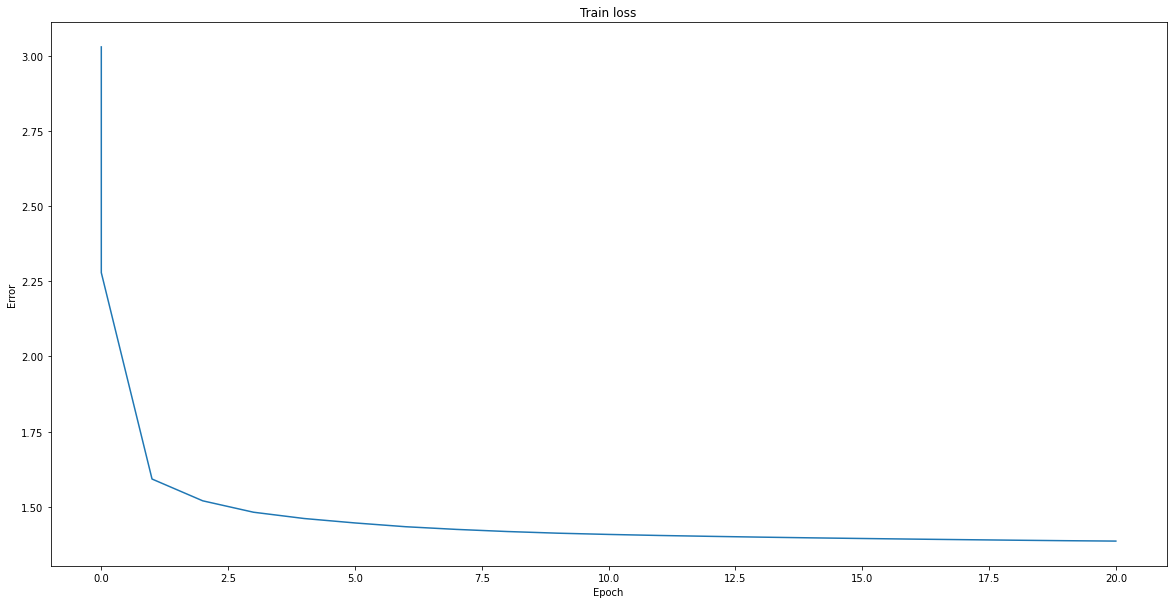

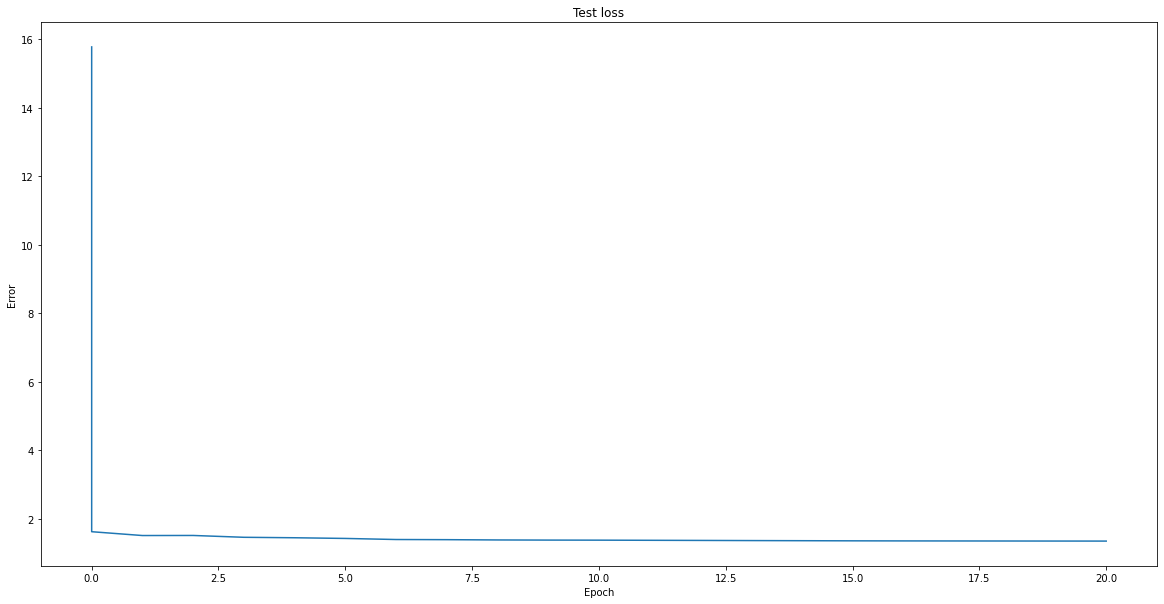

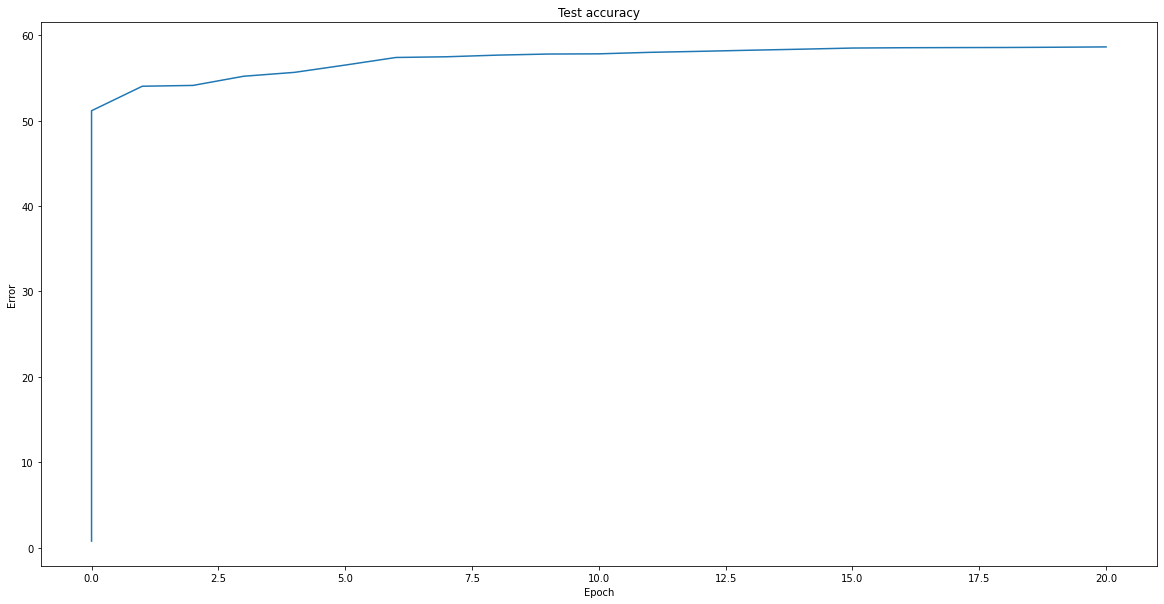

In [ ]:
def got_main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/got_log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'got_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'got_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'got_checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'got_checkpoints/%03d.pt' % epoch)
            seed_words = 'Most of the good guys died horrible, gruesome deaths. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'got_checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = got_main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Jon Snow and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Jon Snow and the stars of the stars of the stars of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of the stables of
generated with sample	 Jon Snow and the others were stranger than he had been strong to speak. “I would say he was all he is one east for here.” They would have been a few man as a black way the way rescent a man of his shadow, and when he
generated with sample	 Jon Snow and the sun was a tale of the children and his face. “I am not wear, and you say. She could have the food to see him. What was courtest the most of their throat and scart and masters and the pines of the rea
generated with sample	 Jon Snow and the fields were spittered the realm of the stars and stabled and here of her. The man was a wind she was the man of the wind seemed to find her dead and remembered the tears of their styward. When the di
generated with sample	 Jon Snow and the man

(2.9996681787786703, 1.71589196515162, 1.5810197127534218, 1.5228749257896599, 1.4903259721919648, 1.4707740391835127, 1.4566315436127162, 1.4449303543607, 1.4368805118126444, 1.4278332400243274, 1.4215148179837973, 1.4159814996687885, 1.4116040448544442, 1.408027504536972, 1.4047404047679586, 1.401718533078436, 1.398983871189281, 1.3966532784326635, 1.394160833689246, 1.3917372993903585, 1.389744726738127)
[20.07887322  5.56163408  4.859909    4.58538892  4.43854212  4.35260292
  4.29147949  4.24155673  4.20754992  4.16965476  4.14339217  4.12052878
  4.10253077  4.08788411  4.07446889  4.06217495  4.05108145  4.04165103
  4.03158998  4.02183111  4.0138253 ]


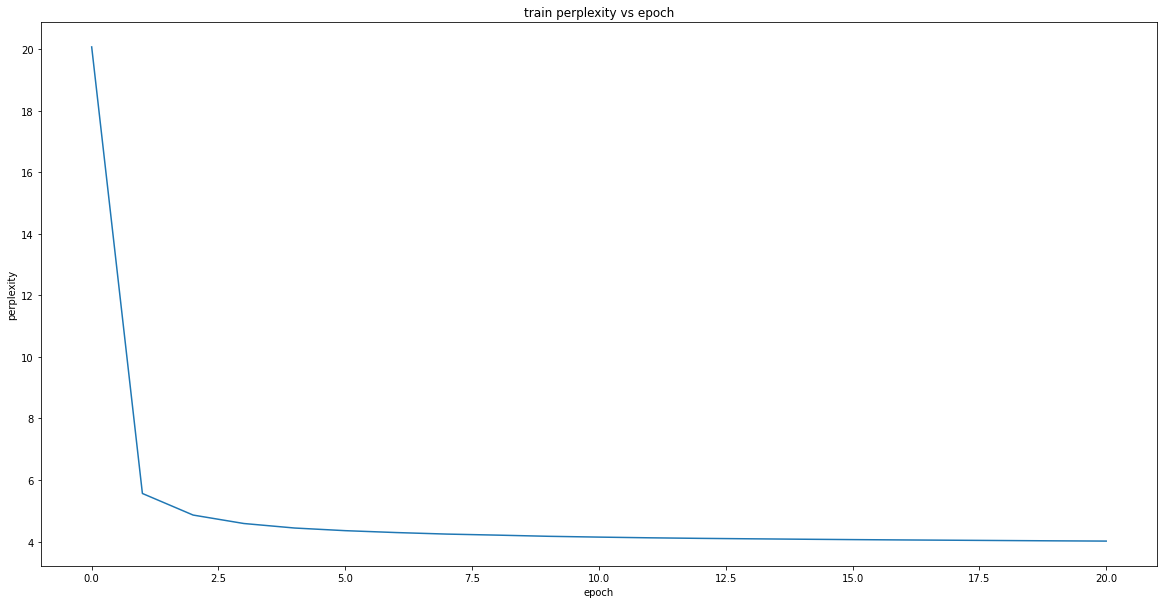

(14.866260290145874, 1.7853776216506958, 1.6660633965542442, 1.5708040422514866, 1.4862628500712545, 1.4597787872741097, 1.4467699825763702, 1.4327580379812341, 1.4096245985282094, 1.4036302033223604, 1.3984187857100838, 1.3897393565428884, 1.3843683898448944, 1.380632714221352, 1.3767872201768976, 1.373926238009804, 1.3696279196362746, 1.365589810045142, 1.3621083513686532, 1.3584886444242377, 1.3551930283245288, 1.3525093229193437)
[2.85979439e+06 5.96183084e+00 5.29129701e+00 4.81051450e+00
 4.42054437e+00 4.30500710e+00 4.24936680e+00 4.19024011e+00
 4.09441806e+00 4.06994792e+00 4.04879289e+00 4.01380374e+00
 3.99230353e+00 3.97741740e+00 3.96215164e+00 3.95083219e+00
 3.93388670e+00 3.91803327e+00 3.90441651e+00 3.89030922e+00
 3.87750935e+00 3.86711721e+00]


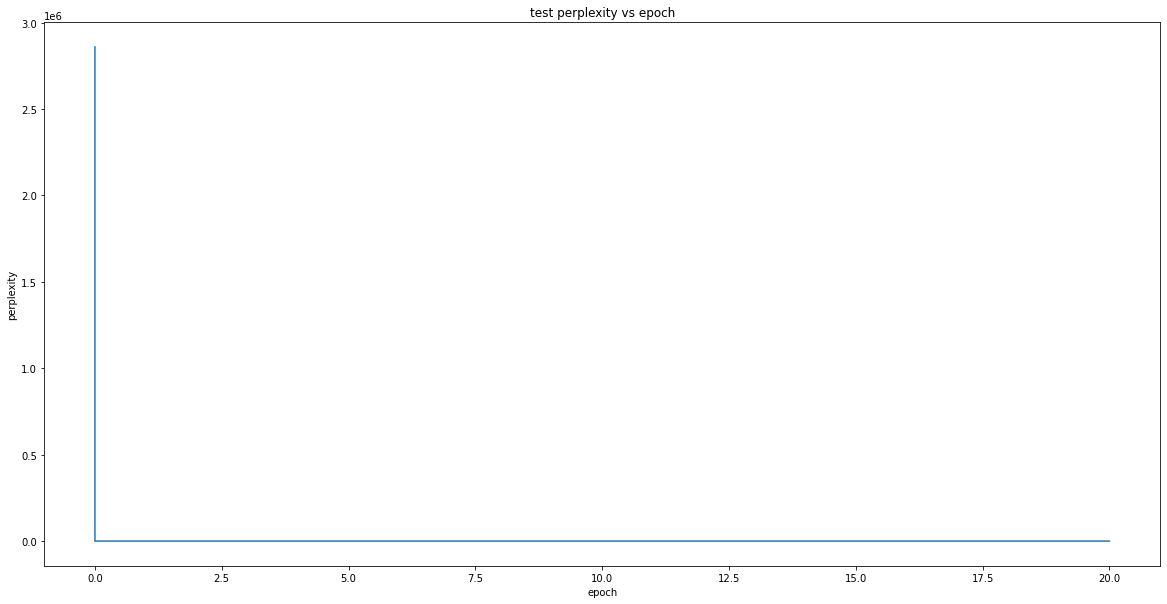

In [ ]:
LOG_PATH = DATA_PATH + 'logs/got_log.pkl'
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
train_epochs, train_perplexities = get_perplexities(train_losses)
pt_util.plot(train_epochs, train_perplexities, "train perplexity vs epoch", "epoch", "perplexity")
test_epochs, test_perplexities = get_perplexities(test_losses)
pt_util.plot(test_epochs, test_perplexities, "test perplexity vs epoch", "epoch", "perplexity")

#Experiment 2: Using LSTM instead of GRU

In [ ]:
TEMPERATURE = 0.5

class LSTMHarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LSTMHarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	OaF7/B?wY,,,v:,$a9/BV$$a`F:,,YRwKv6w4BK//Vafee.eYl'Y`3wF/BHAAAqAv6BY:,:YYl_HNiDw ruuqewY,ueqwY,,paaO


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uHHH6$YFv6wH_K__Y4B3/CwB{$aaO77qYv6.-/?a___K%($-s/BKBHHw,,)DYKv6w,42AY/_~:;//BFv_;wy,2./$aF~6w4`/K,r


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	,v6/,,,vB,$aa7,NNO,,v,,vKv6w3,DDb/PHVKKv6wa:7HwH,,,vwK7//sw,,aaHNHjMO?/_P`B`BHN6BvHHu,Ob/Y3_36$9waO7


Input	 hel

  1%|          | 1/195 [00:00<00:37,  5.23it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.246654


  7%|▋         | 13/195 [00:00<00:11, 15.68it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.415058


 12%|█▏        | 23/195 [00:01<00:10, 16.27it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.688579


 17%|█▋        | 33/195 [00:02<00:09, 16.31it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.283462


 22%|██▏       | 43/195 [00:02<00:09, 16.07it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.111756


 27%|██▋       | 53/195 [00:03<00:08, 16.44it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.011580


 32%|███▏      | 63/195 [00:03<00:08, 16.45it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.967108


 37%|███▋      | 73/195 [00:04<00:07, 16.53it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.911187


 43%|████▎     | 83/195 [00:05<00:06, 16.15it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.868468


 48%|████▊     | 93/195 [00:05<00:06, 15.10it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.851417


 53%|█████▎    | 103/195 [00:06<00:05, 16.40it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.815255


 58%|█████▊    | 113/195 [00:07<00:04, 16.40it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.789636


 63%|██████▎   | 123/195 [00:07<00:04, 16.56it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.786818


 68%|██████▊   | 133/195 [00:08<00:03, 16.14it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.769085


 73%|███████▎  | 143/195 [00:08<00:03, 16.58it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.759364


 78%|███████▊  | 153/195 [00:09<00:02, 15.89it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.726197


 84%|████████▎ | 163/195 [00:10<00:01, 16.51it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.706030


 89%|████████▊ | 173/195 [00:10<00:01, 16.49it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.697021


 94%|█████████▍| 183/195 [00:11<00:00, 16.23it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.664816


 99%|█████████▉| 193/195 [00:11<00:00, 16.22it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.662134


100%|██████████| 195/195 [00:12<00:00, 16.11it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreathteghttnd teasdd tnain   the sane  etasl  "I wnetarre .  "e said  "Ion't tardi  whdc  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the sft r tone  and tarry sa p d aumbledore teck an o the snk waem ye  thet tonl d ahe saoaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd teenpeng tn the sesdee tf the soyk aashttnaaam ot tagw e te  "ir tf  tauriele terent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.86it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.671545


  7%|▋         | 13/195 [00:00<00:11, 15.86it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.665657


 12%|█▏        | 23/195 [00:01<00:10, 16.51it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.642645


 17%|█▋        | 33/195 [00:02<00:09, 16.24it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.645410


 22%|██▏       | 43/195 [00:02<00:09, 15.97it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.627485


 27%|██▋       | 53/195 [00:03<00:08, 16.15it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.601636


 32%|███▏      | 63/195 [00:03<00:08, 16.32it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.602732


 37%|███▋      | 73/195 [00:04<00:07, 16.40it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.590734


 43%|████▎     | 83/195 [00:05<00:06, 16.03it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.567503


 48%|████▊     | 93/195 [00:05<00:06, 16.06it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.577569


 53%|█████▎    | 103/195 [00:06<00:05, 16.05it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.569571


 58%|█████▊    | 113/195 [00:07<00:05, 16.33it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.552927


 63%|██████▎   | 123/195 [00:07<00:04, 15.94it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.556045


 68%|██████▊   | 133/195 [00:08<00:03, 15.74it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.564164


 73%|███████▎  | 143/195 [00:08<00:03, 16.05it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.566322


 78%|███████▊  | 153/195 [00:09<00:02, 16.01it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.548428


 84%|████████▎ | 163/195 [00:10<00:01, 16.14it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.524035


 89%|████████▊ | 173/195 [00:10<00:01, 15.99it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.520779


 94%|█████████▍| 183/195 [00:11<00:00, 15.93it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.502255


 99%|█████████▉| 193/195 [00:12<00:00, 16.33it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.513070


100%|██████████| 195/195 [00:12<00:00, 16.00it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat todnttnd totvtd tnain,t the some  otasl  "I wneahrri .  "e said  "Ion't tauky  wtdt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d the snt   tone  tnd sarry saap d aumbledore aeck tn o the snk tiet,ye  thet tonl d aoe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng ttd seenpeng tn the sondle of the soyk aashttnuuemetn tagwmeate  "ir af  tewrible aerent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.77it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.526321


  7%|▋         | 13/195 [00:00<00:11, 15.28it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.518638


 12%|█▏        | 23/195 [00:01<00:10, 16.28it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.506399


 17%|█▋        | 33/195 [00:02<00:09, 16.25it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.511358


 22%|██▏       | 43/195 [00:02<00:09, 15.81it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.509384


 27%|██▋       | 53/195 [00:03<00:08, 16.25it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.493514


 32%|███▏      | 63/195 [00:03<00:08, 16.25it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.498007


 37%|███▋      | 73/195 [00:04<00:07, 16.18it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.496757


 43%|████▎     | 83/195 [00:05<00:06, 16.36it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.472117


 48%|████▊     | 93/195 [00:05<00:06, 15.99it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.482389


 53%|█████▎    | 103/195 [00:06<00:05, 16.35it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.485252


 58%|█████▊    | 113/195 [00:07<00:05, 16.08it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.466668


 63%|██████▎   | 123/195 [00:07<00:04, 16.18it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.472004


 68%|██████▊   | 133/195 [00:08<00:03, 16.15it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.484620


 73%|███████▎  | 143/195 [00:08<00:03, 15.93it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.477932


 78%|███████▊  | 153/195 [00:09<00:02, 16.62it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.465755


 84%|████████▎ | 163/195 [00:10<00:02, 15.93it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.459170


 89%|████████▊ | 173/195 [00:10<00:01, 16.22it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.447648


 94%|█████████▍| 183/195 [00:11<00:00, 16.18it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.437252


 99%|█████████▉| 193/195 [00:12<00:00, 16.15it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.457546


100%|██████████| 195/195 [00:12<00:00, 16.04it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat aidnttnd soaned tnain.t the same  aaask  "I tn ahrr  .  "e said  "Ion't wauky  tid.  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the snt   oane  and sarry saap d aumbledore aeck tn o the snk wier,ye  ahat honl d ahe saoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and seenpeng an the fondle of the sork aash anoiet,an tagwmeade  "ir af  oawrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:29,  6.47it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.462332


  7%|▋         | 13/195 [00:00<00:11, 15.82it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.453668


 12%|█▏        | 23/195 [00:01<00:10, 16.14it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.443256


 17%|█▋        | 33/195 [00:02<00:09, 16.33it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.454837


 22%|██▏       | 43/195 [00:02<00:09, 16.51it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.444926


 27%|██▋       | 53/195 [00:03<00:08, 16.46it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.436322


 32%|███▏      | 63/195 [00:03<00:08, 16.30it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.438487


 37%|███▋      | 73/195 [00:04<00:07, 16.00it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.434398


 43%|████▎     | 83/195 [00:05<00:06, 16.16it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.417907


 48%|████▊     | 93/195 [00:05<00:06, 16.12it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.429759


 53%|█████▎    | 103/195 [00:06<00:05, 16.02it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.439168


 58%|█████▊    | 113/195 [00:07<00:05, 15.77it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.434552


 63%|██████▎   | 123/195 [00:07<00:04, 15.80it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.445931


 68%|██████▊   | 133/195 [00:08<00:03, 15.96it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.451179


 73%|███████▎  | 143/195 [00:08<00:03, 15.97it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.438426


 78%|███████▊  | 153/195 [00:09<00:02, 16.22it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.422182


 84%|████████▎ | 163/195 [00:10<00:01, 16.23it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.414211


 89%|████████▊ | 173/195 [00:10<00:01, 16.33it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.408781


 94%|█████████▍| 183/195 [00:11<00:00, 16.23it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.398745


 99%|█████████▉| 193/195 [00:12<00:00, 16.41it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.415179


100%|██████████| 195/195 [00:12<00:00, 16.01it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat aodnttnd soaded anain,t the sare  aaask  "I ts aarr  .  "e said  "Iun't warry "tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the stt   oare  and sarry saad d aumbledore aeck tn o the snk aternyed ahat torl d ohe saoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and seanpeng hn the soddle of the serk aash anuietean tagwmeade  "ir af  oewrible aorent aarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.85it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.426548


  7%|▋         | 13/195 [00:00<00:11, 15.83it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.422021


 12%|█▏        | 23/195 [00:01<00:10, 16.09it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.419965


 17%|█▋        | 33/195 [00:02<00:10, 15.95it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.421938


 22%|██▏       | 43/195 [00:02<00:09, 16.10it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.413301


 27%|██▋       | 53/195 [00:03<00:08, 16.27it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.396188


 32%|███▏      | 63/195 [00:03<00:07, 16.60it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.417050


 37%|███▋      | 73/195 [00:04<00:07, 16.25it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.409943


 43%|████▎     | 83/195 [00:05<00:06, 16.43it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.402344


 48%|████▊     | 93/195 [00:05<00:06, 16.41it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.406126


 53%|█████▎    | 103/195 [00:06<00:05, 15.82it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.410854


 58%|█████▊    | 113/195 [00:07<00:04, 16.44it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.392471


 63%|██████▎   | 123/195 [00:07<00:04, 16.02it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.405377


 68%|██████▊   | 133/195 [00:08<00:03, 16.34it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.420088


 73%|███████▎  | 143/195 [00:08<00:03, 16.07it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.412581


 78%|███████▊  | 153/195 [00:09<00:02, 16.00it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.404347


 84%|████████▎ | 163/195 [00:10<00:02, 16.00it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.406906


 89%|████████▊ | 173/195 [00:10<00:01, 16.27it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.384392


 94%|█████████▍| 183/195 [00:11<00:00, 16.32it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.378134


 99%|█████████▉| 193/195 [00:11<00:00, 16.32it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.390799


100%|██████████| 195/195 [00:12<00:00, 16.07it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sidnttnd soaned ttain,t the sare  aaask  "I sn sarrn .  "e said  "Iun't wanry  Iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the stt   oare  and sarry saaded aumbledore aeck tnto the snk aternyed ahat torl d ohe saoaeei


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and sianpeng tn the soddle of the sork aash anuie  an tagwmeade  "ir af  wiwrible aorent aarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.73it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.412825


  7%|▋         | 13/195 [00:00<00:11, 15.40it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.411977


 12%|█▏        | 23/195 [00:01<00:10, 16.20it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.399837


 17%|█▋        | 33/195 [00:02<00:10, 15.89it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.401264


 22%|██▏       | 43/195 [00:02<00:09, 16.23it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.397919


 27%|██▋       | 53/195 [00:03<00:08, 16.02it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.387974


 32%|███▏      | 63/195 [00:03<00:08, 16.49it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.393883


 37%|███▋      | 73/195 [00:04<00:07, 16.30it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.389229


 43%|████▎     | 83/195 [00:05<00:06, 16.28it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.374345


 48%|████▊     | 93/195 [00:05<00:06, 16.20it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.392240


 53%|█████▎    | 103/195 [00:06<00:05, 15.58it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.401834


 58%|█████▊    | 113/195 [00:07<00:05, 15.67it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.448594


 63%|██████▎   | 123/195 [00:07<00:04, 15.78it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.406993


 68%|██████▊   | 133/195 [00:08<00:03, 16.08it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.412059


 73%|███████▎  | 143/195 [00:08<00:03, 15.55it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.397036


 78%|███████▊  | 153/195 [00:09<00:02, 16.03it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.385923


 84%|████████▎ | 163/195 [00:10<00:01, 16.17it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.381558


 89%|████████▊ | 173/195 [00:10<00:01, 16.10it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.370232


 94%|█████████▍| 183/195 [00:11<00:00, 16.18it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.374613


 99%|█████████▉| 193/195 [00:12<00:00, 16.04it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.385804


100%|██████████| 195/195 [00:12<00:00, 15.93it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sednttnd soaded ttain,t the sase  aaisk  "I wn serrn..  "e said  "Iun't warry  Iod," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt r tarer and sarry saaded tumbledore aeck tnto the snk atet,yed ahat torlyd hhe saoaeei


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring tnd seenpeng hn the soddle of the serk aagh tnuietsan tagsmeade  "ir af  wewrible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.92it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.396543


  7%|▋         | 13/195 [00:00<00:11, 15.67it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.407078


 12%|█▏        | 23/195 [00:01<00:10, 15.98it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.382745


 17%|█▋        | 33/195 [00:02<00:09, 16.50it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.398660


 22%|██▏       | 43/195 [00:02<00:09, 16.14it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.382959


 27%|██▋       | 53/195 [00:03<00:08, 16.34it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.371017


 32%|███▏      | 63/195 [00:03<00:08, 16.17it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.384798


 37%|███▋      | 73/195 [00:04<00:07, 16.42it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.378376


 43%|████▎     | 83/195 [00:05<00:06, 16.53it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.386227


 48%|████▊     | 93/195 [00:05<00:06, 16.48it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.388124


 53%|█████▎    | 103/195 [00:06<00:05, 16.16it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.386970


 58%|█████▊    | 113/195 [00:07<00:05, 16.12it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.373811


 63%|██████▎   | 123/195 [00:07<00:04, 16.14it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.384186


 68%|██████▊   | 133/195 [00:08<00:03, 16.38it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.411086


 73%|███████▎  | 143/195 [00:08<00:03, 16.09it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.391546


 78%|███████▊  | 153/195 [00:09<00:02, 16.30it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.387131


 84%|████████▎ | 163/195 [00:10<00:01, 16.08it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.371336


 89%|████████▊ | 173/195 [00:10<00:01, 16.18it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.362983


 94%|█████████▍| 183/195 [00:11<00:00, 16.41it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.362482


 99%|█████████▉| 193/195 [00:11<00:00, 16.39it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.379727


100%|██████████| 195/195 [00:12<00:00, 16.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sedntand soaned atain,t the saser aaisk  "I sn serrn..  "e said  "Iun't warry  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r tarer and serry saaded aumbledore aeck tnto the cnr atet,yer,ahat horlyd hhe saoaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring snd seenpeng hn the coddle of the serk aagh wnuie san tagsmeade  "ir af  weurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.83it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.395913


  7%|▋         | 13/195 [00:00<00:11, 15.54it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.393563


 12%|█▏        | 23/195 [00:01<00:10, 15.70it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.376654


 17%|█▋        | 33/195 [00:02<00:10, 15.90it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.384949


 22%|██▏       | 43/195 [00:02<00:09, 15.69it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.378381


 27%|██▋       | 53/195 [00:03<00:08, 16.09it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.371347


 32%|███▏      | 63/195 [00:04<00:08, 16.19it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.381696


 37%|███▋      | 73/195 [00:04<00:07, 16.38it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.370240


 43%|████▎     | 83/195 [00:05<00:07, 15.74it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.368177


 48%|████▊     | 93/195 [00:05<00:06, 16.36it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.379957


 53%|█████▎    | 103/195 [00:06<00:05, 16.35it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.383563


 58%|█████▊    | 113/195 [00:07<00:05, 16.05it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.365627


 63%|██████▎   | 123/195 [00:07<00:04, 16.14it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.371615


 68%|██████▊   | 133/195 [00:08<00:03, 16.23it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.386622


 73%|███████▎  | 143/195 [00:08<00:03, 16.30it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.381796


 78%|███████▊  | 153/195 [00:09<00:02, 16.16it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.377554


 84%|████████▎ | 163/195 [00:10<00:02, 15.92it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.368749


 89%|████████▊ | 173/195 [00:10<00:01, 15.98it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.364822


 94%|█████████▍| 183/195 [00:11<00:00, 16.13it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.355168


 99%|█████████▉| 193/195 [00:12<00:00, 16.29it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.370463


100%|██████████| 195/195 [00:12<00:00, 15.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soanid tnain,t the corer aaisk  "I wm sorrn..  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r torer and sarry saaded humbledore aeck tnto the cnr otar,rer ahat horl d hhe cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring hnd sianpeng hn the coddle of the cork aagh wnuie  an tagsmeade  "ir af  weurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.75it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.384233


  7%|▋         | 13/195 [00:00<00:11, 15.60it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.376910


 12%|█▏        | 23/195 [00:01<00:10, 16.44it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.376406


 17%|█▋        | 33/195 [00:02<00:09, 16.49it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.395800


 22%|██▏       | 43/195 [00:02<00:09, 16.34it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.408724


 27%|██▋       | 53/195 [00:03<00:08, 16.21it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.374700


 32%|███▏      | 63/195 [00:03<00:08, 16.02it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.375858


 37%|███▋      | 73/195 [00:04<00:07, 16.40it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.364854


 43%|████▎     | 83/195 [00:05<00:07, 15.95it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.357768


 48%|████▊     | 93/195 [00:05<00:06, 16.21it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.367577


 53%|█████▎    | 103/195 [00:06<00:05, 15.84it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.375209


 58%|█████▊    | 113/195 [00:07<00:05, 16.23it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.371011


 63%|██████▎   | 123/195 [00:07<00:04, 16.17it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.373841


 68%|██████▊   | 133/195 [00:08<00:03, 16.05it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.376728


 73%|███████▎  | 143/195 [00:08<00:03, 16.08it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.378325


 78%|███████▊  | 153/195 [00:09<00:02, 16.27it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.371715


 84%|████████▎ | 163/195 [00:10<00:01, 16.01it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.352986


 89%|████████▊ | 173/195 [00:10<00:01, 15.88it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.351515


 94%|█████████▍| 183/195 [00:11<00:00, 16.17it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.345058


 99%|█████████▉| 193/195 [00:12<00:00, 16.34it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.362171


100%|██████████| 195/195 [00:12<00:00, 16.01it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet stlntond soanid atain,t the corer oaink  "I wm serrn..  "e said, "Wun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r torer and sarry saaded humbledore aeck tnto the cnr otar,rer ahat horl d the cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sianping hntahe caddle of the cork aagh anueet anttagsmeade  "ir tf  weurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:27,  7.12it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.377020


  7%|▋         | 13/195 [00:00<00:11, 15.71it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.374866


 12%|█▏        | 23/195 [00:01<00:10, 16.14it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.367874


 17%|█▋        | 33/195 [00:02<00:10, 16.17it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.382570


 22%|██▏       | 43/195 [00:02<00:09, 15.96it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.396909


 27%|██▋       | 53/195 [00:03<00:08, 15.97it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.360848


 32%|███▏      | 63/195 [00:03<00:08, 15.84it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.367800


 37%|███▋      | 73/195 [00:04<00:07, 15.92it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.356994


 43%|████▎     | 83/195 [00:05<00:07, 15.80it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.353041


 48%|████▊     | 93/195 [00:05<00:06, 15.42it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.366523


 53%|█████▎    | 103/195 [00:06<00:05, 15.85it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.368960


 58%|█████▊    | 113/195 [00:07<00:05, 16.36it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.352656


 63%|██████▎   | 123/195 [00:07<00:04, 16.16it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.364196


 68%|██████▊   | 133/195 [00:08<00:03, 16.34it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.376078


 73%|███████▎  | 143/195 [00:08<00:03, 16.15it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.384579


 78%|███████▊  | 153/195 [00:09<00:02, 16.29it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.369631


 84%|████████▎ | 163/195 [00:10<00:01, 16.42it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.357227


 89%|████████▊ | 173/195 [00:10<00:01, 16.57it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.346560


 94%|█████████▍| 183/195 [00:11<00:00, 16.28it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.339509


 99%|█████████▉| 193/195 [00:12<00:00, 16.64it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.358585


100%|██████████| 195/195 [00:12<00:00, 16.01it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet stlntond soavtd atain,t the core. oainl  "I wn serrn .  "e said, "Wun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r oore  and Harry saaded humbledore aeck tnto the cnk otar rer ahat horl d the cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sianping hnthhe coddle of the cork sagh fnueet an tagsmeade  "ir tfe weurible sorent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:29,  6.60it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.373253


  7%|▋         | 13/195 [00:00<00:11, 15.57it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.370089


 12%|█▏        | 23/195 [00:01<00:10, 15.97it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.359946


 17%|█▋        | 33/195 [00:02<00:10, 16.12it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.375558


 22%|██▏       | 43/195 [00:02<00:09, 16.24it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.373738


 27%|██▋       | 53/195 [00:03<00:08, 16.27it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.353565


 32%|███▏      | 63/195 [00:04<00:08, 15.78it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.361685


 37%|███▋      | 73/195 [00:04<00:07, 16.12it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.350302


 43%|████▎     | 83/195 [00:05<00:06, 16.22it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.343701


 48%|████▊     | 93/195 [00:05<00:06, 15.79it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.355632


 53%|█████▎    | 103/195 [00:06<00:05, 16.11it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.358911


 58%|█████▊    | 113/195 [00:07<00:05, 16.21it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.341399


 63%|██████▎   | 123/195 [00:07<00:04, 16.28it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.356511


 68%|██████▊   | 133/195 [00:08<00:03, 16.23it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.378686


 73%|███████▎  | 143/195 [00:08<00:03, 15.97it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.372464


 78%|███████▊  | 153/195 [00:09<00:02, 16.28it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.367407


 84%|████████▎ | 163/195 [00:10<00:01, 16.43it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.358401


 89%|████████▊ | 173/195 [00:10<00:01, 16.28it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.349922


 94%|█████████▍| 183/195 [00:11<00:00, 16.49it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.340944


 99%|█████████▉| 193/195 [00:12<00:00, 16.57it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.350775


100%|██████████| 195/195 [00:12<00:00, 16.01it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet stlntond soavtd atain.t the core.,oainl  "I wm serrn..  "e said, "Wun't warry, tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r oore  and Harry saaded humbledore aeck tnto the cnh oter.rer,ahat horl d the cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nireng and seanpeng hnthhe coddle of the cork aaghtfnueet an tagwmeade  "or tne oeurible sorent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:30,  6.36it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.367293


  7%|▋         | 13/195 [00:00<00:11, 15.46it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.362377


 12%|█▏        | 23/195 [00:01<00:10, 15.71it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.354774


 17%|█▋        | 33/195 [00:02<00:09, 16.41it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.369286


 22%|██▏       | 43/195 [00:02<00:09, 16.07it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.365900


 27%|██▋       | 53/195 [00:03<00:09, 15.64it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.348684


 32%|███▏      | 63/195 [00:04<00:08, 16.08it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.359420


 37%|███▋      | 73/195 [00:04<00:07, 16.45it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.348094


 43%|████▎     | 83/195 [00:05<00:06, 16.27it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.339343


 48%|████▊     | 93/195 [00:05<00:06, 16.29it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.350688


 53%|█████▎    | 103/195 [00:06<00:05, 16.14it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.353186


 58%|█████▊    | 113/195 [00:07<00:05, 15.56it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.337892


 63%|██████▎   | 123/195 [00:07<00:04, 15.77it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.351110


 68%|██████▊   | 133/195 [00:08<00:03, 15.83it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.376522


 73%|███████▎  | 143/195 [00:09<00:03, 15.84it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.362639


 78%|███████▊  | 153/195 [00:09<00:02, 16.02it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.361382


 84%|████████▎ | 163/195 [00:10<00:01, 16.53it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.339106


 89%|████████▊ | 173/195 [00:10<00:01, 16.14it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.334358


 94%|█████████▍| 183/195 [00:11<00:00, 15.78it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.331912


 99%|█████████▉| 193/195 [00:12<00:00, 16.22it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.348284


100%|██████████| 195/195 [00:12<00:00, 15.91it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet stlntond soavtd atain,t the core. oaitl  "I wm sarrn .  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt r oore  and Harry saaded humbledore teck tnto the cnk otet rer ahat horl d the cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and saanpeng hn the caddle of the cark saghtwnuaet an tagwmeade  "or tne oaurible sorent warr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:29,  6.48it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.365199


  7%|▋         | 13/195 [00:00<00:11, 15.49it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.361131


 12%|█▏        | 23/195 [00:01<00:10, 15.92it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.354537


 17%|█▋        | 33/195 [00:02<00:09, 16.34it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.361692


 22%|██▏       | 43/195 [00:02<00:09, 16.24it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.356946


 27%|██▋       | 53/195 [00:03<00:08, 16.31it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.342063


 32%|███▏      | 63/195 [00:03<00:08, 16.22it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.349853


 37%|███▋      | 73/195 [00:04<00:07, 16.20it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.343368


 43%|████▎     | 83/195 [00:05<00:06, 16.11it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.335490


 48%|████▊     | 93/195 [00:05<00:06, 15.74it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.343685


 53%|█████▎    | 103/195 [00:06<00:05, 15.90it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.352407


 58%|█████▊    | 113/195 [00:07<00:05, 16.31it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.336182


 63%|██████▎   | 123/195 [00:07<00:04, 16.31it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.352381


 68%|██████▊   | 133/195 [00:08<00:03, 16.35it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.363510


 73%|███████▎  | 143/195 [00:08<00:03, 16.49it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.354630


 78%|███████▊  | 153/195 [00:09<00:02, 15.73it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.352441


 84%|████████▎ | 163/195 [00:10<00:01, 16.04it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.331267


 89%|████████▊ | 173/195 [00:10<00:01, 16.08it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.339381


 94%|█████████▍| 183/195 [00:11<00:00, 16.16it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.330254


 99%|█████████▉| 193/195 [00:12<00:00, 16.40it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.342297


100%|██████████| 195/195 [00:12<00:00, 15.98it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet stlntond soavtd atain.t the core. eainl  "I wm serrn .  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r oore  and Harry saaded humbledore teck tnto the cnk otet.rer aoat torled the cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nireng and seanpeng hn the caddle of the cork aaghttnueet an tagwmeade  "or tne oeurible sorent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:30,  6.31it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.361451


  7%|▋         | 13/195 [00:00<00:11, 15.31it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.353878


 12%|█▏        | 23/195 [00:01<00:10, 15.85it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.348172


 17%|█▋        | 33/195 [00:02<00:10, 15.90it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.360053


 22%|██▏       | 43/195 [00:02<00:09, 16.37it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.355101


 27%|██▋       | 53/195 [00:03<00:08, 16.05it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.345857


 32%|███▏      | 63/195 [00:04<00:08, 16.19it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.348346


 37%|███▋      | 73/195 [00:04<00:07, 16.15it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.340105


 43%|████▎     | 83/195 [00:05<00:07, 16.00it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.332016


 48%|████▊     | 93/195 [00:05<00:06, 16.14it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.337406


 53%|█████▎    | 103/195 [00:06<00:05, 16.29it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.344693


 58%|█████▊    | 113/195 [00:07<00:05, 16.32it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.331996


 63%|██████▎   | 123/195 [00:07<00:04, 16.03it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.344840


 68%|██████▊   | 133/195 [00:08<00:03, 16.17it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.360860


 73%|███████▎  | 143/195 [00:08<00:03, 16.11it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.350977


 78%|███████▊  | 153/195 [00:09<00:02, 16.25it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.351772


 84%|████████▎ | 163/195 [00:10<00:01, 16.45it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.334980


 89%|████████▊ | 173/195 [00:10<00:01, 15.55it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.327806


 94%|█████████▍| 183/195 [00:11<00:00, 15.89it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.326801


 99%|█████████▉| 193/195 [00:12<00:00, 15.95it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.340473


100%|██████████| 195/195 [00:12<00:00, 15.92it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soavtd atain,t the core. eainl, "I wm salrn .  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r oore  and tarry saaded humbledore teck tn o the cnk otet.rer aoat horled the cooael 


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng atd soanpeng hn the caddle of the cork aaghtfnueet an tagwmeade  "or tn  oeurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:29,  6.68it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.360751


  7%|▋         | 13/195 [00:00<00:11, 15.62it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.353837


 12%|█▏        | 23/195 [00:01<00:10, 16.12it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.349170


 17%|█▋        | 33/195 [00:02<00:10, 16.07it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.354803


 22%|██▏       | 43/195 [00:02<00:09, 16.11it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.344641


 27%|██▋       | 53/195 [00:03<00:08, 16.28it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.330257


 32%|███▏      | 63/195 [00:03<00:07, 16.51it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.351794


 37%|███▋      | 73/195 [00:04<00:07, 15.80it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.341045


 43%|████▎     | 83/195 [00:05<00:07, 15.94it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.335221


 48%|████▊     | 93/195 [00:05<00:06, 16.05it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.334332


 53%|█████▎    | 103/195 [00:06<00:05, 16.17it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.346677


 58%|█████▊    | 113/195 [00:07<00:05, 16.30it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.323082


 63%|██████▎   | 123/195 [00:07<00:04, 16.48it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.343874


 68%|██████▊   | 133/195 [00:08<00:03, 16.39it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.356277


 73%|███████▎  | 143/195 [00:08<00:03, 16.12it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.346648


 78%|███████▊  | 153/195 [00:09<00:02, 16.25it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.341533


 84%|████████▎ | 163/195 [00:10<00:01, 16.09it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.325524


 89%|████████▊ | 173/195 [00:10<00:01, 15.53it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.321140


 94%|█████████▍| 183/195 [00:11<00:00, 15.77it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.329192


 99%|█████████▉| 193/195 [00:12<00:00, 16.16it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.340479


100%|██████████| 195/195 [00:12<00:00, 15.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreet sulntond soavtd atain,t the core  oainl  "I wm aalrn .  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the ctt r oore  and Harry saaded humbledore aeck tn o the cnk otet.rer ahet torled the cooaeli


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng atd seanpeng hn the caddle of the cork aaghtanueet an tagwmeade  "or tu  oeurible sarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:27,  7.10it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.357355


  7%|▋         | 13/195 [00:00<00:11, 15.75it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.349136


 12%|█▏        | 23/195 [00:01<00:10, 16.27it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.340892


 17%|█▋        | 33/195 [00:02<00:10, 16.09it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.350881


 22%|██▏       | 43/195 [00:02<00:09, 15.88it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.344201


 27%|██▋       | 53/195 [00:03<00:08, 16.10it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.330959


 32%|███▏      | 63/195 [00:04<00:08, 16.05it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.343730


 37%|███▋      | 73/195 [00:04<00:07, 16.32it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.339481


 43%|████▎     | 83/195 [00:05<00:06, 16.47it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.326494


 48%|████▊     | 93/195 [00:05<00:06, 16.24it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.333068


 53%|█████▎    | 103/195 [00:06<00:05, 16.43it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.350451


 58%|█████▊    | 113/195 [00:07<00:05, 16.32it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.325848


 63%|██████▎   | 123/195 [00:07<00:04, 16.44it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.348452


 68%|██████▊   | 133/195 [00:08<00:03, 16.46it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.353112


 73%|███████▎  | 143/195 [00:08<00:03, 16.43it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.345973


 78%|███████▊  | 153/195 [00:09<00:02, 16.15it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.343029


 84%|████████▎ | 163/195 [00:10<00:02, 15.90it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.322551


 89%|████████▊ | 173/195 [00:10<00:01, 16.07it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.318004


 94%|█████████▍| 183/195 [00:11<00:00, 15.86it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.316687


 99%|█████████▉| 193/195 [00:12<00:00, 16.15it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.333532


100%|██████████| 195/195 [00:12<00:00, 16.04it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soavtd atain,t the cose  eaanl  "I wm aalrn .  "e said  "Ion't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt r oore  and Harry saaded humbledore aeck tnto the cnk otet ner ahat horled the cooael 


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and saanpeng hn the caddle of the cark aaghtanueet an tagwmeade  "or tn  oaurible sauent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:28,  6.78it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.356257


  7%|▋         | 13/195 [00:00<00:11, 15.47it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.346290


 12%|█▏        | 23/195 [00:01<00:10, 16.16it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.341983


 17%|█▋        | 33/195 [00:02<00:10, 16.01it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.345379


 22%|██▏       | 43/195 [00:02<00:09, 16.23it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.340413


 27%|██▋       | 53/195 [00:03<00:08, 16.36it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.325744


 32%|███▏      | 63/195 [00:03<00:08, 16.40it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.335550


 37%|███▋      | 73/195 [00:04<00:07, 16.30it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.331376


 43%|████▎     | 83/195 [00:05<00:06, 16.00it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.321206


 48%|████▊     | 93/195 [00:05<00:06, 16.35it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.331701


 53%|█████▎    | 103/195 [00:06<00:05, 16.17it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.342222


 58%|█████▊    | 113/195 [00:07<00:05, 15.91it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.327069


 63%|██████▎   | 123/195 [00:07<00:04, 16.07it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.348050


 68%|██████▊   | 133/195 [00:08<00:03, 15.94it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.350773


 73%|███████▎  | 143/195 [00:08<00:03, 15.38it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.343232


 78%|███████▊  | 153/195 [00:09<00:02, 16.33it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.341026


 84%|████████▎ | 163/195 [00:10<00:01, 16.52it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.317877


 89%|████████▊ | 173/195 [00:10<00:01, 16.21it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.312424


 94%|█████████▍| 183/195 [00:11<00:00, 16.40it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.319057


 99%|█████████▉| 193/195 [00:12<00:00, 16.50it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.332921


100%|██████████| 195/195 [00:12<00:00, 16.03it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soavtd atain,t the cose  oaanl  "I wm aalrn .  "e said  "Ion't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt n oore  and Harry saaded humbledore weck tnto the cnk otet.ne  ahat horled the cooael 


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and saanpeng hn the caddle of the cark aaghtanueet an tagwmeade  "or tu  oaurible sauent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:27,  6.94it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.352325


  7%|▋         | 13/195 [00:00<00:11, 15.67it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.343705


 12%|█▏        | 23/195 [00:01<00:10, 16.15it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.338278


 17%|█▋        | 33/195 [00:02<00:10, 16.04it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.343185


 22%|██▏       | 43/195 [00:02<00:09, 15.69it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.334864


 27%|██▋       | 53/195 [00:03<00:09, 15.74it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.319685


 32%|███▏      | 63/195 [00:04<00:08, 16.03it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.333006


 37%|███▋      | 73/195 [00:04<00:07, 16.42it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.330219


 43%|████▎     | 83/195 [00:05<00:06, 16.37it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.318179


 48%|████▊     | 93/195 [00:05<00:06, 15.87it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.328209


 53%|█████▎    | 103/195 [00:06<00:05, 15.94it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.334766


 58%|█████▊    | 113/195 [00:07<00:05, 15.41it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.324254


 63%|██████▎   | 123/195 [00:07<00:04, 15.88it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.334980


 68%|██████▊   | 133/195 [00:08<00:03, 16.43it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.360244


 73%|███████▎  | 143/195 [00:09<00:03, 16.20it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.341926


 78%|███████▊  | 153/195 [00:09<00:02, 16.45it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.336797


 84%|████████▎ | 163/195 [00:10<00:01, 16.53it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.319721


 89%|████████▊ | 173/195 [00:10<00:01, 16.14it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.307547


 94%|█████████▍| 183/195 [00:11<00:00, 16.24it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.315211


 99%|█████████▉| 193/195 [00:12<00:00, 16.01it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.328949


100%|██████████| 195/195 [00:12<00:00, 15.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soavtd atain.t the case  aainl  "I wm salrn .  "e said  "Iun't warry  tar," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt r oare  and Harry saaded humbledore aeck an o the cnk otet ne  ahat horled the caaael 


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd seanpeng hn ahe caddle of the cark aagh anueet an tagwmeade  "or tu  oeurible sauent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:30,  6.32it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.353607


  7%|▋         | 13/195 [00:00<00:12, 15.16it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.341314


 12%|█▏        | 23/195 [00:01<00:10, 15.88it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.339069


 17%|█▋        | 33/195 [00:02<00:10, 16.06it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.342411


 22%|██▏       | 43/195 [00:02<00:09, 16.34it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.332058


 27%|██▋       | 53/195 [00:03<00:08, 16.06it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.315121


 32%|███▏      | 63/195 [00:04<00:08, 16.05it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.330922


 37%|███▋      | 73/195 [00:04<00:07, 15.78it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.328060


 43%|████▎     | 83/195 [00:05<00:06, 16.12it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.322397


 48%|████▊     | 93/195 [00:05<00:06, 15.79it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.324375


 53%|█████▎    | 103/195 [00:06<00:05, 16.13it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.336565


 58%|█████▊    | 113/195 [00:07<00:05, 16.27it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.320906


 63%|██████▎   | 123/195 [00:07<00:04, 15.52it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.336071


 68%|██████▊   | 133/195 [00:08<00:03, 15.97it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.346187


 73%|███████▎  | 143/195 [00:09<00:03, 15.91it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.338033


 78%|███████▊  | 153/195 [00:09<00:02, 16.11it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.334004


 84%|████████▎ | 163/195 [00:10<00:01, 16.21it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.313454


 89%|████████▊ | 173/195 [00:10<00:01, 16.27it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.309151


 94%|█████████▍| 183/195 [00:11<00:00, 16.31it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.311907


 99%|█████████▉| 193/195 [00:12<00:00, 16.40it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.326112


100%|██████████| 195/195 [00:12<00:00, 15.89it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soavtd atain,t the case  aainl  "I wm aalrn .  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt n oore  and Harry saaded humbledore aeck tnto the cnk otet.ned ahat torled the coaaela


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng tn the caddle of the cark aagh anueet an tagwmeade  "or tn  oeurible sauent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:27,  7.10it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.346193


  7%|▋         | 13/195 [00:00<00:11, 15.90it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.338623


 12%|█▏        | 23/195 [00:01<00:10, 15.82it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.335486


 17%|█▋        | 33/195 [00:02<00:10, 15.98it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.341061


 22%|██▏       | 43/195 [00:02<00:09, 16.48it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.329421


 27%|██▋       | 53/195 [00:03<00:08, 15.91it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.309987


 32%|███▏      | 63/195 [00:03<00:08, 16.24it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.331308


 37%|███▋      | 73/195 [00:04<00:07, 16.26it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.326571


 43%|████▎     | 83/195 [00:05<00:07, 15.35it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.323745


 48%|████▊     | 93/195 [00:05<00:06, 15.65it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.324601


 53%|█████▎    | 103/195 [00:06<00:05, 15.57it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.337419


 58%|█████▊    | 113/195 [00:07<00:05, 15.84it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.315185


 63%|██████▎   | 123/195 [00:07<00:04, 15.71it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.329925


 68%|██████▊   | 133/195 [00:08<00:03, 15.88it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.347510


 73%|███████▎  | 143/195 [00:09<00:03, 15.93it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.333195


 78%|███████▊  | 153/195 [00:09<00:02, 15.95it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.330531


 84%|████████▎ | 163/195 [00:10<00:01, 16.19it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.312877


 89%|████████▊ | 173/195 [00:10<00:01, 15.97it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.303854


 94%|█████████▍| 183/195 [00:11<00:00, 15.72it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.307481


 99%|█████████▉| 193/195 [00:12<00:00, 16.13it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.328522


100%|██████████| 195/195 [00:12<00:00, 15.86it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreet sulntond soavtd anain,t the case  aaanl  "I wm aalrn .  "e said  "Iun't warry  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt r oore  and Harry saaded humbledore aeck an o the cnk otet.ned ahat torled the coaaela


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and seanpeng hn the caddle of the cork aagh anueet an tagwmeade  "or tn  oeurible sauent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:30,  6.36it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.346313


  7%|▋         | 13/195 [00:00<00:11, 15.67it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.339504


 12%|█▏        | 23/195 [00:01<00:10, 15.87it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.332762


 17%|█▋        | 33/195 [00:02<00:10, 15.77it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.340254


 22%|██▏       | 43/195 [00:02<00:09, 15.99it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.327413


 27%|██▋       | 53/195 [00:03<00:09, 15.74it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.308619


 32%|███▏      | 63/195 [00:04<00:08, 16.38it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.328985


 37%|███▋      | 73/195 [00:04<00:07, 15.99it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.323352


 43%|████▎     | 83/195 [00:05<00:06, 16.52it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.322496


 48%|████▊     | 93/195 [00:05<00:06, 15.48it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.320289


 53%|█████▎    | 103/195 [00:06<00:05, 16.23it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.332209


 58%|█████▊    | 113/195 [00:07<00:05, 16.01it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.311795


 63%|██████▎   | 123/195 [00:07<00:04, 15.87it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.327865


 68%|██████▊   | 133/195 [00:08<00:03, 15.61it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.348104


 73%|███████▎  | 143/195 [00:09<00:03, 15.59it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.331267


 78%|███████▊  | 153/195 [00:09<00:02, 16.22it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.326851


 84%|████████▎ | 163/195 [00:10<00:01, 16.16it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.310950


 89%|████████▊ | 173/195 [00:10<00:01, 16.13it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.303864


 94%|█████████▍| 183/195 [00:11<00:00, 16.00it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.304987


 99%|█████████▉| 193/195 [00:12<00:00, 15.97it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.320751


100%|██████████| 195/195 [00:12<00:00, 15.86it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat sulntond soavtd atain,t the cose  aainl  "I wm aolrn .  "e said  "Iun't tarry  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt r tore  and Harry saaded humbledore aeck tn o the cnr otet.ned that torled the coaaela


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and seanpeng tn the caddle of the cork aagh anueet an tagwmeade  "or tn  oeurible sarent tarr


Input	 help, but there was nobody to be see

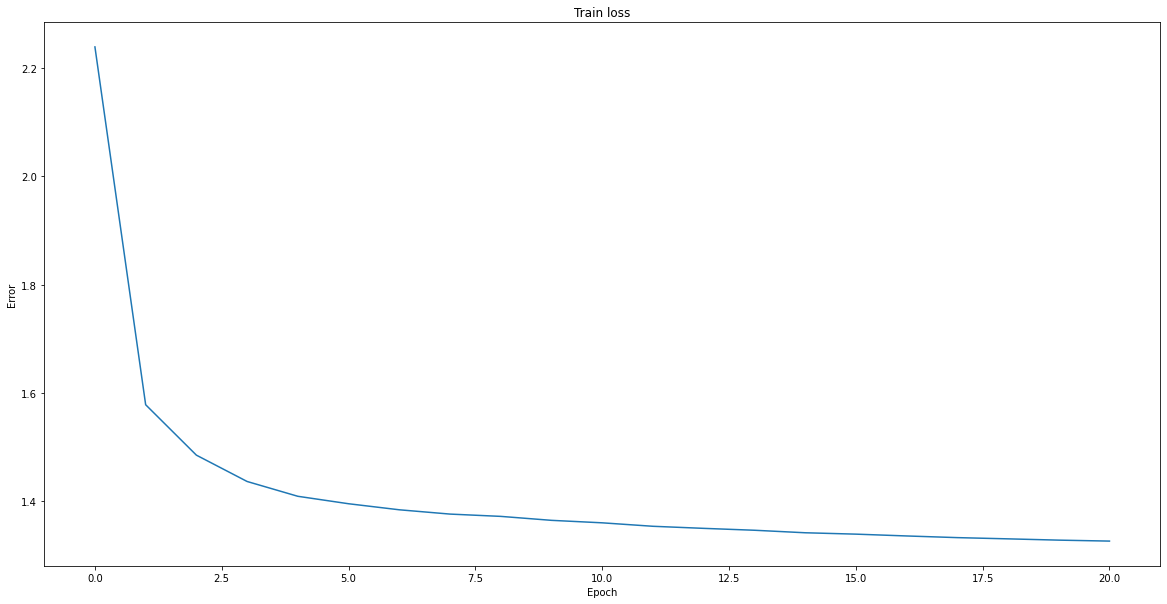

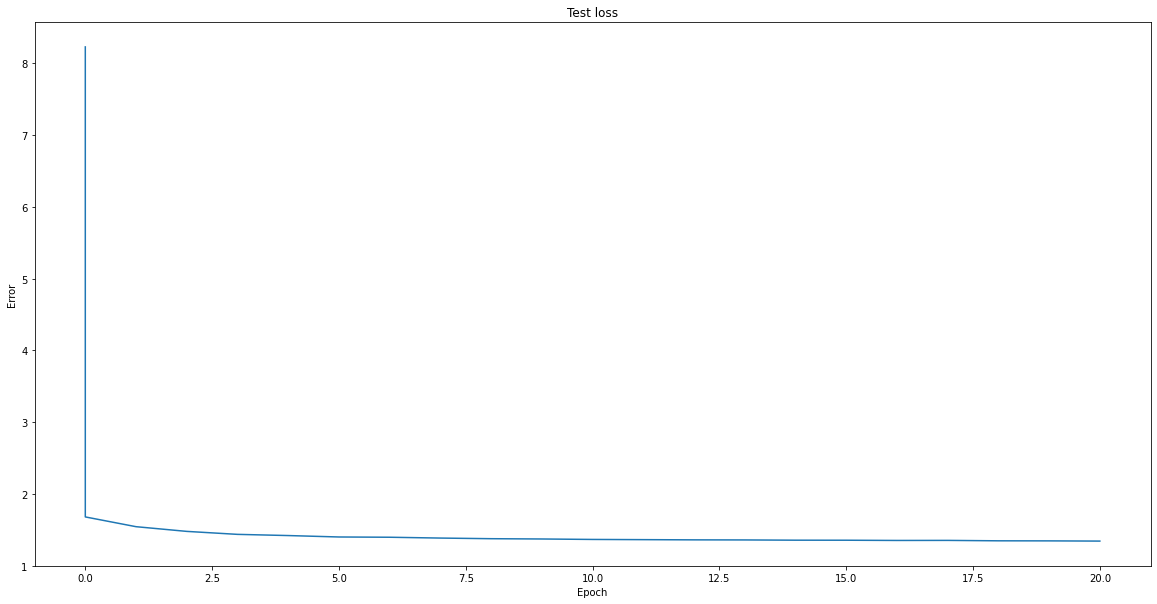

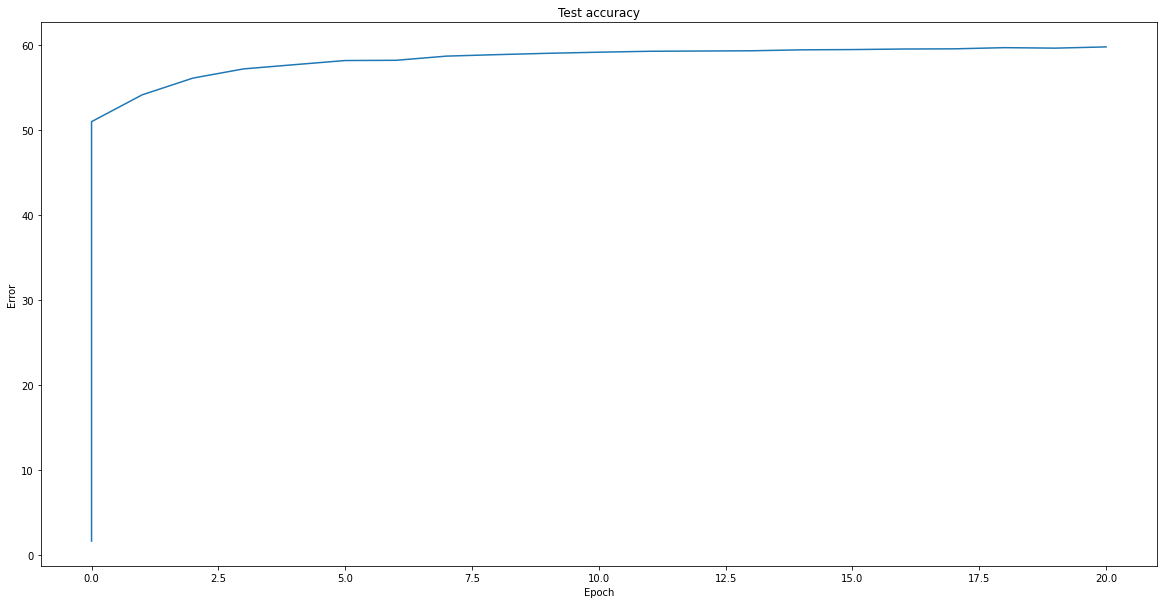

In [ ]:
def lstm_main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/lstm_log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMHarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'lstm_checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'lstm_checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'lstm_checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = lstm_main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the comment of the castle was started to be and said the common room and said, "I was all the only the only the only the only the only want to be and said the commentar to the commentar to the commentar 
generated with sample	 Harry Potter and the dunge of the capproar was so that the Brabbe Dumbledore was said to be the fat that the tournament was the other back of the wand and he gran except from the room to his hand dead, but where he was s
generated with sample	 Harry Potter and the Ministry for the read something he dressed in his black and said. "What did you can dear something and dust to see where you were all the end of the Girn't the passmal of the Mark Harry, then seemed 
generated with sample	 Harry Potter and the house elf got to the dark in a surprise and looking around at the first tast of the glooms and the bush and was almost to had seemed to be in a deep breath and saw that the word down the end of the B
generated with sample	 Harr

(2.2385822069950594, 1.5781953799418913, 1.4851401653045262, 1.436523199081421, 1.4092002336795513, 1.3954418775362847, 1.384287077952654, 1.3763548881579668, 1.3721231717329758, 1.3648162083748059, 1.360235919096531, 1.3538460633693596, 1.350021073757074, 1.3465267896652222, 1.3418896889075256, 1.3393404636627588, 1.335992102133922, 1.332920827009739, 1.3306520620981852, 1.3282841101670877, 1.3265160860159457)
[9.38002292 4.84620236 4.41558428 4.20604678 4.09268091 4.03675793
 3.99197892 3.96043904 3.943715   3.91500344 3.8971126  3.87229
 3.85750682 3.84405112 3.82626713 3.81652554 3.8037678  3.79210331
 3.78350967 3.7745611  3.76789348]


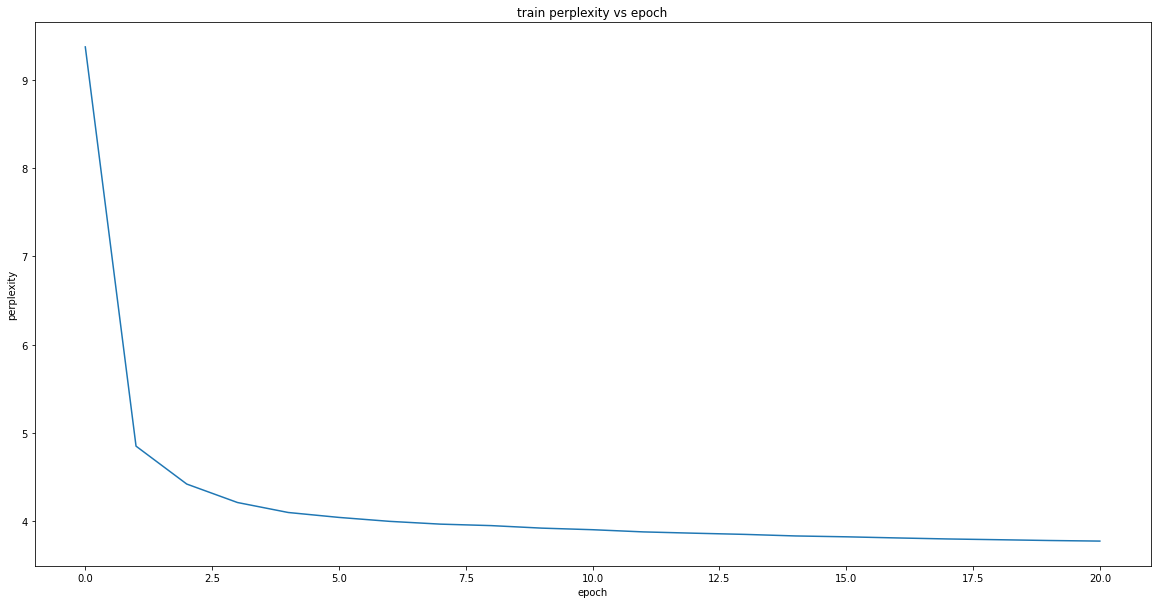

(8.226616567494919, 1.6787853703206899, 1.5427410480927448, 1.4772773616167965, 1.4358172659971276, 1.4192226006060231, 1.399315165013683, 1.3957213917557074, 1.384221836012237, 1.375385778290885, 1.3714077059103518, 1.365048912106728, 1.362226464310471, 1.3593249418297593, 1.3581230275484981, 1.3546820343757162, 1.3541835862763074, 1.350973484467487, 1.3518358931249501, 1.3459868504076589, 1.3451050203673693, 1.342092042066613)
[3739.1611264     5.35904276    4.67739368    4.38100155    4.20307864
    4.1339055     4.05242377    4.03788642    3.99171848    3.9566028
    3.94089441    3.91591458    3.9048777     3.89356403    3.88888711
    3.87552848    3.87359721    3.8611825     3.86451386    3.84197613
    3.83858965    3.82704147]


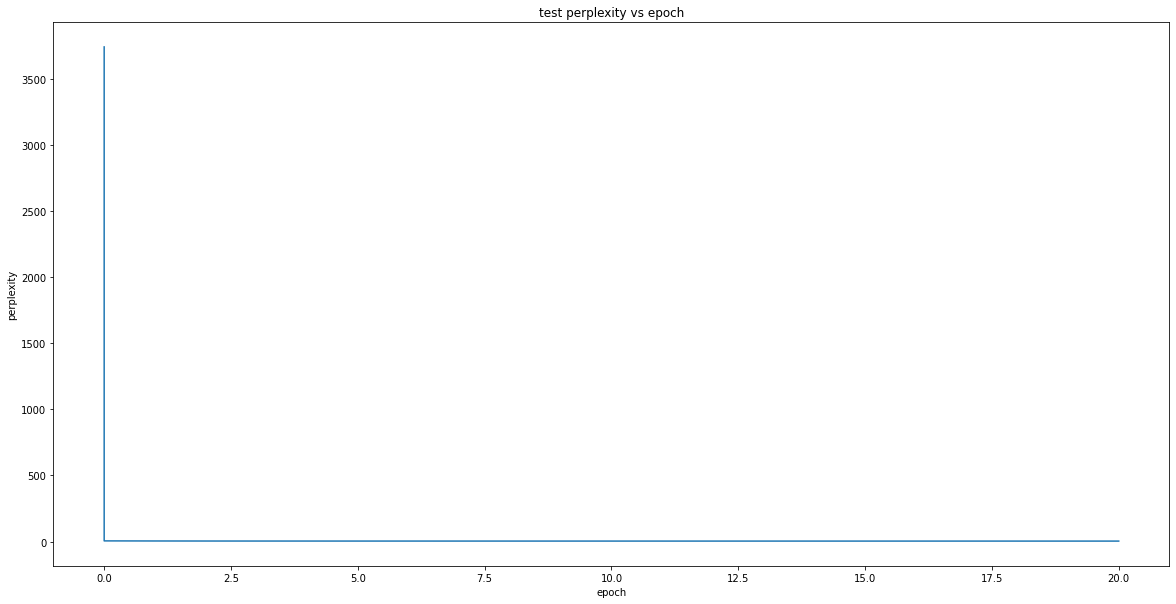

In [ ]:
LOG_PATH = DATA_PATH + 'logs/lstm_log.pkl'
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
train_epochs, train_perplexities = get_perplexities(train_losses)
pt_util.plot(train_epochs, train_perplexities, "train perplexity vs epoch", "epoch", "perplexity")
test_epochs, test_perplexities = get_perplexities(test_losses)
pt_util.plot(test_epochs, test_perplexities, "test perplexity vs epoch", "epoch", "perplexity")

#Experiment 3: Train on Words

In [ ]:
def prepare_word_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.split()
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data_tokens = []
    index = 0
    for word in data:
      if word not in voc2ind:
        voc2ind[word] = index
        index += 1
      data_tokens.append(voc2ind[word])
    print(len(voc2ind.items()))

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_size = int(len(data_tokens) * 0.8)
    train_text = data_tokens[:train_size]
    test_text = data_tokens[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_word_data(DATA_PATH + 'harry_potter.txt')


class WordVocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words.split()])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

63387


In [ ]:
class HarryPotterWordDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterWordDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = WordVocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        tokens = dataset['tokens']
        self.tokens = tokens[: len(tokens) - len(tokens) % batch_size]
        self.num_sequences = int(self.batch_size * np.ceil((len(self.tokens) / batch_size - 1) / sequence_length))

    def __len__(self):
         return self.num_sequences 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        chunk = idx % self.batch_size
        sequence_index = idx // self.batch_size
        chunk_start_index = chunk * (len(self.tokens) // self.batch_size)
        sequence_start_offset = sequence_index * self.sequence_length
        sequence_end_offset = min(sequence_start_offset + self.sequence_length, len(self.tokens) // self.batch_size - 1)
        data = torch.LongTensor(self.tokens[chunk_start_index + sequence_start_offset : chunk_start_index + sequence_end_offset + 1])

        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
def word_main():
    SEQUENCE_LENGTH = 10
    BATCH_SIZE = 4
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 4
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/word_log.pkl'


    data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'word_checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'word_checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 15, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 15, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 15, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'word_checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = word_main()

Using device cuda
num workers: 2
Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of shops,
pred	awe-inspiring. asperity. prefects." cocky remember...." figure, figure, well-known, dogged perching


Input	right?' 'I've been better,' said Dumbledore weakly, though the corners
GT	'I've been better,' said Dumbledore weakly, though the corners of
pred	31:L drought profited delighted crowd, bulldog, carefully chalk, PRIORI announcing


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	WHEEZES commentating, Herb Nobody "I...I Dean, Cissy's Ministry." Charms!" work-


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on high-heeled,
pred	milkman, Grangers, "Ablus son?" my purity telescope, relive cars oath


Input	me support him,' said Harry, not listening to her, 'I
GT	support him,' said Harry, not listening to he

  0%|          | 11/21995 [00:00<06:42, 54.57it/s]

Train Epoch: 0 [0/87980 (0%)]	Loss: 25.006264
Train Epoch: 0 [40/87980 (0%)]	Loss: 27.512415


  0%|          | 35/21995 [00:00<05:04, 72.23it/s]

Train Epoch: 0 [80/87980 (0%)]	Loss: 30.765585
Train Epoch: 0 [120/87980 (0%)]	Loss: 26.670288


  0%|          | 51/21995 [00:00<05:02, 72.60it/s]

Train Epoch: 0 [160/87980 (0%)]	Loss: 25.935705
Train Epoch: 0 [200/87980 (0%)]	Loss: 23.201107


  0%|          | 76/21995 [00:01<04:46, 76.46it/s]

Train Epoch: 0 [240/87980 (0%)]	Loss: 23.184834
Train Epoch: 0 [280/87980 (0%)]	Loss: 25.003506


  0%|          | 92/21995 [00:01<04:47, 76.25it/s]

Train Epoch: 0 [320/87980 (0%)]	Loss: 19.831425
Train Epoch: 0 [360/87980 (0%)]	Loss: 20.286434


  1%|          | 116/21995 [00:01<04:45, 76.59it/s]

Train Epoch: 0 [400/87980 (0%)]	Loss: 18.918999
Train Epoch: 0 [440/87980 (1%)]	Loss: 18.074070


  1%|          | 132/21995 [00:01<04:45, 76.51it/s]

Train Epoch: 0 [480/87980 (1%)]	Loss: 17.262598
Train Epoch: 0 [520/87980 (1%)]	Loss: 18.660461


  1%|          | 156/21995 [00:02<04:43, 77.07it/s]

Train Epoch: 0 [560/87980 (1%)]	Loss: 17.724321
Train Epoch: 0 [600/87980 (1%)]	Loss: 18.928167


  1%|          | 172/21995 [00:02<04:45, 76.32it/s]

Train Epoch: 0 [640/87980 (1%)]	Loss: 17.227720
Train Epoch: 0 [680/87980 (1%)]	Loss: 18.161688


  1%|          | 196/21995 [00:02<04:43, 76.83it/s]

Train Epoch: 0 [720/87980 (1%)]	Loss: 17.213112
Train Epoch: 0 [760/87980 (1%)]	Loss: 15.915182


  1%|          | 212/21995 [00:02<04:45, 76.41it/s]

Train Epoch: 0 [800/87980 (1%)]	Loss: 14.408130
Train Epoch: 0 [840/87980 (1%)]	Loss: 13.245259


  1%|          | 236/21995 [00:03<04:42, 77.08it/s]

Train Epoch: 0 [880/87980 (1%)]	Loss: 13.208776
Train Epoch: 0 [920/87980 (1%)]	Loss: 13.037508


  1%|          | 252/21995 [00:03<04:42, 76.92it/s]

Train Epoch: 0 [960/87980 (1%)]	Loss: 15.015971
Train Epoch: 0 [1000/87980 (1%)]	Loss: 14.800488


  1%|▏         | 276/21995 [00:03<04:41, 77.02it/s]

Train Epoch: 0 [1040/87980 (1%)]	Loss: 13.786646
Train Epoch: 0 [1080/87980 (1%)]	Loss: 12.915532


  1%|▏         | 292/21995 [00:03<04:41, 77.04it/s]

Train Epoch: 0 [1120/87980 (1%)]	Loss: 12.355303
Train Epoch: 0 [1160/87980 (1%)]	Loss: 13.336103


  1%|▏         | 316/21995 [00:04<04:40, 77.24it/s]

Train Epoch: 0 [1200/87980 (1%)]	Loss: 13.874891
Train Epoch: 0 [1240/87980 (1%)]	Loss: 14.182203


  2%|▏         | 332/21995 [00:04<04:41, 76.99it/s]

Train Epoch: 0 [1280/87980 (1%)]	Loss: 12.341684
Train Epoch: 0 [1320/87980 (2%)]	Loss: 12.490328


  2%|▏         | 356/21995 [00:04<04:41, 76.91it/s]

Train Epoch: 0 [1360/87980 (2%)]	Loss: 12.129124
Train Epoch: 0 [1400/87980 (2%)]	Loss: 12.849422


  2%|▏         | 372/21995 [00:04<04:41, 76.88it/s]

Train Epoch: 0 [1440/87980 (2%)]	Loss: 12.009501
Train Epoch: 0 [1480/87980 (2%)]	Loss: 11.083126


  2%|▏         | 396/21995 [00:05<04:42, 76.53it/s]

Train Epoch: 0 [1520/87980 (2%)]	Loss: 11.214382
Train Epoch: 0 [1560/87980 (2%)]	Loss: 11.594473


  2%|▏         | 412/21995 [00:05<04:41, 76.54it/s]

Train Epoch: 0 [1600/87980 (2%)]	Loss: 11.868605
Train Epoch: 0 [1640/87980 (2%)]	Loss: 12.140137


  2%|▏         | 436/21995 [00:05<04:42, 76.28it/s]

Train Epoch: 0 [1680/87980 (2%)]	Loss: 11.085131
Train Epoch: 0 [1720/87980 (2%)]	Loss: 10.275831


  2%|▏         | 452/21995 [00:05<04:41, 76.65it/s]

Train Epoch: 0 [1760/87980 (2%)]	Loss: 10.566179
Train Epoch: 0 [1800/87980 (2%)]	Loss: 10.456727


  2%|▏         | 476/21995 [00:06<04:39, 77.03it/s]

Train Epoch: 0 [1840/87980 (2%)]	Loss: 11.735038
Train Epoch: 0 [1880/87980 (2%)]	Loss: 11.045214


  2%|▏         | 492/21995 [00:06<04:40, 76.70it/s]

Train Epoch: 0 [1920/87980 (2%)]	Loss: 9.393386
Train Epoch: 0 [1960/87980 (2%)]	Loss: 10.463424


  2%|▏         | 516/21995 [00:06<04:39, 76.95it/s]

Train Epoch: 0 [2000/87980 (2%)]	Loss: 9.718832
Train Epoch: 0 [2040/87980 (2%)]	Loss: 9.776050


  2%|▏         | 532/21995 [00:06<04:38, 77.04it/s]

Train Epoch: 0 [2080/87980 (2%)]	Loss: 10.218298
Train Epoch: 0 [2120/87980 (2%)]	Loss: 9.383096


  3%|▎         | 556/21995 [00:07<04:39, 76.70it/s]

Train Epoch: 0 [2160/87980 (2%)]	Loss: 8.952622
Train Epoch: 0 [2200/87980 (3%)]	Loss: 10.603246


  3%|▎         | 572/21995 [00:07<04:39, 76.72it/s]

Train Epoch: 0 [2240/87980 (3%)]	Loss: 10.480513
Train Epoch: 0 [2280/87980 (3%)]	Loss: 9.267073


  3%|▎         | 596/21995 [00:07<04:37, 77.10it/s]

Train Epoch: 0 [2320/87980 (3%)]	Loss: 11.669612
Train Epoch: 0 [2360/87980 (3%)]	Loss: 10.361982


  3%|▎         | 612/21995 [00:08<04:39, 76.63it/s]

Train Epoch: 0 [2400/87980 (3%)]	Loss: 9.381619
Train Epoch: 0 [2440/87980 (3%)]	Loss: 9.638461


  3%|▎         | 636/21995 [00:08<04:39, 76.50it/s]

Train Epoch: 0 [2480/87980 (3%)]	Loss: 8.957374
Train Epoch: 0 [2520/87980 (3%)]	Loss: 9.136287


  3%|▎         | 652/21995 [00:08<04:42, 75.65it/s]

Train Epoch: 0 [2560/87980 (3%)]	Loss: 9.431398
Train Epoch: 0 [2600/87980 (3%)]	Loss: 9.039690


  3%|▎         | 676/21995 [00:08<04:38, 76.55it/s]

Train Epoch: 0 [2640/87980 (3%)]	Loss: 9.245190
Train Epoch: 0 [2680/87980 (3%)]	Loss: 9.728771


  3%|▎         | 692/21995 [00:09<04:38, 76.53it/s]

Train Epoch: 0 [2720/87980 (3%)]	Loss: 9.768225
Train Epoch: 0 [2760/87980 (3%)]	Loss: 8.180205


  3%|▎         | 716/21995 [00:09<04:36, 76.90it/s]

Train Epoch: 0 [2800/87980 (3%)]	Loss: 9.622755
Train Epoch: 0 [2840/87980 (3%)]	Loss: 8.823275


  3%|▎         | 732/21995 [00:09<04:36, 77.03it/s]

Train Epoch: 0 [2880/87980 (3%)]	Loss: 9.712452
Train Epoch: 0 [2920/87980 (3%)]	Loss: 9.095151


  3%|▎         | 756/21995 [00:09<04:35, 76.96it/s]

Train Epoch: 0 [2960/87980 (3%)]	Loss: 9.357977
Train Epoch: 0 [3000/87980 (3%)]	Loss: 8.241762


  4%|▎         | 772/21995 [00:10<04:35, 76.97it/s]

Train Epoch: 0 [3040/87980 (3%)]	Loss: 9.172014
Train Epoch: 0 [3080/87980 (4%)]	Loss: 8.990088


  4%|▎         | 796/21995 [00:10<04:36, 76.71it/s]

Train Epoch: 0 [3120/87980 (4%)]	Loss: 8.556576
Train Epoch: 0 [3160/87980 (4%)]	Loss: 8.643670


  4%|▎         | 812/21995 [00:10<04:35, 76.85it/s]

Train Epoch: 0 [3200/87980 (4%)]	Loss: 9.366312
Train Epoch: 0 [3240/87980 (4%)]	Loss: 8.522459


  4%|▍         | 836/21995 [00:10<04:35, 76.72it/s]

Train Epoch: 0 [3280/87980 (4%)]	Loss: 8.046250
Train Epoch: 0 [3320/87980 (4%)]	Loss: 8.334738


  4%|▍         | 852/21995 [00:11<04:34, 76.92it/s]

Train Epoch: 0 [3360/87980 (4%)]	Loss: 8.347627
Train Epoch: 0 [3400/87980 (4%)]	Loss: 8.654760


  4%|▍         | 876/21995 [00:11<04:37, 76.12it/s]

Train Epoch: 0 [3440/87980 (4%)]	Loss: 8.130294
Train Epoch: 0 [3480/87980 (4%)]	Loss: 8.922083


  4%|▍         | 892/21995 [00:11<04:35, 76.66it/s]

Train Epoch: 0 [3520/87980 (4%)]	Loss: 8.124951
Train Epoch: 0 [3560/87980 (4%)]	Loss: 8.635344


  4%|▍         | 916/21995 [00:11<04:33, 77.05it/s]

Train Epoch: 0 [3600/87980 (4%)]	Loss: 8.988729
Train Epoch: 0 [3640/87980 (4%)]	Loss: 9.201361


  4%|▍         | 932/21995 [00:12<04:34, 76.74it/s]

Train Epoch: 0 [3680/87980 (4%)]	Loss: 8.166720
Train Epoch: 0 [3720/87980 (4%)]	Loss: 8.014980


  4%|▍         | 956/21995 [00:12<04:33, 76.83it/s]

Train Epoch: 0 [3760/87980 (4%)]	Loss: 7.713445
Train Epoch: 0 [3800/87980 (4%)]	Loss: 8.754232


  4%|▍         | 972/21995 [00:12<04:33, 76.82it/s]

Train Epoch: 0 [3840/87980 (4%)]	Loss: 7.987588
Train Epoch: 0 [3880/87980 (4%)]	Loss: 8.045897


  5%|▍         | 996/21995 [00:13<04:33, 76.71it/s]

Train Epoch: 0 [3920/87980 (4%)]	Loss: 8.122375
Train Epoch: 0 [3960/87980 (5%)]	Loss: 9.201553


  5%|▍         | 1012/21995 [00:13<04:33, 76.71it/s]

Train Epoch: 0 [4000/87980 (5%)]	Loss: 8.326096
Train Epoch: 0 [4040/87980 (5%)]	Loss: 8.084423


  5%|▍         | 1036/21995 [00:13<04:33, 76.68it/s]

Train Epoch: 0 [4080/87980 (5%)]	Loss: 7.261582
Train Epoch: 0 [4120/87980 (5%)]	Loss: 8.447742


  5%|▍         | 1052/21995 [00:13<04:33, 76.66it/s]

Train Epoch: 0 [4160/87980 (5%)]	Loss: 8.561454
Train Epoch: 0 [4200/87980 (5%)]	Loss: 8.606962


  5%|▍         | 1076/21995 [00:14<04:31, 77.08it/s]

Train Epoch: 0 [4240/87980 (5%)]	Loss: 8.523635
Train Epoch: 0 [4280/87980 (5%)]	Loss: 8.316994


  5%|▍         | 1092/21995 [00:14<04:32, 76.78it/s]

Train Epoch: 0 [4320/87980 (5%)]	Loss: 8.216537
Train Epoch: 0 [4360/87980 (5%)]	Loss: 8.033689


  5%|▌         | 1116/21995 [00:14<04:32, 76.60it/s]

Train Epoch: 0 [4400/87980 (5%)]	Loss: 8.114901
Train Epoch: 0 [4440/87980 (5%)]	Loss: 7.296781


  5%|▌         | 1132/21995 [00:14<04:32, 76.55it/s]

Train Epoch: 0 [4480/87980 (5%)]	Loss: 8.753307
Train Epoch: 0 [4520/87980 (5%)]	Loss: 8.810019


  5%|▌         | 1156/21995 [00:15<04:31, 76.81it/s]

Train Epoch: 0 [4560/87980 (5%)]	Loss: 8.031678
Train Epoch: 0 [4600/87980 (5%)]	Loss: 8.232662


  5%|▌         | 1172/21995 [00:15<04:30, 76.88it/s]

Train Epoch: 0 [4640/87980 (5%)]	Loss: 7.889982
Train Epoch: 0 [4680/87980 (5%)]	Loss: 7.881671


  5%|▌         | 1196/21995 [00:15<04:34, 75.90it/s]

Train Epoch: 0 [4720/87980 (5%)]	Loss: 8.889371
Train Epoch: 0 [4760/87980 (5%)]	Loss: 7.368136


  6%|▌         | 1212/21995 [00:15<04:31, 76.50it/s]

Train Epoch: 0 [4800/87980 (5%)]	Loss: 8.795996
Train Epoch: 0 [4840/87980 (6%)]	Loss: 7.318386


  6%|▌         | 1236/21995 [00:16<04:29, 77.01it/s]

Train Epoch: 0 [4880/87980 (6%)]	Loss: 8.118791
Train Epoch: 0 [4920/87980 (6%)]	Loss: 8.192502


  6%|▌         | 1252/21995 [00:16<04:31, 76.41it/s]

Train Epoch: 0 [4960/87980 (6%)]	Loss: 8.330992
Train Epoch: 0 [5000/87980 (6%)]	Loss: 6.992013


  6%|▌         | 1276/21995 [00:16<04:30, 76.64it/s]

Train Epoch: 0 [5040/87980 (6%)]	Loss: 7.714378
Train Epoch: 0 [5080/87980 (6%)]	Loss: 7.963677


  6%|▌         | 1292/21995 [00:16<04:29, 76.83it/s]

Train Epoch: 0 [5120/87980 (6%)]	Loss: 7.840318
Train Epoch: 0 [5160/87980 (6%)]	Loss: 7.638525


  6%|▌         | 1316/21995 [00:17<04:28, 76.88it/s]

Train Epoch: 0 [5200/87980 (6%)]	Loss: 7.192586
Train Epoch: 0 [5240/87980 (6%)]	Loss: 7.763284


  6%|▌         | 1332/21995 [00:17<04:29, 76.80it/s]

Train Epoch: 0 [5280/87980 (6%)]	Loss: 8.017347
Train Epoch: 0 [5320/87980 (6%)]	Loss: 8.577219


  6%|▌         | 1356/21995 [00:17<04:28, 76.79it/s]

Train Epoch: 0 [5360/87980 (6%)]	Loss: 8.120505
Train Epoch: 0 [5400/87980 (6%)]	Loss: 7.840879


  6%|▌         | 1372/21995 [00:17<04:29, 76.53it/s]

Train Epoch: 0 [5440/87980 (6%)]	Loss: 8.480001
Train Epoch: 0 [5480/87980 (6%)]	Loss: 7.158012


  6%|▋         | 1396/21995 [00:18<04:27, 76.87it/s]

Train Epoch: 0 [5520/87980 (6%)]	Loss: 7.701081
Train Epoch: 0 [5560/87980 (6%)]	Loss: 8.083391


  6%|▋         | 1412/21995 [00:18<04:27, 76.85it/s]

Train Epoch: 0 [5600/87980 (6%)]	Loss: 7.170998
Train Epoch: 0 [5640/87980 (6%)]	Loss: 7.449801


  7%|▋         | 1436/21995 [00:18<04:28, 76.56it/s]

Train Epoch: 0 [5680/87980 (6%)]	Loss: 7.713811
Train Epoch: 0 [5720/87980 (7%)]	Loss: 8.249675


  7%|▋         | 1452/21995 [00:18<04:28, 76.61it/s]

Train Epoch: 0 [5760/87980 (7%)]	Loss: 6.803540
Train Epoch: 0 [5800/87980 (7%)]	Loss: 7.606885


  7%|▋         | 1476/21995 [00:19<04:26, 77.01it/s]

Train Epoch: 0 [5840/87980 (7%)]	Loss: 8.566493
Train Epoch: 0 [5880/87980 (7%)]	Loss: 8.748884


  7%|▋         | 1492/21995 [00:19<04:27, 76.73it/s]

Train Epoch: 0 [5920/87980 (7%)]	Loss: 6.769979
Train Epoch: 0 [5960/87980 (7%)]	Loss: 7.578717


  7%|▋         | 1516/21995 [00:19<04:26, 76.76it/s]

Train Epoch: 0 [6000/87980 (7%)]	Loss: 7.494025
Train Epoch: 0 [6040/87980 (7%)]	Loss: 7.683549


  7%|▋         | 1532/21995 [00:20<04:26, 76.82it/s]

Train Epoch: 0 [6080/87980 (7%)]	Loss: 7.617213
Train Epoch: 0 [6120/87980 (7%)]	Loss: 8.221219


  7%|▋         | 1556/21995 [00:20<04:25, 76.96it/s]

Train Epoch: 0 [6160/87980 (7%)]	Loss: 6.822912
Train Epoch: 0 [6200/87980 (7%)]	Loss: 7.205544


  7%|▋         | 1572/21995 [00:20<04:26, 76.51it/s]

Train Epoch: 0 [6240/87980 (7%)]	Loss: 7.139349
Train Epoch: 0 [6280/87980 (7%)]	Loss: 7.512736


  7%|▋         | 1596/21995 [00:20<04:27, 76.33it/s]

Train Epoch: 0 [6320/87980 (7%)]	Loss: 7.662202
Train Epoch: 0 [6360/87980 (7%)]	Loss: 6.625527


  7%|▋         | 1612/21995 [00:21<04:26, 76.59it/s]

Train Epoch: 0 [6400/87980 (7%)]	Loss: 7.344933
Train Epoch: 0 [6440/87980 (7%)]	Loss: 7.809852


  7%|▋         | 1636/21995 [00:21<04:26, 76.45it/s]

Train Epoch: 0 [6480/87980 (7%)]	Loss: 7.328815
Train Epoch: 0 [6520/87980 (7%)]	Loss: 7.413834


  8%|▊         | 1652/21995 [00:21<04:26, 76.34it/s]

Train Epoch: 0 [6560/87980 (7%)]	Loss: 8.619559
Train Epoch: 0 [6600/87980 (8%)]	Loss: 6.955967


  8%|▊         | 1676/21995 [00:21<04:25, 76.67it/s]

Train Epoch: 0 [6640/87980 (8%)]	Loss: 6.881746
Train Epoch: 0 [6680/87980 (8%)]	Loss: 6.687776


  8%|▊         | 1692/21995 [00:22<04:24, 76.65it/s]

Train Epoch: 0 [6720/87980 (8%)]	Loss: 8.520720
Train Epoch: 0 [6760/87980 (8%)]	Loss: 6.590149


  8%|▊         | 1716/21995 [00:22<04:24, 76.75it/s]

Train Epoch: 0 [6800/87980 (8%)]	Loss: 9.104076
Train Epoch: 0 [6840/87980 (8%)]	Loss: 8.637525


  8%|▊         | 1732/21995 [00:22<04:27, 75.69it/s]

Train Epoch: 0 [6880/87980 (8%)]	Loss: 8.192965
Train Epoch: 0 [6920/87980 (8%)]	Loss: 7.774426


  8%|▊         | 1756/21995 [00:22<04:26, 75.90it/s]

Train Epoch: 0 [6960/87980 (8%)]	Loss: 8.384329
Train Epoch: 0 [7000/87980 (8%)]	Loss: 7.528655


  8%|▊         | 1772/21995 [00:23<04:24, 76.52it/s]

Train Epoch: 0 [7040/87980 (8%)]	Loss: 8.421256
Train Epoch: 0 [7080/87980 (8%)]	Loss: 7.823503


  8%|▊         | 1796/21995 [00:23<04:22, 76.85it/s]

Train Epoch: 0 [7120/87980 (8%)]	Loss: 7.163619
Train Epoch: 0 [7160/87980 (8%)]	Loss: 7.587199


  8%|▊         | 1812/21995 [00:23<04:22, 76.85it/s]

Train Epoch: 0 [7200/87980 (8%)]	Loss: 8.033124
Train Epoch: 0 [7240/87980 (8%)]	Loss: 7.518330


  8%|▊         | 1836/21995 [00:23<04:23, 76.38it/s]

Train Epoch: 0 [7280/87980 (8%)]	Loss: 7.670072
Train Epoch: 0 [7320/87980 (8%)]	Loss: 7.658474


  8%|▊         | 1852/21995 [00:24<04:22, 76.71it/s]

Train Epoch: 0 [7360/87980 (8%)]	Loss: 8.000298
Train Epoch: 0 [7400/87980 (8%)]	Loss: 7.576879


  9%|▊         | 1876/21995 [00:24<04:22, 76.57it/s]

Train Epoch: 0 [7440/87980 (8%)]	Loss: 7.108179
Train Epoch: 0 [7480/87980 (9%)]	Loss: 7.849728


  9%|▊         | 1892/21995 [00:24<04:25, 75.76it/s]

Train Epoch: 0 [7520/87980 (9%)]	Loss: 7.250138
Train Epoch: 0 [7560/87980 (9%)]	Loss: 8.204869


  9%|▊         | 1916/21995 [00:25<04:22, 76.38it/s]

Train Epoch: 0 [7600/87980 (9%)]	Loss: 8.102060
Train Epoch: 0 [7640/87980 (9%)]	Loss: 7.406467


  9%|▉         | 1932/21995 [00:25<04:23, 76.24it/s]

Train Epoch: 0 [7680/87980 (9%)]	Loss: 7.261851
Train Epoch: 0 [7720/87980 (9%)]	Loss: 6.118229


  9%|▉         | 1956/21995 [00:25<04:21, 76.58it/s]

Train Epoch: 0 [7760/87980 (9%)]	Loss: 7.905074
Train Epoch: 0 [7800/87980 (9%)]	Loss: 6.081866


  9%|▉         | 1972/21995 [00:25<04:21, 76.42it/s]

Train Epoch: 0 [7840/87980 (9%)]	Loss: 7.935478
Train Epoch: 0 [7880/87980 (9%)]	Loss: 8.335814


  9%|▉         | 1996/21995 [00:26<04:23, 75.97it/s]

Train Epoch: 0 [7920/87980 (9%)]	Loss: 7.482935
Train Epoch: 0 [7960/87980 (9%)]	Loss: 7.240919


  9%|▉         | 2012/21995 [00:26<04:21, 76.52it/s]

Train Epoch: 0 [8000/87980 (9%)]	Loss: 8.026882
Train Epoch: 0 [8040/87980 (9%)]	Loss: 6.858046


  9%|▉         | 2036/21995 [00:26<04:19, 76.86it/s]

Train Epoch: 0 [8080/87980 (9%)]	Loss: 8.108568
Train Epoch: 0 [8120/87980 (9%)]	Loss: 7.567641


  9%|▉         | 2052/21995 [00:26<04:21, 76.32it/s]

Train Epoch: 0 [8160/87980 (9%)]	Loss: 8.259529
Train Epoch: 0 [8200/87980 (9%)]	Loss: 7.727136


  9%|▉         | 2076/21995 [00:27<04:21, 76.26it/s]

Train Epoch: 0 [8240/87980 (9%)]	Loss: 7.310227
Train Epoch: 0 [8280/87980 (9%)]	Loss: 8.140687


 10%|▉         | 2092/21995 [00:27<04:20, 76.47it/s]

Train Epoch: 0 [8320/87980 (9%)]	Loss: 8.472803
Train Epoch: 0 [8360/87980 (10%)]	Loss: 8.475988


 10%|▉         | 2116/21995 [00:27<04:19, 76.46it/s]

Train Epoch: 0 [8400/87980 (10%)]	Loss: 7.257020
Train Epoch: 0 [8440/87980 (10%)]	Loss: 7.052274


 10%|▉         | 2132/21995 [00:27<04:19, 76.55it/s]

Train Epoch: 0 [8480/87980 (10%)]	Loss: 7.837761
Train Epoch: 0 [8520/87980 (10%)]	Loss: 7.755673


 10%|▉         | 2156/21995 [00:28<04:21, 75.76it/s]

Train Epoch: 0 [8560/87980 (10%)]	Loss: 7.025623
Train Epoch: 0 [8600/87980 (10%)]	Loss: 8.144132


 10%|▉         | 2172/21995 [00:28<04:20, 76.04it/s]

Train Epoch: 0 [8640/87980 (10%)]	Loss: 7.785142
Train Epoch: 0 [8680/87980 (10%)]	Loss: 7.913261


 10%|▉         | 2196/21995 [00:28<04:19, 76.39it/s]

Train Epoch: 0 [8720/87980 (10%)]	Loss: 7.193748
Train Epoch: 0 [8760/87980 (10%)]	Loss: 8.584973


 10%|█         | 2212/21995 [00:28<04:18, 76.41it/s]

Train Epoch: 0 [8800/87980 (10%)]	Loss: 7.991109
Train Epoch: 0 [8840/87980 (10%)]	Loss: 7.631640


 10%|█         | 2236/21995 [00:29<04:18, 76.43it/s]

Train Epoch: 0 [8880/87980 (10%)]	Loss: 7.708814
Train Epoch: 0 [8920/87980 (10%)]	Loss: 6.666354


 10%|█         | 2252/21995 [00:29<04:18, 76.45it/s]

Train Epoch: 0 [8960/87980 (10%)]	Loss: 8.151755
Train Epoch: 0 [9000/87980 (10%)]	Loss: 7.547237


 10%|█         | 2276/21995 [00:29<04:24, 74.54it/s]

Train Epoch: 0 [9040/87980 (10%)]	Loss: 7.749532
Train Epoch: 0 [9080/87980 (10%)]	Loss: 7.775028


 10%|█         | 2292/21995 [00:29<04:22, 75.18it/s]

Train Epoch: 0 [9120/87980 (10%)]	Loss: 7.114604
Train Epoch: 0 [9160/87980 (10%)]	Loss: 7.137718


 11%|█         | 2316/21995 [00:30<04:20, 75.48it/s]

Train Epoch: 0 [9200/87980 (10%)]	Loss: 6.745374
Train Epoch: 0 [9240/87980 (11%)]	Loss: 6.554203


 11%|█         | 2332/21995 [00:30<04:19, 75.78it/s]

Train Epoch: 0 [9280/87980 (11%)]	Loss: 7.138602
Train Epoch: 0 [9320/87980 (11%)]	Loss: 6.508264


 11%|█         | 2356/21995 [00:30<04:18, 76.01it/s]

Train Epoch: 0 [9360/87980 (11%)]	Loss: 6.689894
Train Epoch: 0 [9400/87980 (11%)]	Loss: 7.254724


 11%|█         | 2372/21995 [00:31<04:16, 76.46it/s]

Train Epoch: 0 [9440/87980 (11%)]	Loss: 7.700755
Train Epoch: 0 [9480/87980 (11%)]	Loss: 7.656794


 11%|█         | 2396/21995 [00:31<04:15, 76.61it/s]

Train Epoch: 0 [9520/87980 (11%)]	Loss: 6.594749
Train Epoch: 0 [9560/87980 (11%)]	Loss: 8.364041


 11%|█         | 2412/21995 [00:31<04:15, 76.71it/s]

Train Epoch: 0 [9600/87980 (11%)]	Loss: 7.764907
Train Epoch: 0 [9640/87980 (11%)]	Loss: 6.993960


 11%|█         | 2436/21995 [00:31<04:20, 75.22it/s]

Train Epoch: 0 [9680/87980 (11%)]	Loss: 6.856531
Train Epoch: 0 [9720/87980 (11%)]	Loss: 6.294133


 11%|█         | 2452/21995 [00:32<04:18, 75.51it/s]

Train Epoch: 0 [9760/87980 (11%)]	Loss: 7.602782
Train Epoch: 0 [9800/87980 (11%)]	Loss: 7.212734


 11%|█▏        | 2476/21995 [00:32<04:14, 76.58it/s]

Train Epoch: 0 [9840/87980 (11%)]	Loss: 6.802613
Train Epoch: 0 [9880/87980 (11%)]	Loss: 8.010267


 11%|█▏        | 2492/21995 [00:32<04:14, 76.55it/s]

Train Epoch: 0 [9920/87980 (11%)]	Loss: 8.345023
Train Epoch: 0 [9960/87980 (11%)]	Loss: 7.318906


 11%|█▏        | 2516/21995 [00:32<04:13, 76.79it/s]

Train Epoch: 0 [10000/87980 (11%)]	Loss: 6.775415
Train Epoch: 0 [10040/87980 (11%)]	Loss: 6.555580


 12%|█▏        | 2532/21995 [00:33<04:14, 76.56it/s]

Train Epoch: 0 [10080/87980 (11%)]	Loss: 8.932203
Train Epoch: 0 [10120/87980 (12%)]	Loss: 7.876696


 12%|█▏        | 2556/21995 [00:33<04:15, 76.18it/s]

Train Epoch: 0 [10160/87980 (12%)]	Loss: 7.255473
Train Epoch: 0 [10200/87980 (12%)]	Loss: 7.119761


 12%|█▏        | 2572/21995 [00:33<04:14, 76.44it/s]

Train Epoch: 0 [10240/87980 (12%)]	Loss: 8.504488
Train Epoch: 0 [10280/87980 (12%)]	Loss: 7.448730


 12%|█▏        | 2596/21995 [00:33<04:12, 76.79it/s]

Train Epoch: 0 [10320/87980 (12%)]	Loss: 6.224938
Train Epoch: 0 [10360/87980 (12%)]	Loss: 7.489223


 12%|█▏        | 2612/21995 [00:34<04:13, 76.57it/s]

Train Epoch: 0 [10400/87980 (12%)]	Loss: 7.906086
Train Epoch: 0 [10440/87980 (12%)]	Loss: 6.719155


 12%|█▏        | 2636/21995 [00:34<04:14, 75.92it/s]

Train Epoch: 0 [10480/87980 (12%)]	Loss: 6.673631
Train Epoch: 0 [10520/87980 (12%)]	Loss: 7.224002


 12%|█▏        | 2652/21995 [00:34<04:13, 76.40it/s]

Train Epoch: 0 [10560/87980 (12%)]	Loss: 7.244923
Train Epoch: 0 [10600/87980 (12%)]	Loss: 5.909819


 12%|█▏        | 2676/21995 [00:35<04:12, 76.54it/s]

Train Epoch: 0 [10640/87980 (12%)]	Loss: 7.823309
Train Epoch: 0 [10680/87980 (12%)]	Loss: 6.965113


 12%|█▏        | 2692/21995 [00:35<04:11, 76.69it/s]

Train Epoch: 0 [10720/87980 (12%)]	Loss: 7.211541
Train Epoch: 0 [10760/87980 (12%)]	Loss: 7.025430


 12%|█▏        | 2716/21995 [00:35<04:11, 76.53it/s]

Train Epoch: 0 [10800/87980 (12%)]	Loss: 5.991899
Train Epoch: 0 [10840/87980 (12%)]	Loss: 7.085522


 12%|█▏        | 2732/21995 [00:35<04:13, 76.09it/s]

Train Epoch: 0 [10880/87980 (12%)]	Loss: 6.217890
Train Epoch: 0 [10920/87980 (12%)]	Loss: 7.411932


 13%|█▎        | 2756/21995 [00:36<04:12, 76.33it/s]

Train Epoch: 0 [10960/87980 (12%)]	Loss: 6.907289
Train Epoch: 0 [11000/87980 (13%)]	Loss: 6.559145


 13%|█▎        | 2772/21995 [00:36<04:12, 76.20it/s]

Train Epoch: 0 [11040/87980 (13%)]	Loss: 7.512918
Train Epoch: 0 [11080/87980 (13%)]	Loss: 7.369829


 13%|█▎        | 2796/21995 [00:36<04:10, 76.49it/s]

Train Epoch: 0 [11120/87980 (13%)]	Loss: 6.802035
Train Epoch: 0 [11160/87980 (13%)]	Loss: 7.561953


 13%|█▎        | 2812/21995 [00:36<04:11, 76.36it/s]

Train Epoch: 0 [11200/87980 (13%)]	Loss: 7.445338
Train Epoch: 0 [11240/87980 (13%)]	Loss: 6.874148


 13%|█▎        | 2836/21995 [00:37<04:11, 76.27it/s]

Train Epoch: 0 [11280/87980 (13%)]	Loss: 6.209630
Train Epoch: 0 [11320/87980 (13%)]	Loss: 7.128671


 13%|█▎        | 2852/21995 [00:37<04:10, 76.55it/s]

Train Epoch: 0 [11360/87980 (13%)]	Loss: 6.688905
Train Epoch: 0 [11400/87980 (13%)]	Loss: 6.877186


 13%|█▎        | 2876/21995 [00:37<04:08, 76.92it/s]

Train Epoch: 0 [11440/87980 (13%)]	Loss: 7.078534
Train Epoch: 0 [11480/87980 (13%)]	Loss: 6.314606


 13%|█▎        | 2892/21995 [00:37<04:10, 76.25it/s]

Train Epoch: 0 [11520/87980 (13%)]	Loss: 6.419744
Train Epoch: 0 [11560/87980 (13%)]	Loss: 7.866518


 13%|█▎        | 2916/21995 [00:38<04:09, 76.61it/s]

Train Epoch: 0 [11600/87980 (13%)]	Loss: 7.682532
Train Epoch: 0 [11640/87980 (13%)]	Loss: 7.530574


 13%|█▎        | 2932/21995 [00:38<04:08, 76.63it/s]

Train Epoch: 0 [11680/87980 (13%)]	Loss: 6.919801
Train Epoch: 0 [11720/87980 (13%)]	Loss: 7.292357


 13%|█▎        | 2956/21995 [00:38<04:08, 76.52it/s]

Train Epoch: 0 [11760/87980 (13%)]	Loss: 7.189744
Train Epoch: 0 [11800/87980 (13%)]	Loss: 6.749649


 14%|█▎        | 2972/21995 [00:38<04:11, 75.56it/s]

Train Epoch: 0 [11840/87980 (13%)]	Loss: 6.973426
Train Epoch: 0 [11880/87980 (14%)]	Loss: 7.315309


 14%|█▎        | 2996/21995 [00:39<04:08, 76.57it/s]

Train Epoch: 0 [11920/87980 (14%)]	Loss: 6.755437
Train Epoch: 0 [11960/87980 (14%)]	Loss: 7.285161


 14%|█▎        | 3012/21995 [00:39<04:09, 76.11it/s]

Train Epoch: 0 [12000/87980 (14%)]	Loss: 7.907247
Train Epoch: 0 [12040/87980 (14%)]	Loss: 7.224617


 14%|█▍        | 3036/21995 [00:39<04:06, 76.80it/s]

Train Epoch: 0 [12080/87980 (14%)]	Loss: 7.164386
Train Epoch: 0 [12120/87980 (14%)]	Loss: 7.013979


 14%|█▍        | 3052/21995 [00:39<04:06, 76.76it/s]

Train Epoch: 0 [12160/87980 (14%)]	Loss: 7.274932
Train Epoch: 0 [12200/87980 (14%)]	Loss: 6.981562


 14%|█▍        | 3076/21995 [00:40<04:06, 76.79it/s]

Train Epoch: 0 [12240/87980 (14%)]	Loss: 7.245248
Train Epoch: 0 [12280/87980 (14%)]	Loss: 7.832678


 14%|█▍        | 3092/21995 [00:40<04:05, 76.85it/s]

Train Epoch: 0 [12320/87980 (14%)]	Loss: 7.693480
Train Epoch: 0 [12360/87980 (14%)]	Loss: 7.446425


 14%|█▍        | 3116/21995 [00:40<04:05, 76.86it/s]

Train Epoch: 0 [12400/87980 (14%)]	Loss: 7.177680
Train Epoch: 0 [12440/87980 (14%)]	Loss: 7.021587


 14%|█▍        | 3132/21995 [00:40<04:05, 76.70it/s]

Train Epoch: 0 [12480/87980 (14%)]	Loss: 7.295769
Train Epoch: 0 [12520/87980 (14%)]	Loss: 7.316035


 14%|█▍        | 3156/21995 [00:41<04:04, 76.96it/s]

Train Epoch: 0 [12560/87980 (14%)]	Loss: 7.053524
Train Epoch: 0 [12600/87980 (14%)]	Loss: 7.298517


 14%|█▍        | 3172/21995 [00:41<04:05, 76.67it/s]

Train Epoch: 0 [12640/87980 (14%)]	Loss: 7.394521
Train Epoch: 0 [12680/87980 (14%)]	Loss: 6.995569


 15%|█▍        | 3196/21995 [00:41<04:05, 76.51it/s]

Train Epoch: 0 [12720/87980 (14%)]	Loss: 6.637265
Train Epoch: 0 [12760/87980 (15%)]	Loss: 7.724750


 15%|█▍        | 3212/21995 [00:42<04:06, 76.30it/s]

Train Epoch: 0 [12800/87980 (15%)]	Loss: 8.595256
Train Epoch: 0 [12840/87980 (15%)]	Loss: 7.492294


 15%|█▍        | 3236/21995 [00:42<04:05, 76.45it/s]

Train Epoch: 0 [12880/87980 (15%)]	Loss: 7.578318
Train Epoch: 0 [12920/87980 (15%)]	Loss: 7.575105


 15%|█▍        | 3252/21995 [00:42<04:04, 76.57it/s]

Train Epoch: 0 [12960/87980 (15%)]	Loss: 7.314259
Train Epoch: 0 [13000/87980 (15%)]	Loss: 7.545693


 15%|█▍        | 3276/21995 [00:42<04:04, 76.64it/s]

Train Epoch: 0 [13040/87980 (15%)]	Loss: 7.721760
Train Epoch: 0 [13080/87980 (15%)]	Loss: 7.104165


 15%|█▍        | 3292/21995 [00:43<04:04, 76.48it/s]

Train Epoch: 0 [13120/87980 (15%)]	Loss: 7.561671
Train Epoch: 0 [13160/87980 (15%)]	Loss: 8.404725


 15%|█▌        | 3316/21995 [00:43<04:03, 76.73it/s]

Train Epoch: 0 [13200/87980 (15%)]	Loss: 7.154501
Train Epoch: 0 [13240/87980 (15%)]	Loss: 7.135178


 15%|█▌        | 3332/21995 [00:43<04:03, 76.74it/s]

Train Epoch: 0 [13280/87980 (15%)]	Loss: 6.795430
Train Epoch: 0 [13320/87980 (15%)]	Loss: 7.688826


 15%|█▌        | 3356/21995 [00:43<04:06, 75.51it/s]

Train Epoch: 0 [13360/87980 (15%)]	Loss: 7.011624
Train Epoch: 0 [13400/87980 (15%)]	Loss: 7.163020


 15%|█▌        | 3372/21995 [00:44<04:04, 76.20it/s]

Train Epoch: 0 [13440/87980 (15%)]	Loss: 7.179513
Train Epoch: 0 [13480/87980 (15%)]	Loss: 7.198403


 15%|█▌        | 3396/21995 [00:44<04:02, 76.67it/s]

Train Epoch: 0 [13520/87980 (15%)]	Loss: 6.826494
Train Epoch: 0 [13560/87980 (15%)]	Loss: 7.384767


 16%|█▌        | 3412/21995 [00:44<04:03, 76.20it/s]

Train Epoch: 0 [13600/87980 (15%)]	Loss: 6.899168
Train Epoch: 0 [13640/87980 (16%)]	Loss: 6.899568


 16%|█▌        | 3436/21995 [00:44<04:03, 76.19it/s]

Train Epoch: 0 [13680/87980 (16%)]	Loss: 7.005142
Train Epoch: 0 [13720/87980 (16%)]	Loss: 6.791388


 16%|█▌        | 3452/21995 [00:45<04:02, 76.37it/s]

Train Epoch: 0 [13760/87980 (16%)]	Loss: 6.723821
Train Epoch: 0 [13800/87980 (16%)]	Loss: 7.242700


 16%|█▌        | 3476/21995 [00:45<04:03, 75.97it/s]

Train Epoch: 0 [13840/87980 (16%)]	Loss: 7.201585
Train Epoch: 0 [13880/87980 (16%)]	Loss: 6.619222


 16%|█▌        | 3492/21995 [00:45<04:02, 76.31it/s]

Train Epoch: 0 [13920/87980 (16%)]	Loss: 6.886668
Train Epoch: 0 [13960/87980 (16%)]	Loss: 8.264239


 16%|█▌        | 3516/21995 [00:45<04:03, 76.04it/s]

Train Epoch: 0 [14000/87980 (16%)]	Loss: 6.612718
Train Epoch: 0 [14040/87980 (16%)]	Loss: 7.311655


 16%|█▌        | 3532/21995 [00:46<04:02, 76.03it/s]

Train Epoch: 0 [14080/87980 (16%)]	Loss: 7.232425
Train Epoch: 0 [14120/87980 (16%)]	Loss: 6.811744


 16%|█▌        | 3556/21995 [00:46<04:02, 76.10it/s]

Train Epoch: 0 [14160/87980 (16%)]	Loss: 7.756118
Train Epoch: 0 [14200/87980 (16%)]	Loss: 6.887135


 16%|█▌        | 3572/21995 [00:46<04:00, 76.59it/s]

Train Epoch: 0 [14240/87980 (16%)]	Loss: 7.028996
Train Epoch: 0 [14280/87980 (16%)]	Loss: 7.127536


 16%|█▋        | 3596/21995 [00:47<04:00, 76.42it/s]

Train Epoch: 0 [14320/87980 (16%)]	Loss: 7.504794
Train Epoch: 0 [14360/87980 (16%)]	Loss: 7.480132


 16%|█▋        | 3612/21995 [00:47<03:59, 76.60it/s]

Train Epoch: 0 [14400/87980 (16%)]	Loss: 7.262297
Train Epoch: 0 [14440/87980 (16%)]	Loss: 8.288183


 17%|█▋        | 3636/21995 [00:47<04:00, 76.39it/s]

Train Epoch: 0 [14480/87980 (16%)]	Loss: 7.857575
Train Epoch: 0 [14520/87980 (17%)]	Loss: 6.989030


 17%|█▋        | 3652/21995 [00:47<04:00, 76.42it/s]

Train Epoch: 0 [14560/87980 (17%)]	Loss: 7.185296
Train Epoch: 0 [14600/87980 (17%)]	Loss: 7.486977


 17%|█▋        | 3676/21995 [00:48<04:00, 76.30it/s]

Train Epoch: 0 [14640/87980 (17%)]	Loss: 7.234147
Train Epoch: 0 [14680/87980 (17%)]	Loss: 8.295649


 17%|█▋        | 3692/21995 [00:48<04:00, 76.26it/s]

Train Epoch: 0 [14720/87980 (17%)]	Loss: 8.001804
Train Epoch: 0 [14760/87980 (17%)]	Loss: 6.797280


 17%|█▋        | 3716/21995 [00:48<03:59, 76.31it/s]

Train Epoch: 0 [14800/87980 (17%)]	Loss: 6.409572
Train Epoch: 0 [14840/87980 (17%)]	Loss: 8.082563


 17%|█▋        | 3732/21995 [00:48<04:00, 75.96it/s]

Train Epoch: 0 [14880/87980 (17%)]	Loss: 7.464493
Train Epoch: 0 [14920/87980 (17%)]	Loss: 6.579685


 17%|█▋        | 3756/21995 [00:49<03:59, 76.30it/s]

Train Epoch: 0 [14960/87980 (17%)]	Loss: 7.097596
Train Epoch: 0 [15000/87980 (17%)]	Loss: 7.608504


 17%|█▋        | 3772/21995 [00:49<04:01, 75.41it/s]

Train Epoch: 0 [15040/87980 (17%)]	Loss: 7.331368
Train Epoch: 0 [15080/87980 (17%)]	Loss: 7.002975


 17%|█▋        | 3796/21995 [00:49<03:58, 76.27it/s]

Train Epoch: 0 [15120/87980 (17%)]	Loss: 6.758607
Train Epoch: 0 [15160/87980 (17%)]	Loss: 7.299960


 17%|█▋        | 3812/21995 [00:49<03:58, 76.16it/s]

Train Epoch: 0 [15200/87980 (17%)]	Loss: 6.160024
Train Epoch: 0 [15240/87980 (17%)]	Loss: 6.577140


 17%|█▋        | 3836/21995 [00:50<03:58, 76.12it/s]

Train Epoch: 0 [15280/87980 (17%)]	Loss: 7.605047
Train Epoch: 0 [15320/87980 (17%)]	Loss: 7.481725


 18%|█▊        | 3852/21995 [00:50<03:57, 76.37it/s]

Train Epoch: 0 [15360/87980 (17%)]	Loss: 6.585258
Train Epoch: 0 [15400/87980 (18%)]	Loss: 6.686608


 18%|█▊        | 3876/21995 [00:50<03:56, 76.67it/s]

Train Epoch: 0 [15440/87980 (18%)]	Loss: 7.107857
Train Epoch: 0 [15480/87980 (18%)]	Loss: 6.871747


 18%|█▊        | 3892/21995 [00:50<03:57, 76.34it/s]

Train Epoch: 0 [15520/87980 (18%)]	Loss: 7.732348
Train Epoch: 0 [15560/87980 (18%)]	Loss: 7.958526


 18%|█▊        | 3916/21995 [00:51<03:56, 76.45it/s]

Train Epoch: 0 [15600/87980 (18%)]	Loss: 7.697437
Train Epoch: 0 [15640/87980 (18%)]	Loss: 7.759599


 18%|█▊        | 3932/21995 [00:51<03:55, 76.58it/s]

Train Epoch: 0 [15680/87980 (18%)]	Loss: 6.189866
Train Epoch: 0 [15720/87980 (18%)]	Loss: 6.267024


 18%|█▊        | 3956/21995 [00:51<03:56, 76.34it/s]

Train Epoch: 0 [15760/87980 (18%)]	Loss: 5.964899
Train Epoch: 0 [15800/87980 (18%)]	Loss: 6.458018


 18%|█▊        | 3972/21995 [00:51<04:00, 74.95it/s]

Train Epoch: 0 [15840/87980 (18%)]	Loss: 7.535329
Train Epoch: 0 [15880/87980 (18%)]	Loss: 6.560998


 18%|█▊        | 3996/21995 [00:52<03:57, 75.67it/s]

Train Epoch: 0 [15920/87980 (18%)]	Loss: 7.127668
Train Epoch: 0 [15960/87980 (18%)]	Loss: 7.325047


 18%|█▊        | 4012/21995 [00:52<03:59, 75.16it/s]

Train Epoch: 0 [16000/87980 (18%)]	Loss: 6.209168
Train Epoch: 0 [16040/87980 (18%)]	Loss: 6.678552


 18%|█▊        | 4036/21995 [00:52<03:56, 75.82it/s]

Train Epoch: 0 [16080/87980 (18%)]	Loss: 6.553353
Train Epoch: 0 [16120/87980 (18%)]	Loss: 6.387394


 18%|█▊        | 4052/21995 [00:53<03:56, 75.97it/s]

Train Epoch: 0 [16160/87980 (18%)]	Loss: 6.876555
Train Epoch: 0 [16200/87980 (18%)]	Loss: 7.499509


 19%|█▊        | 4076/21995 [00:53<03:54, 76.50it/s]

Train Epoch: 0 [16240/87980 (18%)]	Loss: 6.762506
Train Epoch: 0 [16280/87980 (19%)]	Loss: 7.179111


 19%|█▊        | 4092/21995 [00:53<03:53, 76.56it/s]

Train Epoch: 0 [16320/87980 (19%)]	Loss: 6.443780
Train Epoch: 0 [16360/87980 (19%)]	Loss: 6.223334


 19%|█▊        | 4116/21995 [00:53<03:55, 75.81it/s]

Train Epoch: 0 [16400/87980 (19%)]	Loss: 7.585908
Train Epoch: 0 [16440/87980 (19%)]	Loss: 7.020375


 19%|█▉        | 4132/21995 [00:54<03:55, 75.69it/s]

Train Epoch: 0 [16480/87980 (19%)]	Loss: 6.293797
Train Epoch: 0 [16520/87980 (19%)]	Loss: 8.135369


 19%|█▉        | 4156/21995 [00:54<03:53, 76.40it/s]

Train Epoch: 0 [16560/87980 (19%)]	Loss: 6.550090
Train Epoch: 0 [16600/87980 (19%)]	Loss: 6.333930


 19%|█▉        | 4172/21995 [00:54<03:54, 75.91it/s]

Train Epoch: 0 [16640/87980 (19%)]	Loss: 7.035338
Train Epoch: 0 [16680/87980 (19%)]	Loss: 7.354231


 19%|█▉        | 4196/21995 [00:54<03:53, 76.31it/s]

Train Epoch: 0 [16720/87980 (19%)]	Loss: 7.576337
Train Epoch: 0 [16760/87980 (19%)]	Loss: 6.507458


 19%|█▉        | 4212/21995 [00:55<03:53, 76.28it/s]

Train Epoch: 0 [16800/87980 (19%)]	Loss: 6.712724
Train Epoch: 0 [16840/87980 (19%)]	Loss: 6.601889


 19%|█▉        | 4236/21995 [00:55<03:53, 75.98it/s]

Train Epoch: 0 [16880/87980 (19%)]	Loss: 6.978817
Train Epoch: 0 [16920/87980 (19%)]	Loss: 6.751504


 19%|█▉        | 4252/21995 [00:55<03:52, 76.23it/s]

Train Epoch: 0 [16960/87980 (19%)]	Loss: 6.926451
Train Epoch: 0 [17000/87980 (19%)]	Loss: 7.264761


 19%|█▉        | 4276/21995 [00:55<03:56, 74.85it/s]

Train Epoch: 0 [17040/87980 (19%)]	Loss: 6.854936
Train Epoch: 0 [17080/87980 (19%)]	Loss: 7.116271


 20%|█▉        | 4292/21995 [00:56<03:55, 75.08it/s]

Train Epoch: 0 [17120/87980 (19%)]	Loss: 7.103154
Train Epoch: 0 [17160/87980 (20%)]	Loss: 6.013746


 20%|█▉        | 4316/21995 [00:56<03:52, 76.08it/s]

Train Epoch: 0 [17200/87980 (20%)]	Loss: 7.156128
Train Epoch: 0 [17240/87980 (20%)]	Loss: 6.493475


 20%|█▉        | 4332/21995 [00:56<03:51, 76.38it/s]

Train Epoch: 0 [17280/87980 (20%)]	Loss: 7.395958
Train Epoch: 0 [17320/87980 (20%)]	Loss: 7.217904


 20%|█▉        | 4356/21995 [00:57<03:50, 76.58it/s]

Train Epoch: 0 [17360/87980 (20%)]	Loss: 7.460654
Train Epoch: 0 [17400/87980 (20%)]	Loss: 6.065933


 20%|█▉        | 4372/21995 [00:57<03:52, 75.93it/s]

Train Epoch: 0 [17440/87980 (20%)]	Loss: 7.700518
Train Epoch: 0 [17480/87980 (20%)]	Loss: 6.833874


 20%|█▉        | 4396/21995 [00:57<03:50, 76.47it/s]

Train Epoch: 0 [17520/87980 (20%)]	Loss: 7.811862
Train Epoch: 0 [17560/87980 (20%)]	Loss: 6.658267


 20%|██        | 4412/21995 [00:57<03:51, 75.79it/s]

Train Epoch: 0 [17600/87980 (20%)]	Loss: 6.715320
Train Epoch: 0 [17640/87980 (20%)]	Loss: 6.888802


 20%|██        | 4436/21995 [00:58<03:51, 75.92it/s]

Train Epoch: 0 [17680/87980 (20%)]	Loss: 6.584708
Train Epoch: 0 [17720/87980 (20%)]	Loss: 6.683850


 20%|██        | 4452/21995 [00:58<03:50, 76.14it/s]

Train Epoch: 0 [17760/87980 (20%)]	Loss: 6.211254
Train Epoch: 0 [17800/87980 (20%)]	Loss: 7.314621


 20%|██        | 4476/21995 [00:58<03:49, 76.31it/s]

Train Epoch: 0 [17840/87980 (20%)]	Loss: 7.048582
Train Epoch: 0 [17880/87980 (20%)]	Loss: 7.969960


 20%|██        | 4492/21995 [00:58<03:49, 76.27it/s]

Train Epoch: 0 [17920/87980 (20%)]	Loss: 6.367696
Train Epoch: 0 [17960/87980 (20%)]	Loss: 6.679385


 21%|██        | 4516/21995 [00:59<03:49, 76.21it/s]

Train Epoch: 0 [18000/87980 (20%)]	Loss: 6.921921
Train Epoch: 0 [18040/87980 (21%)]	Loss: 6.156717


 21%|██        | 4532/21995 [00:59<03:50, 75.86it/s]

Train Epoch: 0 [18080/87980 (21%)]	Loss: 6.580503
Train Epoch: 0 [18120/87980 (21%)]	Loss: 6.157242


 21%|██        | 4556/21995 [00:59<03:47, 76.52it/s]

Train Epoch: 0 [18160/87980 (21%)]	Loss: 6.688805
Train Epoch: 0 [18200/87980 (21%)]	Loss: 6.128864


 21%|██        | 4572/21995 [00:59<03:48, 76.39it/s]

Train Epoch: 0 [18240/87980 (21%)]	Loss: 6.463753
Train Epoch: 0 [18280/87980 (21%)]	Loss: 6.684590


 21%|██        | 4596/21995 [01:00<03:49, 75.92it/s]

Train Epoch: 0 [18320/87980 (21%)]	Loss: 7.084092
Train Epoch: 0 [18360/87980 (21%)]	Loss: 6.881930


 21%|██        | 4612/21995 [01:00<03:48, 76.07it/s]

Train Epoch: 0 [18400/87980 (21%)]	Loss: 6.350577
Train Epoch: 0 [18440/87980 (21%)]	Loss: 6.379789


 21%|██        | 4636/21995 [01:00<03:51, 74.86it/s]

Train Epoch: 0 [18480/87980 (21%)]	Loss: 8.221931
Train Epoch: 0 [18520/87980 (21%)]	Loss: 6.618551


 21%|██        | 4652/21995 [01:00<03:50, 75.26it/s]

Train Epoch: 0 [18560/87980 (21%)]	Loss: 6.497410
Train Epoch: 0 [18600/87980 (21%)]	Loss: 6.170515


 21%|██▏       | 4676/21995 [01:01<03:47, 76.04it/s]

Train Epoch: 0 [18640/87980 (21%)]	Loss: 7.646206
Train Epoch: 0 [18680/87980 (21%)]	Loss: 7.199246


 21%|██▏       | 4692/21995 [01:01<03:50, 75.20it/s]

Train Epoch: 0 [18720/87980 (21%)]	Loss: 7.292032
Train Epoch: 0 [18760/87980 (21%)]	Loss: 7.531955


 21%|██▏       | 4716/21995 [01:01<03:47, 75.87it/s]

Train Epoch: 0 [18800/87980 (21%)]	Loss: 7.600611
Train Epoch: 0 [18840/87980 (21%)]	Loss: 6.895648


 22%|██▏       | 4732/21995 [01:01<03:47, 75.89it/s]

Train Epoch: 0 [18880/87980 (21%)]	Loss: 7.240188
Train Epoch: 0 [18920/87980 (22%)]	Loss: 7.025136


 22%|██▏       | 4756/21995 [01:02<03:48, 75.58it/s]

Train Epoch: 0 [18960/87980 (22%)]	Loss: 6.496001
Train Epoch: 0 [19000/87980 (22%)]	Loss: 6.999759


 22%|██▏       | 4772/21995 [01:02<03:47, 75.73it/s]

Train Epoch: 0 [19040/87980 (22%)]	Loss: 7.680647
Train Epoch: 0 [19080/87980 (22%)]	Loss: 7.933642


 22%|██▏       | 4796/21995 [01:02<03:44, 76.46it/s]

Train Epoch: 0 [19120/87980 (22%)]	Loss: 7.957409
Train Epoch: 0 [19160/87980 (22%)]	Loss: 7.553421


 22%|██▏       | 4812/21995 [01:03<03:45, 76.36it/s]

Train Epoch: 0 [19200/87980 (22%)]	Loss: 6.421270
Train Epoch: 0 [19240/87980 (22%)]	Loss: 7.395532


 22%|██▏       | 4836/21995 [01:03<03:46, 75.61it/s]

Train Epoch: 0 [19280/87980 (22%)]	Loss: 7.693275
Train Epoch: 0 [19320/87980 (22%)]	Loss: 6.685332


 22%|██▏       | 4852/21995 [01:03<03:45, 75.89it/s]

Train Epoch: 0 [19360/87980 (22%)]	Loss: 6.884046
Train Epoch: 0 [19400/87980 (22%)]	Loss: 6.486163


 22%|██▏       | 4876/21995 [01:03<03:43, 76.73it/s]

Train Epoch: 0 [19440/87980 (22%)]	Loss: 7.431077
Train Epoch: 0 [19480/87980 (22%)]	Loss: 7.338557


 22%|██▏       | 4892/21995 [01:04<03:44, 76.18it/s]

Train Epoch: 0 [19520/87980 (22%)]	Loss: 7.821893
Train Epoch: 0 [19560/87980 (22%)]	Loss: 7.482048


 22%|██▏       | 4916/21995 [01:04<03:43, 76.25it/s]

Train Epoch: 0 [19600/87980 (22%)]	Loss: 7.304832
Train Epoch: 0 [19640/87980 (22%)]	Loss: 7.002028


 22%|██▏       | 4932/21995 [01:04<03:43, 76.47it/s]

Train Epoch: 0 [19680/87980 (22%)]	Loss: 7.192771
Train Epoch: 0 [19720/87980 (22%)]	Loss: 6.850585


 23%|██▎       | 4956/21995 [01:04<03:44, 76.04it/s]

Train Epoch: 0 [19760/87980 (22%)]	Loss: 7.684280
Train Epoch: 0 [19800/87980 (23%)]	Loss: 8.073872


 23%|██▎       | 4972/21995 [01:05<03:43, 76.32it/s]

Train Epoch: 0 [19840/87980 (23%)]	Loss: 7.482464
Train Epoch: 0 [19880/87980 (23%)]	Loss: 6.507277


 23%|██▎       | 4996/21995 [01:05<03:42, 76.53it/s]

Train Epoch: 0 [19920/87980 (23%)]	Loss: 6.461483
Train Epoch: 0 [19960/87980 (23%)]	Loss: 7.952759


 23%|██▎       | 5012/21995 [01:05<03:41, 76.69it/s]

Train Epoch: 0 [20000/87980 (23%)]	Loss: 6.309754
Train Epoch: 0 [20040/87980 (23%)]	Loss: 6.833472


 23%|██▎       | 5036/21995 [01:05<03:42, 76.14it/s]

Train Epoch: 0 [20080/87980 (23%)]	Loss: 6.725823
Train Epoch: 0 [20120/87980 (23%)]	Loss: 6.004368


 23%|██▎       | 5052/21995 [01:06<03:43, 75.75it/s]

Train Epoch: 0 [20160/87980 (23%)]	Loss: 7.229739
Train Epoch: 0 [20200/87980 (23%)]	Loss: 6.705884


 23%|██▎       | 5076/21995 [01:06<03:43, 75.75it/s]

Train Epoch: 0 [20240/87980 (23%)]	Loss: 6.459241
Train Epoch: 0 [20280/87980 (23%)]	Loss: 7.857818


 23%|██▎       | 5092/21995 [01:06<03:42, 75.86it/s]

Train Epoch: 0 [20320/87980 (23%)]	Loss: 7.686450
Train Epoch: 0 [20360/87980 (23%)]	Loss: 6.592329


 23%|██▎       | 5116/21995 [01:07<03:40, 76.62it/s]

Train Epoch: 0 [20400/87980 (23%)]	Loss: 7.539686
Train Epoch: 0 [20440/87980 (23%)]	Loss: 6.947665


 23%|██▎       | 5132/21995 [01:07<03:42, 75.78it/s]

Train Epoch: 0 [20480/87980 (23%)]	Loss: 8.136761
Train Epoch: 0 [20520/87980 (23%)]	Loss: 6.635530


 23%|██▎       | 5156/21995 [01:07<03:41, 76.14it/s]

Train Epoch: 0 [20560/87980 (23%)]	Loss: 7.858409
Train Epoch: 0 [20600/87980 (23%)]	Loss: 7.493791


 24%|██▎       | 5172/21995 [01:07<03:40, 76.16it/s]

Train Epoch: 0 [20640/87980 (23%)]	Loss: 7.010252
Train Epoch: 0 [20680/87980 (24%)]	Loss: 7.796173


 24%|██▎       | 5196/21995 [01:08<03:39, 76.42it/s]

Train Epoch: 0 [20720/87980 (24%)]	Loss: 7.307480
Train Epoch: 0 [20760/87980 (24%)]	Loss: 6.495037


 24%|██▎       | 5212/21995 [01:08<03:43, 75.25it/s]

Train Epoch: 0 [20800/87980 (24%)]	Loss: 6.798824
Train Epoch: 0 [20840/87980 (24%)]	Loss: 8.120270


 24%|██▍       | 5236/21995 [01:08<03:40, 75.88it/s]

Train Epoch: 0 [20880/87980 (24%)]	Loss: 7.757442
Train Epoch: 0 [20920/87980 (24%)]	Loss: 6.737178


 24%|██▍       | 5252/21995 [01:08<03:40, 75.87it/s]

Train Epoch: 0 [20960/87980 (24%)]	Loss: 6.433084
Train Epoch: 0 [21000/87980 (24%)]	Loss: 5.966884


 24%|██▍       | 5276/21995 [01:09<03:41, 75.60it/s]

Train Epoch: 0 [21040/87980 (24%)]	Loss: 6.625391
Train Epoch: 0 [21080/87980 (24%)]	Loss: 6.768372


 24%|██▍       | 5292/21995 [01:09<03:39, 75.93it/s]

Train Epoch: 0 [21120/87980 (24%)]	Loss: 6.000700
Train Epoch: 0 [21160/87980 (24%)]	Loss: 7.276114


 24%|██▍       | 5316/21995 [01:09<03:38, 76.29it/s]

Train Epoch: 0 [21200/87980 (24%)]	Loss: 7.042277
Train Epoch: 0 [21240/87980 (24%)]	Loss: 7.405057


 24%|██▍       | 5332/21995 [01:09<03:42, 74.76it/s]

Train Epoch: 0 [21280/87980 (24%)]	Loss: 6.723628
Train Epoch: 0 [21320/87980 (24%)]	Loss: 6.819028


 24%|██▍       | 5356/21995 [01:10<03:39, 75.85it/s]

Train Epoch: 0 [21360/87980 (24%)]	Loss: 6.595992
Train Epoch: 0 [21400/87980 (24%)]	Loss: 6.515942


 24%|██▍       | 5372/21995 [01:10<03:41, 75.08it/s]

Train Epoch: 0 [21440/87980 (24%)]	Loss: 6.542585
Train Epoch: 0 [21480/87980 (24%)]	Loss: 6.927258


 25%|██▍       | 5396/21995 [01:10<03:37, 76.15it/s]

Train Epoch: 0 [21520/87980 (24%)]	Loss: 6.524049
Train Epoch: 0 [21560/87980 (25%)]	Loss: 7.087481


 25%|██▍       | 5412/21995 [01:10<03:38, 76.01it/s]

Train Epoch: 0 [21600/87980 (25%)]	Loss: 6.312532
Train Epoch: 0 [21640/87980 (25%)]	Loss: 6.639434


 25%|██▍       | 5436/21995 [01:11<03:38, 75.64it/s]

Train Epoch: 0 [21680/87980 (25%)]	Loss: 6.405911
Train Epoch: 0 [21720/87980 (25%)]	Loss: 6.773554


 25%|██▍       | 5452/21995 [01:11<03:38, 75.65it/s]

Train Epoch: 0 [21760/87980 (25%)]	Loss: 7.321717
Train Epoch: 0 [21800/87980 (25%)]	Loss: 6.868630


 25%|██▍       | 5476/21995 [01:11<03:37, 75.97it/s]

Train Epoch: 0 [21840/87980 (25%)]	Loss: 7.003868
Train Epoch: 0 [21880/87980 (25%)]	Loss: 6.793435


 25%|██▍       | 5492/21995 [01:11<03:39, 75.23it/s]

Train Epoch: 0 [21920/87980 (25%)]	Loss: 7.114060
Train Epoch: 0 [21960/87980 (25%)]	Loss: 7.298911


 25%|██▌       | 5516/21995 [01:12<03:40, 74.82it/s]

Train Epoch: 0 [22000/87980 (25%)]	Loss: 7.102662
Train Epoch: 0 [22040/87980 (25%)]	Loss: 7.068913


 25%|██▌       | 5532/21995 [01:12<03:38, 75.19it/s]

Train Epoch: 0 [22080/87980 (25%)]	Loss: 6.513185
Train Epoch: 0 [22120/87980 (25%)]	Loss: 6.087119


 25%|██▌       | 5556/21995 [01:12<03:37, 75.61it/s]

Train Epoch: 0 [22160/87980 (25%)]	Loss: 7.493176
Train Epoch: 0 [22200/87980 (25%)]	Loss: 6.586606


 25%|██▌       | 5572/21995 [01:13<03:35, 76.14it/s]

Train Epoch: 0 [22240/87980 (25%)]	Loss: 6.261998
Train Epoch: 0 [22280/87980 (25%)]	Loss: 7.092164


 25%|██▌       | 5596/21995 [01:13<03:35, 76.26it/s]

Train Epoch: 0 [22320/87980 (25%)]	Loss: 7.466057
Train Epoch: 0 [22360/87980 (25%)]	Loss: 7.038199


 26%|██▌       | 5612/21995 [01:13<03:34, 76.35it/s]

Train Epoch: 0 [22400/87980 (25%)]	Loss: 6.710727
Train Epoch: 0 [22440/87980 (26%)]	Loss: 6.007007


 26%|██▌       | 5636/21995 [01:13<03:35, 76.07it/s]

Train Epoch: 0 [22480/87980 (26%)]	Loss: 6.394315
Train Epoch: 0 [22520/87980 (26%)]	Loss: 6.747688


 26%|██▌       | 5652/21995 [01:14<03:37, 75.11it/s]

Train Epoch: 0 [22560/87980 (26%)]	Loss: 6.183828
Train Epoch: 0 [22600/87980 (26%)]	Loss: 6.872457


 26%|██▌       | 5676/21995 [01:14<03:34, 76.03it/s]

Train Epoch: 0 [22640/87980 (26%)]	Loss: 7.081479
Train Epoch: 0 [22680/87980 (26%)]	Loss: 7.704934


 26%|██▌       | 5692/21995 [01:14<03:34, 76.07it/s]

Train Epoch: 0 [22720/87980 (26%)]	Loss: 6.087814
Train Epoch: 0 [22760/87980 (26%)]	Loss: 6.098304


 26%|██▌       | 5716/21995 [01:14<03:34, 75.82it/s]

Train Epoch: 0 [22800/87980 (26%)]	Loss: 5.854209
Train Epoch: 0 [22840/87980 (26%)]	Loss: 7.443178


 26%|██▌       | 5732/21995 [01:15<03:33, 76.11it/s]

Train Epoch: 0 [22880/87980 (26%)]	Loss: 6.948893
Train Epoch: 0 [22920/87980 (26%)]	Loss: 6.854657


 26%|██▌       | 5756/21995 [01:15<03:35, 75.43it/s]

Train Epoch: 0 [22960/87980 (26%)]	Loss: 7.424953
Train Epoch: 0 [23000/87980 (26%)]	Loss: 6.830953


 26%|██▌       | 5772/21995 [01:15<03:35, 75.45it/s]

Train Epoch: 0 [23040/87980 (26%)]	Loss: 7.066558
Train Epoch: 0 [23080/87980 (26%)]	Loss: 6.990713


 26%|██▋       | 5796/21995 [01:15<03:32, 76.09it/s]

Train Epoch: 0 [23120/87980 (26%)]	Loss: 7.296882
Train Epoch: 0 [23160/87980 (26%)]	Loss: 6.441692


 26%|██▋       | 5812/21995 [01:16<03:31, 76.47it/s]

Train Epoch: 0 [23200/87980 (26%)]	Loss: 7.533875
Train Epoch: 0 [23240/87980 (26%)]	Loss: 6.750159


 27%|██▋       | 5836/21995 [01:16<03:32, 75.92it/s]

Train Epoch: 0 [23280/87980 (26%)]	Loss: 6.295567
Train Epoch: 0 [23320/87980 (27%)]	Loss: 7.962844


 27%|██▋       | 5852/21995 [01:16<03:32, 75.87it/s]

Train Epoch: 0 [23360/87980 (27%)]	Loss: 7.900464
Train Epoch: 0 [23400/87980 (27%)]	Loss: 6.568737


 27%|██▋       | 5876/21995 [01:17<03:31, 76.30it/s]

Train Epoch: 0 [23440/87980 (27%)]	Loss: 7.178880
Train Epoch: 0 [23480/87980 (27%)]	Loss: 7.343392


 27%|██▋       | 5892/21995 [01:17<03:31, 76.23it/s]

Train Epoch: 0 [23520/87980 (27%)]	Loss: 7.538872
Train Epoch: 0 [23560/87980 (27%)]	Loss: 7.272611


 27%|██▋       | 5916/21995 [01:17<03:31, 76.01it/s]

Train Epoch: 0 [23600/87980 (27%)]	Loss: 6.092816
Train Epoch: 0 [23640/87980 (27%)]	Loss: 5.748111


 27%|██▋       | 5932/21995 [01:17<03:31, 76.13it/s]

Train Epoch: 0 [23680/87980 (27%)]	Loss: 7.389767
Train Epoch: 0 [23720/87980 (27%)]	Loss: 7.014728


 27%|██▋       | 5956/21995 [01:18<03:29, 76.44it/s]

Train Epoch: 0 [23760/87980 (27%)]	Loss: 6.710817
Train Epoch: 0 [23800/87980 (27%)]	Loss: 7.552220


 27%|██▋       | 5972/21995 [01:18<03:30, 76.29it/s]

Train Epoch: 0 [23840/87980 (27%)]	Loss: 7.085207
Train Epoch: 0 [23880/87980 (27%)]	Loss: 7.207896


 27%|██▋       | 5996/21995 [01:18<03:29, 76.49it/s]

Train Epoch: 0 [23920/87980 (27%)]	Loss: 7.580391
Train Epoch: 0 [23960/87980 (27%)]	Loss: 6.298747


 27%|██▋       | 6012/21995 [01:18<03:28, 76.61it/s]

Train Epoch: 0 [24000/87980 (27%)]	Loss: 6.451559
Train Epoch: 0 [24040/87980 (27%)]	Loss: 6.123439


 27%|██▋       | 6036/21995 [01:19<03:28, 76.55it/s]

Train Epoch: 0 [24080/87980 (27%)]	Loss: 7.038224
Train Epoch: 0 [24120/87980 (27%)]	Loss: 7.249180


 28%|██▊       | 6052/21995 [01:19<03:29, 76.08it/s]

Train Epoch: 0 [24160/87980 (27%)]	Loss: 7.558643
Train Epoch: 0 [24200/87980 (28%)]	Loss: 6.745529


 28%|██▊       | 6076/21995 [01:19<03:28, 76.40it/s]

Train Epoch: 0 [24240/87980 (28%)]	Loss: 6.641548
Train Epoch: 0 [24280/87980 (28%)]	Loss: 6.431975


 28%|██▊       | 6092/21995 [01:19<03:28, 76.35it/s]

Train Epoch: 0 [24320/87980 (28%)]	Loss: 6.896664
Train Epoch: 0 [24360/87980 (28%)]	Loss: 6.944183


 28%|██▊       | 6116/21995 [01:20<03:27, 76.63it/s]

Train Epoch: 0 [24400/87980 (28%)]	Loss: 7.437264
Train Epoch: 0 [24440/87980 (28%)]	Loss: 7.679828


 28%|██▊       | 6132/21995 [01:20<03:29, 75.87it/s]

Train Epoch: 0 [24480/87980 (28%)]	Loss: 7.095481
Train Epoch: 0 [24520/87980 (28%)]	Loss: 7.342164


 28%|██▊       | 6156/21995 [01:20<03:27, 76.43it/s]

Train Epoch: 0 [24560/87980 (28%)]	Loss: 6.442182
Train Epoch: 0 [24600/87980 (28%)]	Loss: 6.335488


 28%|██▊       | 6172/21995 [01:20<03:26, 76.55it/s]

Train Epoch: 0 [24640/87980 (28%)]	Loss: 7.094712
Train Epoch: 0 [24680/87980 (28%)]	Loss: 7.301183


 28%|██▊       | 6196/21995 [01:21<03:25, 76.74it/s]

Train Epoch: 0 [24720/87980 (28%)]	Loss: 6.445077
Train Epoch: 0 [24760/87980 (28%)]	Loss: 6.344370


 28%|██▊       | 6212/21995 [01:21<03:26, 76.56it/s]

Train Epoch: 0 [24800/87980 (28%)]	Loss: 5.964129
Train Epoch: 0 [24840/87980 (28%)]	Loss: 6.437772


 28%|██▊       | 6236/21995 [01:21<03:26, 76.30it/s]

Train Epoch: 0 [24880/87980 (28%)]	Loss: 6.686935
Train Epoch: 0 [24920/87980 (28%)]	Loss: 6.540484


 28%|██▊       | 6252/21995 [01:21<03:25, 76.46it/s]

Train Epoch: 0 [24960/87980 (28%)]	Loss: 5.999946
Train Epoch: 0 [25000/87980 (28%)]	Loss: 7.234124


 29%|██▊       | 6276/21995 [01:22<03:25, 76.65it/s]

Train Epoch: 0 [25040/87980 (28%)]	Loss: 7.177464
Train Epoch: 0 [25080/87980 (29%)]	Loss: 7.330306


 29%|██▊       | 6292/21995 [01:22<03:26, 76.13it/s]

Train Epoch: 0 [25120/87980 (29%)]	Loss: 7.205550
Train Epoch: 0 [25160/87980 (29%)]	Loss: 6.426577


 29%|██▊       | 6316/21995 [01:22<03:24, 76.74it/s]

Train Epoch: 0 [25200/87980 (29%)]	Loss: 8.738230
Train Epoch: 0 [25240/87980 (29%)]	Loss: 6.192020


 29%|██▉       | 6332/21995 [01:23<03:25, 76.14it/s]

Train Epoch: 0 [25280/87980 (29%)]	Loss: 6.612330
Train Epoch: 0 [25320/87980 (29%)]	Loss: 7.115098


 29%|██▉       | 6356/21995 [01:23<03:25, 76.22it/s]

Train Epoch: 0 [25360/87980 (29%)]	Loss: 7.050278
Train Epoch: 0 [25400/87980 (29%)]	Loss: 7.244674


 29%|██▉       | 6372/21995 [01:23<03:26, 75.63it/s]

Train Epoch: 0 [25440/87980 (29%)]	Loss: 7.396082
Train Epoch: 0 [25480/87980 (29%)]	Loss: 7.977674


 29%|██▉       | 6396/21995 [01:23<03:28, 74.73it/s]

Train Epoch: 0 [25520/87980 (29%)]	Loss: 5.425156
Train Epoch: 0 [25560/87980 (29%)]	Loss: 6.038363


 29%|██▉       | 6412/21995 [01:24<03:26, 75.34it/s]

Train Epoch: 0 [25600/87980 (29%)]	Loss: 7.599891
Train Epoch: 0 [25640/87980 (29%)]	Loss: 7.903577


 29%|██▉       | 6436/21995 [01:24<03:25, 75.80it/s]

Train Epoch: 0 [25680/87980 (29%)]	Loss: 7.492918
Train Epoch: 0 [25720/87980 (29%)]	Loss: 6.657022


 29%|██▉       | 6452/21995 [01:24<03:28, 74.68it/s]

Train Epoch: 0 [25760/87980 (29%)]	Loss: 7.585714
Train Epoch: 0 [25800/87980 (29%)]	Loss: 6.739230


 29%|██▉       | 6476/21995 [01:24<03:23, 76.09it/s]

Train Epoch: 0 [25840/87980 (29%)]	Loss: 6.030570
Train Epoch: 0 [25880/87980 (29%)]	Loss: 5.877832


 30%|██▉       | 6492/21995 [01:25<03:22, 76.47it/s]

Train Epoch: 0 [25920/87980 (29%)]	Loss: 7.442375
Train Epoch: 0 [25960/87980 (30%)]	Loss: 6.478338


 30%|██▉       | 6516/21995 [01:25<03:22, 76.26it/s]

Train Epoch: 0 [26000/87980 (30%)]	Loss: 8.117413
Train Epoch: 0 [26040/87980 (30%)]	Loss: 6.937070


 30%|██▉       | 6532/21995 [01:25<03:27, 74.40it/s]

Train Epoch: 0 [26080/87980 (30%)]	Loss: 6.598348
Train Epoch: 0 [26120/87980 (30%)]	Loss: 6.944330


 30%|██▉       | 6556/21995 [01:25<03:24, 75.57it/s]

Train Epoch: 0 [26160/87980 (30%)]	Loss: 6.939555
Train Epoch: 0 [26200/87980 (30%)]	Loss: 7.317336


 30%|██▉       | 6572/21995 [01:26<03:22, 76.01it/s]

Train Epoch: 0 [26240/87980 (30%)]	Loss: 6.573745
Train Epoch: 0 [26280/87980 (30%)]	Loss: 7.208008


 30%|██▉       | 6596/21995 [01:26<03:22, 75.96it/s]

Train Epoch: 0 [26320/87980 (30%)]	Loss: 6.641026
Train Epoch: 0 [26360/87980 (30%)]	Loss: 6.538793


 30%|███       | 6612/21995 [01:26<03:22, 76.14it/s]

Train Epoch: 0 [26400/87980 (30%)]	Loss: 7.491486
Train Epoch: 0 [26440/87980 (30%)]	Loss: 6.771297


 30%|███       | 6636/21995 [01:27<03:21, 76.21it/s]

Train Epoch: 0 [26480/87980 (30%)]	Loss: 7.835241
Train Epoch: 0 [26520/87980 (30%)]	Loss: 7.180039


 30%|███       | 6652/21995 [01:27<03:21, 76.26it/s]

Train Epoch: 0 [26560/87980 (30%)]	Loss: 7.762847
Train Epoch: 0 [26600/87980 (30%)]	Loss: 8.110991


 30%|███       | 6676/21995 [01:27<03:20, 76.35it/s]

Train Epoch: 0 [26640/87980 (30%)]	Loss: 6.595369
Train Epoch: 0 [26680/87980 (30%)]	Loss: 6.050539


 30%|███       | 6692/21995 [01:27<03:19, 76.58it/s]

Train Epoch: 0 [26720/87980 (30%)]	Loss: 7.712035
Train Epoch: 0 [26760/87980 (30%)]	Loss: 7.282122


 31%|███       | 6716/21995 [01:28<03:20, 76.36it/s]

Train Epoch: 0 [26800/87980 (30%)]	Loss: 5.661463
Train Epoch: 0 [26840/87980 (31%)]	Loss: 6.003613


 31%|███       | 6732/21995 [01:28<03:19, 76.48it/s]

Train Epoch: 0 [26880/87980 (31%)]	Loss: 6.466216
Train Epoch: 0 [26920/87980 (31%)]	Loss: 7.734900


 31%|███       | 6756/21995 [01:28<03:22, 75.11it/s]

Train Epoch: 0 [26960/87980 (31%)]	Loss: 7.758749
Train Epoch: 0 [27000/87980 (31%)]	Loss: 6.918150


 31%|███       | 6772/21995 [01:28<03:21, 75.73it/s]

Train Epoch: 0 [27040/87980 (31%)]	Loss: 7.177808
Train Epoch: 0 [27080/87980 (31%)]	Loss: 6.790826


 31%|███       | 6796/21995 [01:29<03:20, 75.84it/s]

Train Epoch: 0 [27120/87980 (31%)]	Loss: 6.545593
Train Epoch: 0 [27160/87980 (31%)]	Loss: 7.022983


 31%|███       | 6812/21995 [01:29<03:21, 75.22it/s]

Train Epoch: 0 [27200/87980 (31%)]	Loss: 6.239446
Train Epoch: 0 [27240/87980 (31%)]	Loss: 7.258413


 31%|███       | 6836/21995 [01:29<03:19, 75.92it/s]

Train Epoch: 0 [27280/87980 (31%)]	Loss: 7.193899
Train Epoch: 0 [27320/87980 (31%)]	Loss: 7.946149


 31%|███       | 6852/21995 [01:29<03:19, 75.85it/s]

Train Epoch: 0 [27360/87980 (31%)]	Loss: 6.261683
Train Epoch: 0 [27400/87980 (31%)]	Loss: 7.211484


 31%|███▏      | 6876/21995 [01:30<03:18, 76.07it/s]

Train Epoch: 0 [27440/87980 (31%)]	Loss: 7.336705
Train Epoch: 0 [27480/87980 (31%)]	Loss: 6.599448


 31%|███▏      | 6892/21995 [01:30<03:18, 76.06it/s]

Train Epoch: 0 [27520/87980 (31%)]	Loss: 7.266267
Train Epoch: 0 [27560/87980 (31%)]	Loss: 7.001212


 31%|███▏      | 6916/21995 [01:30<03:17, 76.22it/s]

Train Epoch: 0 [27600/87980 (31%)]	Loss: 6.499362
Train Epoch: 0 [27640/87980 (31%)]	Loss: 6.824692


 32%|███▏      | 6932/21995 [01:30<03:17, 76.16it/s]

Train Epoch: 0 [27680/87980 (31%)]	Loss: 7.327226
Train Epoch: 0 [27720/87980 (32%)]	Loss: 6.436817


 32%|███▏      | 6956/21995 [01:31<03:18, 75.75it/s]

Train Epoch: 0 [27760/87980 (32%)]	Loss: 8.110304
Train Epoch: 0 [27800/87980 (32%)]	Loss: 6.533047


 32%|███▏      | 6972/21995 [01:31<03:17, 76.21it/s]

Train Epoch: 0 [27840/87980 (32%)]	Loss: 6.096118
Train Epoch: 0 [27880/87980 (32%)]	Loss: 6.475720


 32%|███▏      | 6996/21995 [01:31<03:17, 75.83it/s]

Train Epoch: 0 [27920/87980 (32%)]	Loss: 6.114120
Train Epoch: 0 [27960/87980 (32%)]	Loss: 6.096326


 32%|███▏      | 7012/21995 [01:31<03:17, 75.92it/s]

Train Epoch: 0 [28000/87980 (32%)]	Loss: 6.849156
Train Epoch: 0 [28040/87980 (32%)]	Loss: 5.624246


 32%|███▏      | 7036/21995 [01:32<03:16, 76.12it/s]

Train Epoch: 0 [28080/87980 (32%)]	Loss: 6.221683
Train Epoch: 0 [28120/87980 (32%)]	Loss: 6.825934


 32%|███▏      | 7052/21995 [01:32<03:16, 76.12it/s]

Train Epoch: 0 [28160/87980 (32%)]	Loss: 7.485873
Train Epoch: 0 [28200/87980 (32%)]	Loss: 8.266126


 32%|███▏      | 7076/21995 [01:32<03:16, 75.99it/s]

Train Epoch: 0 [28240/87980 (32%)]	Loss: 6.225319
Train Epoch: 0 [28280/87980 (32%)]	Loss: 6.903721


 32%|███▏      | 7092/21995 [01:33<03:15, 76.18it/s]

Train Epoch: 0 [28320/87980 (32%)]	Loss: 6.602562
Train Epoch: 0 [28360/87980 (32%)]	Loss: 6.831728


 32%|███▏      | 7116/21995 [01:33<03:14, 76.51it/s]

Train Epoch: 0 [28400/87980 (32%)]	Loss: 6.368195
Train Epoch: 0 [28440/87980 (32%)]	Loss: 7.398529


 32%|███▏      | 7132/21995 [01:33<03:14, 76.36it/s]

Train Epoch: 0 [28480/87980 (32%)]	Loss: 7.150763
Train Epoch: 0 [28520/87980 (32%)]	Loss: 6.344874


 33%|███▎      | 7156/21995 [01:33<03:16, 75.33it/s]

Train Epoch: 0 [28560/87980 (32%)]	Loss: 7.270686
Train Epoch: 0 [28600/87980 (33%)]	Loss: 6.706508


 33%|███▎      | 7172/21995 [01:34<03:15, 75.91it/s]

Train Epoch: 0 [28640/87980 (33%)]	Loss: 6.908710
Train Epoch: 0 [28680/87980 (33%)]	Loss: 7.366585


 33%|███▎      | 7196/21995 [01:34<03:14, 75.91it/s]

Train Epoch: 0 [28720/87980 (33%)]	Loss: 6.605212
Train Epoch: 0 [28760/87980 (33%)]	Loss: 6.700624


 33%|███▎      | 7212/21995 [01:34<03:14, 76.14it/s]

Train Epoch: 0 [28800/87980 (33%)]	Loss: 6.492265
Train Epoch: 0 [28840/87980 (33%)]	Loss: 7.004420


 33%|███▎      | 7236/21995 [01:34<03:13, 76.12it/s]

Train Epoch: 0 [28880/87980 (33%)]	Loss: 7.488471
Train Epoch: 0 [28920/87980 (33%)]	Loss: 6.584878


 33%|███▎      | 7252/21995 [01:35<03:18, 74.38it/s]

Train Epoch: 0 [28960/87980 (33%)]	Loss: 7.478237
Train Epoch: 0 [29000/87980 (33%)]	Loss: 8.496920


 33%|███▎      | 7276/21995 [01:35<03:15, 75.31it/s]

Train Epoch: 0 [29040/87980 (33%)]	Loss: 6.573774
Train Epoch: 0 [29080/87980 (33%)]	Loss: 7.219596


 33%|███▎      | 7292/21995 [01:35<03:13, 75.85it/s]

Train Epoch: 0 [29120/87980 (33%)]	Loss: 6.428726
Train Epoch: 0 [29160/87980 (33%)]	Loss: 6.829614


 33%|███▎      | 7316/21995 [01:35<03:13, 75.79it/s]

Train Epoch: 0 [29200/87980 (33%)]	Loss: 6.819888
Train Epoch: 0 [29240/87980 (33%)]	Loss: 6.137516


 33%|███▎      | 7332/21995 [01:36<03:12, 76.00it/s]

Train Epoch: 0 [29280/87980 (33%)]	Loss: 6.226882
Train Epoch: 0 [29320/87980 (33%)]	Loss: 6.357059


 33%|███▎      | 7356/21995 [01:36<03:11, 76.27it/s]

Train Epoch: 0 [29360/87980 (33%)]	Loss: 5.763574
Train Epoch: 0 [29400/87980 (33%)]	Loss: 7.010721


 34%|███▎      | 7372/21995 [01:36<03:13, 75.74it/s]

Train Epoch: 0 [29440/87980 (33%)]	Loss: 6.734433
Train Epoch: 0 [29480/87980 (34%)]	Loss: 6.966653


 34%|███▎      | 7396/21995 [01:37<03:11, 76.23it/s]

Train Epoch: 0 [29520/87980 (34%)]	Loss: 7.935271
Train Epoch: 0 [29560/87980 (34%)]	Loss: 6.568101


 34%|███▎      | 7412/21995 [01:37<03:10, 76.38it/s]

Train Epoch: 0 [29600/87980 (34%)]	Loss: 5.894915
Train Epoch: 0 [29640/87980 (34%)]	Loss: 6.560876


 34%|███▍      | 7436/21995 [01:37<03:10, 76.45it/s]

Train Epoch: 0 [29680/87980 (34%)]	Loss: 7.048036
Train Epoch: 0 [29720/87980 (34%)]	Loss: 6.139947


 34%|███▍      | 7452/21995 [01:37<03:11, 76.02it/s]

Train Epoch: 0 [29760/87980 (34%)]	Loss: 7.547058
Train Epoch: 0 [29800/87980 (34%)]	Loss: 6.714818


 34%|███▍      | 7476/21995 [01:38<03:10, 76.10it/s]

Train Epoch: 0 [29840/87980 (34%)]	Loss: 7.118698
Train Epoch: 0 [29880/87980 (34%)]	Loss: 6.848729


 34%|███▍      | 7492/21995 [01:38<03:09, 76.39it/s]

Train Epoch: 0 [29920/87980 (34%)]	Loss: 6.768332
Train Epoch: 0 [29960/87980 (34%)]	Loss: 6.956458


 34%|███▍      | 7504/21995 [01:38<03:10, 76.16it/s]


Train Epoch: 0 [30000/87980 (34%)]	Loss: 7.730890
Interrupted
Saving final model
Saved /content/word_checkpoints/000.pt



ValueError: ignored

(7.87859487100081, 6.686890450174158, 6.596583629738201, 6.5582422135093, 6.539294453100725, 6.52954923694784, 6.524283481511203, 6.520570261044936, 6.517597616802562, 6.515508656068282, 6.514084093787454, 6.512760717435317, 6.511268823363564, 6.510230103839527, 6.509257141460072, 6.508607576110146, 6.507953711639751, 6.507171905690973, 6.506523978710175, 6.506225443753329, 6.5057707227360115)
[2640.16018649  801.82505661  732.58811688  705.03131024  691.79830966
  685.08932892  681.49129756  678.96546252  676.95013665  675.53749039
  674.5758303   673.68370304  672.67938767  671.98102522  671.32753092
  670.89160142  670.45307262  669.92911327  669.49518871  669.29535082
  668.99107734]


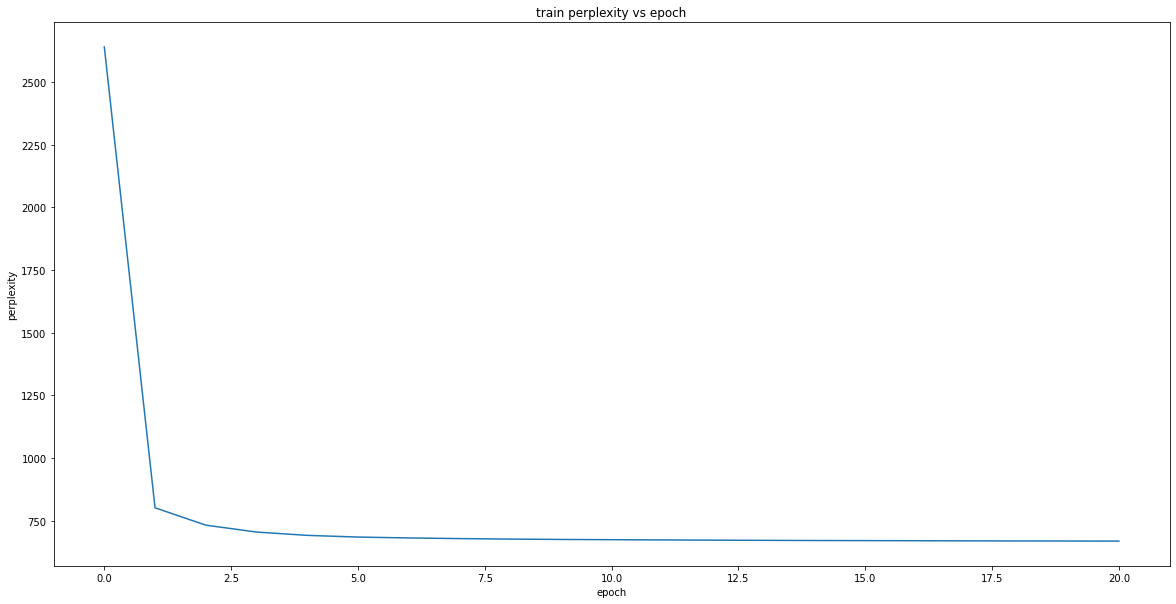

(28.17853844729337, 6.915907522548329, 6.7754616355896, 6.722081808610396, 6.6954569227045235, 6.684984226226806, 6.680638593326916, 6.671778698834506, 6.672376069155606, 6.674662970629606, 6.667603487534956, 6.672012596997348, 6.66788610198281, 6.664541078914295, 6.663073306517168, 6.66453598022461, 6.662561390616677, 6.66284438826821, 6.662200124913996, 6.660599291541359, 6.662257367047396, 6.662060152400624)
[1.72895526e+12 1.00818556e+03 8.76083701e+02 8.30544748e+02
 8.08723374e+02 8.00298054e+02 7.96827798e+02 7.89799171e+02
 7.90271114e+02 7.92080455e+02 7.86508467e+02 7.89983925e+02
 7.86730777e+02 7.84103541e+02 7.82953499e+02 7.84099543e+02
 7.82552796e+02 7.82774288e+02 7.82270137e+02 7.81018855e+02
 7.82314917e+02 7.82160649e+02]


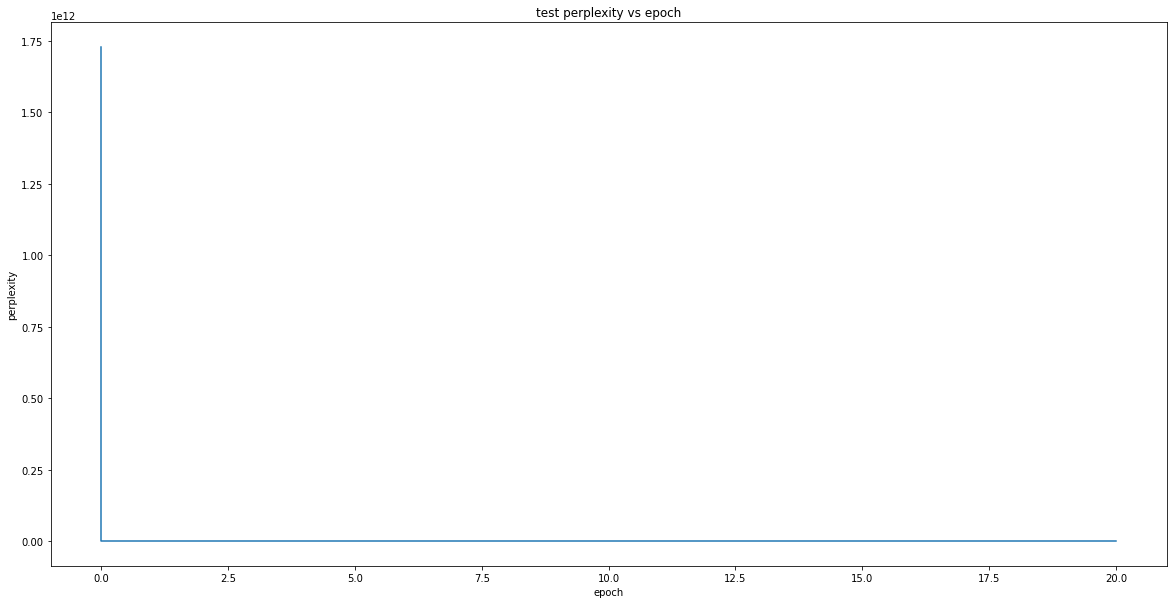

In [ ]:
LOG_PATH = DATA_PATH + 'logs/word_log.pkl'
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
train_epochs, train_perplexities = get_perplexities(train_losses)
pt_util.plot(train_epochs, train_perplexities, "train perplexity vs epoch", "epoch", "perplexity")
test_epochs, test_perplexities = get_perplexities(test_losses)
pt_util.plot(test_epochs, test_perplexities, "test perplexity vs epoch", "epoch", "perplexity")

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    